<a href="https://colab.research.google.com/github/campofernando/lcqar-low-cost-monit-proc/blob/main/co-sensor-mob-monitor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Monta drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Instala módulos

In [ ]:
!pip install geopandas
#!pip install osmnx
#!pip install folium

     |████████████████████████████████| 1.0MB 4.1MB/s 
     |████████████████████████████████| 14.8MB 282kB/s 
     |████████████████████████████████| 6.5MB 44.0MB/s 


### Importa bibliotecas

In [ ]:
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import numpy as np
from scipy import stats
from pathlib import Path

dataFolder = Path(
    "/content/drive/My Drive/LCQAr/DATA/CAMPANHAS 2020/MEDIÇÕES EM RUAS 2020-08/MISSÕES/AERCIO MÓVEL/LOGS TODOS")
snifferFolder = Path(
    "/content/drive/My Drive/LCQAr/DATA/CAMPANHAS 2020/MEDIÇÕES EM RUAS 2020-08/MISSÕES/SNIFFER 4D/Arquivos CSV Percurso")
shapefileFolder = Path(
    "/content/drive/My Drive/LCQAr/DATA/CAMPANHAS 2020/MEDIÇÕES EM RUAS 2020-08/SHAPEFILES")
baseFolder = Path(
    "/content/drive/My Drive/LCQAr/DATA/CAMPANHAS 2020/MEDIÇÕES EM RUAS 2020-08")

### Classes e funções

In [ ]:
def validate_value(df, upper_limit, lower_limit):
  # df[0]: Value
  # df[1]: Tag
  if df[1] != 'VALID'   : return df[1]
  if (df[0] <= -9000.0  or 
      np.isnan(df[0]))  : return 'MISSING' 
  if df[0] < lower_limit: return 'LTLL'
  if df[0] > upper_limit: return 'GTUL'
  return 'VALID'

def validate_with_RH(df):
  # df[0]: Tag
  # df[1]: RH-TAG
  if df[0] != 'VALID'   : return df[0]
  if (df[1] == 'GTUL' or
      df[1] == 'LTLL')  : return 'BAD-RH'
  return 'VALID'

def validate_with_qtle(df):
  # df[0]: Value
  # df[1]: Tag
  # df[2]: QTLE01
  # df[3]: QTLE99
  # df[4]: VALID_HR_COUNT
  if df[1] != 'VALID'   : return df[1]
  if df[4]:
    if df[0] <= df[2]     : return 'LTQTLE01'
    if df[0] >= df[3]     : return 'GTQTLE99'
  return 'VALID'

def load_data(filename):
  date_time_col = ['Year','Month','Day','Hour','Minute','Second']
  var = pd.read_csv(filename)
  var['DateTime'] = (pd.to_datetime(var[date_time_col], 
                                    infer_datetime_format=False, 
                                    format='%d/%m/%Y/%H/%M/%S'))
  return (var.where(var['DateTime'] > dt.datetime(2019,1,1,0,0,0)).
              where(var['DateTime'] <= dt.datetime.now()).dropna())

def count_tags(tags_list, df):
  tags_list.append('TOTAL')
  count = len(df)
  data_count = pd.DataFrame(index=tags_list, columns=['#', '%'])
  data_count.loc['TOTAL'] = [count, (count/count)*100]

  for tag in data_count.index[:-1]:
    val = (df.where(df['Tag'] == tag)
              .count()['Tag'])  # Fiz assim pq count() não conta os nan
    data_count.loc[tag] = [val, (val/count)*100]

  return data_count

### Importa dados

#### Dados de Umidade Relativa

In [ ]:
dados_RH = load_data(filename=dataFolder.joinpath("RH_LOG.CSV"))
dados_RH = dados_RH.where(dados_RH['DateTime'] >
                                    dt.datetime(2020,3,14,0,0,0)).dropna()
dados_RH = (dados_RH.sort_values(
    by='DateTime', ascending=True).reset_index().drop(columns='index'))
dados_RH.index=dados_RH['DateTime']
dados_RH = dados_RH.drop(columns=['DateTime', 'Altitude', 
                                      'Minute', 'Second',
                                      'Device', ' SensorID'])
dados_RH.head()

Year  Month  Day  ...  Longitude  DeviceSt  Value
DateTime                                 ...                            
2020-08-03 14:10:59  2020.0    8.0  3.0  ... -99.989997       0.0  66.67
2020-08-03 14:11:41  2020.0    8.0  3.0  ... -99.989997       0.0  67.00
2020-08-03 14:12:23  2020.0    8.0  3.0  ... -99.989997       0.0  67.83
2020-08-03 14:13:05  2020.0    8.0  3.0  ... -99.989997       0.0  65.00
2020-08-03 14:13:47  2020.0    8.0  3.0  ... -99.989997       0.0  64.33

[5 rows x 8 columns]

##### Etiqueta dados de RH segundo DeviceSt

#        %
STABILZ  3145  51.5997
VALID    2950  48.4003
TOTAL    6095      100

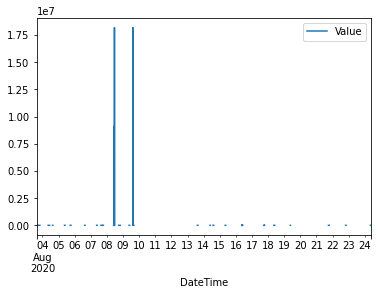

In [ ]:
# Remove outlier por aquecimento
dados_RH['Tag'] = dados_RH['DeviceSt'].map(
    lambda st: 'STABILZ' if st%2 <= 0 else 'VALID')

dados_RH['GPS'] = dados_RH['DeviceSt'].map(lambda st: st >= 2)

data_contabilization = count_tags(['STABILZ','VALID'], 
                                  dados_RH)

dados_RH.head()

(dados_RH[dados_RH['Tag'] == 'VALID'].resample('2T')
 .mean().plot(y='Value'))
data_contabilization

#         %
MISSING     0         0
STABILZ  3145   51.5997
LTLL        0         0
GTUL       11  0.180476
VALID    2939   48.2199
TOTAL    6095       100

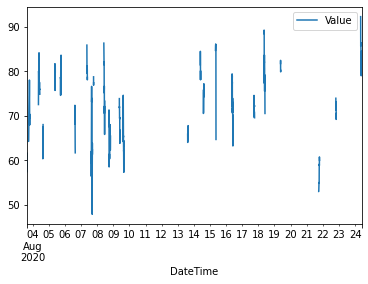

In [ ]:
dados_RH['Tag'] = (dados_RH[['Value', 'Tag']]
                     .apply(lambda v: validate_value(v, 100, 0.0), axis=1))

data_contabilization = count_tags(['MISSING','STABILZ','LTLL', 'GTUL', 
                                   'VALID'], dados_RH)

(dados_RH[dados_RH['Tag'] == 'VALID'].resample('2T')
 .mean().plot(y='Value'))
data_contabilization

#### Dados de CO SPEC

In [ ]:
dados_SPEC = load_data(filename=dataFolder.joinpath("CO_LOG.CSV"))
dados_SPEC = dados_SPEC.where(dados_SPEC['DateTime'] >
                                    dt.datetime(2020,3,14,0,0,0)).dropna()
dados_SPEC = (dados_SPEC.sort_values(
    by='DateTime', ascending=True).reset_index().drop(columns='index'))
dados_SPEC.index=dados_SPEC['DateTime']
dados_SPEC = dados_SPEC.drop(columns=['DateTime', 'Altitude', 
                                      'Minute', 'Second',
                                      'Device', ' SensorID'])
dados_SPEC.head()

Year  Month  Day  ...  Longitude  DeviceSt    Value
DateTime                                 ...                              
2020-08-03 14:11:06  2020.0    8.0  3.0  ... -99.989997       1.0  2828.67
2020-08-03 14:11:48  2020.0    8.0  3.0  ... -99.989997       1.0  2679.00
2020-08-03 14:12:30  2020.0    8.0  3.0  ... -99.989997       1.0  2834.67
2020-08-03 14:13:12  2020.0    8.0  3.0  ... -99.989997       1.0  2922.00
2020-08-03 14:13:54  2020.0    8.0  3.0  ... -99.989997       1.0  2876.50

[5 rows x 8 columns]

##### Etiqueta dados de CO segundo DeviceSt

#        %
STABILZ  2747  45.0107
VALID    3356  54.9893
TOTAL    6103      100

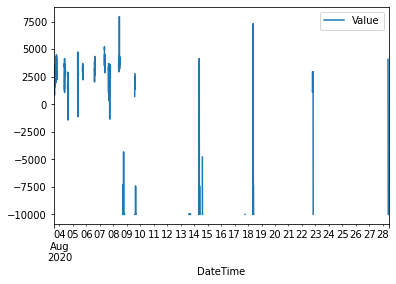

In [ ]:
# Remove outlier por aquecimento
dados_SPEC['Tag'] = dados_SPEC['DeviceSt'].map(
    lambda st: 'STABILZ' if st%2 <= 0 else 'VALID')

dados_SPEC['GPS'] = dados_SPEC['DeviceSt'].map(lambda st: st >= 2)

data_contabilization = count_tags(['STABILZ','VALID'], 
                                  dados_SPEC)

#dados_SPEC = dados_SPEC.drop(columns='DeviceSt')
dados_SPEC.head()

(dados_SPEC[dados_SPEC['Tag'] == 'VALID'].resample('2T')
 .mean().plot(y='Value'))
data_contabilization

#### Dados de CO SPEC 2019

In [ ]:
dados_SPEC2019 = load_data(filename=dataFolder.joinpath("DATALOG.CSV"))
dados_SPEC2019 = dados_SPEC2019.where(dados_SPEC2019['DateTime'] >
                                    dt.datetime(2019,9,25,0,0,0)).dropna()
dados_SPEC2019 = (dados_SPEC2019.sort_values(
    by='DateTime', ascending=True).reset_index().drop(columns='index'))
dados_SPEC2019.index=dados_SPEC2019['DateTime']
dados_SPEC2019 = dados_SPEC2019.drop(columns=['DateTime', 'Altitude', 
                                      'Minute', 'Second', 'Device'])
dados_SPEC2019.head()

Year  Month   Day  ...  SO2(ppb)  Temperature(C)  Humidity(%)
DateTime                                  ...                                       
2019-09-25 21:00:00  2019.0    9.0  25.0  ...  -9999.99             0.0          0.0
2019-09-25 21:00:00  2019.0    9.0  25.0  ...  -9999.99             0.0          0.0
2019-09-25 21:00:30  2019.0    9.0  25.0  ...      0.00            25.0         77.0
2019-09-25 21:00:40  2019.0    9.0  25.0  ...  -9999.99            26.0         75.0
2019-09-25 21:01:00  2019.0    9.0  25.0  ...      0.00            26.0         62.0

[5 rows x 13 columns]

##### Etiqueta dados de CO segundo DeviceSt

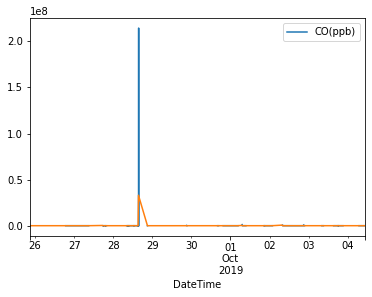

In [ ]:
# Remove outlier por aquecimento
dados_SPEC2019['Tag'] = dados_SPEC2019['DeviceSt'].map(
    lambda st: 'VALID' if st > 0 else 'INVALID')

data_contabilization = count_tags(['INVALID','VALID'], 
                                  dados_SPEC2019)

dados_SPEC2019.head()

(dados_SPEC2019[dados_SPEC2019['Tag'] == 'VALID'].resample('2T')
 .mean().plot(y='CO(ppb)'))

dados_SPEC2019_valid = (dados_SPEC2019[(dados_SPEC2019['Tag'] == 'VALID')]
                    .resample('15T').mean().dropna(how='all')).copy()

data_contabilization
dados_SPEC2019_valid['CO(ppb)'].plot()

#### Importa dados do Sniffer Todos

Longitude   Latitude  Temperature   Humidity        CO
Time Stamp                                                                 
2020-08-03 14:28:00 -48.518220 -27.600500    23.860054  51.145713  0.416137
2020-08-03 14:29:00 -48.518300 -27.600447    23.686275  52.480392  0.400242
2020-08-03 14:30:00 -48.517937 -27.600635    23.411765  52.686275  0.350937
2020-08-03 14:31:00 -48.517980 -27.600715    23.529411  52.235294  0.350212
2020-08-03 14:33:00 -48.518681 -27.600776    22.983468  53.806228  0.312280

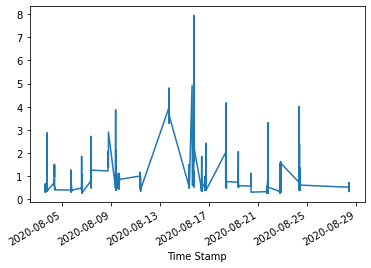

In [ ]:
dados_Sniffer = pd.read_csv(snifferFolder.joinpath(
    "Sniffer.CSV"))
dados_Sniffer = (dados_Sniffer.sort_values(by='Time Stamp', ascending=True)
         .reset_index().drop(columns='index'))
dados_Sniffer.index = pd.to_datetime(dados_Sniffer['Time Stamp'], 
                                     format='%Y-%m-%d %H:%M:%S')
dados_Sniffer = (dados_Sniffer[['Longitude','Latitude','Temperature ?',
                               'Humidity %', 'CO mg/m\N{SUPERSCRIPT THREE}']]
                 .rename(columns={"Temperature ?": "Temperature",
                                  "Humidity %": "Humidity",
                                  "CO mg/m\N{SUPERSCRIPT THREE}": "CO"})
                 .resample('1T').mean().dropna(how='all'))
dados_Sniffer['CO'].plot()
dados_Sniffer.head()

#### Importa dados do Sniffer do Percurso 1

Longitude   Latitude  Temperature   Humidity        CO
Time Stamp                                                                 
2020-08-06 13:46:00 -48.518282 -27.600858    23.725491  54.303921  0.491058
2020-08-06 13:48:00 -48.518276 -27.600793    23.725491  54.344771  0.478006
2020-08-06 13:50:00 -48.518261 -27.600759    23.782680  54.308823  0.470816
2020-08-06 13:52:00 -48.518245 -27.600758    23.921568  54.292483  0.465167
2020-08-06 13:54:00 -48.518218 -27.600793    23.885746  53.844268  0.419359
...                        ...        ...          ...        ...       ...
2020-08-28 09:14:00 -48.523336 -27.578064    22.352942  63.889727  0.438144
2020-08-28 09:16:00 -48.526650 -27.574559    22.156862  66.584967  0.387462
2020-08-28 09:18:00 -48.531593 -27.572294    21.972790  68.651460  0.336051
2020-08-28 09:48:00 -48.543203 -27.576037    22.352942  66.039216  0.451360
2020-08-28 10:00:00 -48.522146 -27.583759    23.725491  58.039215  0.695469

[283 rows x 5 columns]

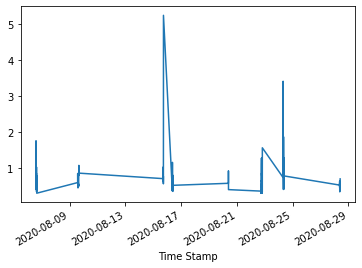

In [ ]:
dados_Sniffer_Per1 = pd.read_csv(snifferFolder.joinpath(
    "Per1.CSV"))
dados_Sniffer_Per1 = (dados_Sniffer_Per1.sort_values(by='Time Stamp', ascending=True)
         .reset_index().drop(columns='index'))
dados_Sniffer_Per1.index = pd.to_datetime(dados_Sniffer_Per1['Time Stamp'], 
                                     format='%Y-%m-%d %H:%M:%S')
dados_Sniffer_Per1 = (dados_Sniffer_Per1[['Longitude','Latitude','Temperature ?',
                               'Humidity %', 'CO mg/m\N{SUPERSCRIPT THREE}']]
                 .rename(columns={"Temperature ?": "Temperature",
                                  "Humidity %": "Humidity",
                                  "CO mg/m\N{SUPERSCRIPT THREE}": "CO"})
                 .resample('2T').mean().dropna(how='all'))
dados_Sniffer_Per1['CO'].plot()
dados_Sniffer_Per1

#### Importa dados do Sniffer do Percurso 2

Longitude   Latitude  Temperature   Humidity        CO
Time Stamp                                                                 
2020-08-03 14:28:00 -48.518263 -27.600471    23.766119  51.867161  0.407545
2020-08-03 14:30:00 -48.517968 -27.600692    23.495798  52.364146  0.350419
2020-08-03 14:32:00 -48.518681 -27.600776    22.983468  53.806228  0.312280
2020-08-03 14:34:00 -48.519636 -27.600774    23.766340  52.341503  0.417342
2020-08-03 14:36:00 -48.521055 -27.601392    24.307190  51.867647  0.438641
...                        ...        ...          ...        ...       ...
2020-08-19 09:06:00 -48.522600 -27.603182    19.714052  78.544117  0.510363
2020-08-19 09:08:00 -48.521679 -27.602296    19.607843  78.205882  0.520000
2020-08-19 09:10:00 -48.520531 -27.601463    19.607843  79.348039  0.598007
2020-08-19 09:12:00 -48.519515 -27.600858    19.607843  78.643791  0.551390
2020-08-19 09:14:00 -48.518647 -27.600461    19.545923  78.929308  0.595755

[268 rows x 5 columns]

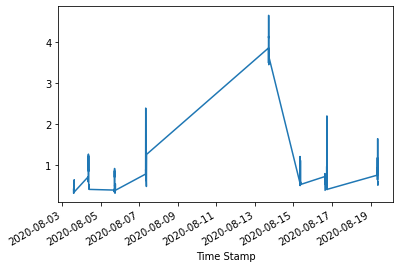

In [ ]:
dados_Sniffer_Per2 = pd.read_csv(snifferFolder.joinpath(
    "Per2.CSV"))
dados_Sniffer_Per2 = (dados_Sniffer_Per2.sort_values(by='Time Stamp', ascending=True)
         .reset_index().drop(columns='index'))
dados_Sniffer_Per2.index = pd.to_datetime(dados_Sniffer_Per2['Time Stamp'], 
                                     format='%Y-%m-%d %H:%M:%S')
dados_Sniffer_Per2 = (dados_Sniffer_Per2[['Longitude','Latitude','Temperature ?',
                               'Humidity %', 'CO mg/m\N{SUPERSCRIPT THREE}']]
                 .rename(columns={"Temperature ?": "Temperature",
                                  "Humidity %": "Humidity",
                                  "CO mg/m\N{SUPERSCRIPT THREE}": "CO"})
                 .resample('2T').mean().dropna(how='all'))
dados_Sniffer_Per2['CO'].plot()
dados_Sniffer_Per2

#### Importa dados do Sniffer do Percurso 3

Longitude   Latitude  Temperature   Humidity        CO
Time Stamp                                                                 
2020-08-03 16:54:00 -48.518212 -27.600495    21.948849  57.887468  0.336309
2020-08-03 16:56:00 -48.518250 -27.600443    21.604576  59.112746  0.338701
2020-08-03 16:58:00 -48.518679 -27.600259    21.764706  58.509806  0.371964
2020-08-03 18:02:00 -48.518489 -27.600440    21.372549  61.792717  0.382736
2020-08-03 18:04:00 -48.517757 -27.600893    21.010818  62.942867  0.443047
...                        ...        ...          ...        ...       ...
2020-08-21 19:00:00 -48.523402 -27.601697    12.549020  57.727124  0.306737
2020-08-21 19:02:00 -48.523402 -27.601697    12.705882  56.323529  0.551058
2020-08-21 19:04:00 -48.523402 -27.601697    12.808823  55.991831  1.085016
2020-08-21 19:06:00 -48.523402 -27.601697    12.745098  56.027778  0.595650
2020-08-21 19:08:00 -48.523402 -27.601697    12.813897  56.231511  0.501352

[276 rows x 5 columns]

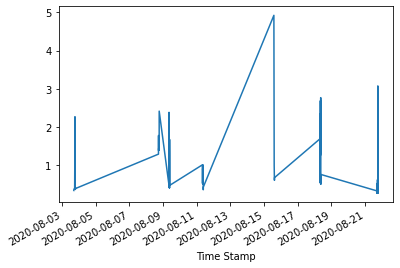

In [ ]:
dados_Sniffer_Per3 = pd.read_csv(snifferFolder.joinpath(
    "Per3.CSV"))
dados_Sniffer_Per3 = (dados_Sniffer_Per3.sort_values(by='Time Stamp', ascending=True)
         .reset_index().drop(columns='index'))
dados_Sniffer_Per3.index = pd.to_datetime(dados_Sniffer_Per3['Time Stamp'], 
                                     format='%Y-%m-%d %H:%M:%S')
dados_Sniffer_Per3 = (dados_Sniffer_Per3[['Longitude','Latitude','Temperature ?',
                               'Humidity %', 'CO mg/m\N{SUPERSCRIPT THREE}']]
                 .rename(columns={"Temperature ?": "Temperature",
                                  "Humidity %": "Humidity",
                                  "CO mg/m\N{SUPERSCRIPT THREE}": "CO"})
                 .resample('2T').mean().dropna(how='all'))
dados_Sniffer_Per3['CO'].plot()
dados_Sniffer_Per3

In [ ]:
dados_Sniffer['Weekday']  = dados_Sniffer.index.map(lambda d: d.weekday())
dados_Sniffer['Week']     = dados_Sniffer.index.map(lambda d: d.week)
dados_Sniffer['Month']    = dados_Sniffer.index.map(lambda d: d.month)

dados_Sniffer.head()

NameError: ignored

### Manipulação dos dados

#### Etiqueta dados de Monóxido de Carbono SPEC

#        %
MISSING  1183  19.3839
STABILZ  2747  45.0107
LTLL        0        0
GTUL        0        0
VALID    2173  35.6054
TOTAL    6103      100

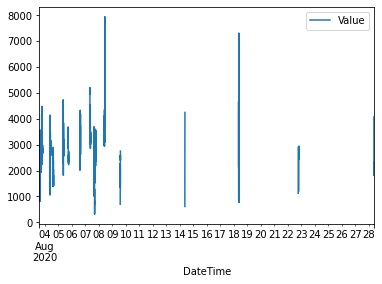

In [ ]:
dados_SPEC['Tag'] = (dados_SPEC[['Value', 'Tag']]
                     .apply(lambda v: validate_value(v, 1e6, 100.0), axis=1))

data_contabilization = count_tags(['MISSING','STABILZ','LTLL', 'GTUL', 
                                   'VALID'], dados_SPEC)
(dados_SPEC[dados_SPEC['Tag'] == 'VALID'].resample('2T')
 .mean().plot(y='Value'))

data_contabilization

#### Dados válidos sem câlculo de quartís

Year  Month   Day  Hour  ...  Longitude  DeviceSt  Value  GPS
DateTime                                        ...                                 
2020-08-03 15:17:00  2020.0    8.0   3.0  15.0  ... -48.519172       3.0  57.50  1.0
2020-08-03 15:18:00  2020.0    8.0   3.0  15.0  ... -48.518749       3.0  57.50  1.0
2020-08-03 18:11:00  2020.0    8.0   3.0  18.0  ... -48.517425       3.0  67.50  1.0
2020-08-03 18:12:00  2020.0    8.0   3.0  18.0  ... -48.517642       3.0  68.17  1.0
2020-08-03 18:13:00  2020.0    8.0   3.0  18.0  ... -48.518630       3.0  68.50  1.0
...                     ...    ...   ...   ...  ...        ...       ...    ...  ...
2020-08-24 09:35:00  2020.0    8.0  24.0   9.0  ... -48.510173       3.0  82.17  1.0
2020-08-24 09:36:00  2020.0    8.0  24.0   9.0  ... -48.512704       3.0  82.17  1.0
2020-08-24 09:37:00  2020.0    8.0  24.0   9.0  ... -48.515018       3.0  82.17  1.0
2020-08-24 09:38:00  2020.0    8.0  24.0   9.0  ... -48.517236       3.0  82.17  1.0
2020-08-24 09:39:00  2020.0    8.0  24.0   9.0  ... -48.518197       3.0  82.17  1.0

[704 rows x 9 columns]

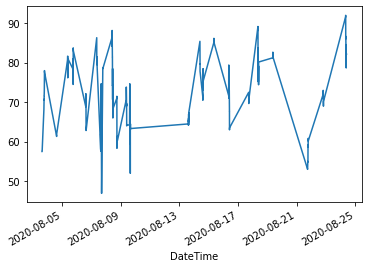

In [ ]:
dados_RH_valid = (dados_RH[(dados_RH['Tag'] == 'VALID') &
                               (dados_RH['GPS'])]
                    .resample('1T').mean().dropna(how='all')).copy()

dados_RH_valid['Value'].plot()
dados_RH_valid

Year  Month   Day  ...  DeviceSt     Value  GPS
DateTime                                  ...                         
2020-08-03 14:27:00  2020.0    8.0   3.0  ...       3.0  2555.000  1.0
2020-08-03 14:28:00  2020.0    8.0   3.0  ...       3.0  2949.000  1.0
2020-08-03 14:29:00  2020.0    8.0   3.0  ...       3.0  3199.665  1.0
2020-08-03 14:30:00  2020.0    8.0   3.0  ...       3.0  2993.335  1.0
2020-08-03 14:31:00  2020.0    8.0   3.0  ...       3.0  2374.080  1.0
...                     ...    ...   ...  ...       ...       ...  ...
2020-08-28 09:29:00  2020.0    8.0  28.0  ...       3.0  4412.335  1.0
2020-08-28 09:30:00  2020.0    8.0  28.0  ...       3.0  4617.830  1.0
2020-08-28 09:31:00  2020.0    8.0  28.0  ...       3.0  1194.500  1.0
2020-08-28 09:34:00  2020.0    8.0  28.0  ...       3.0  1453.000  1.0
2020-08-28 09:39:00  2020.0    8.0  28.0  ...       3.0   561.330  1.0

[1095 rows x 9 columns]

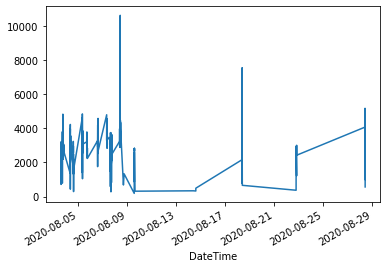

In [ ]:
dados_SPEC_valid = (dados_SPEC[(dados_SPEC['Tag'] == 'VALID') &
                               (dados_SPEC['GPS'])]
                    .resample('1T').mean().dropna(how='all')).copy()

dados_SPEC_valid['Value'].plot()
dados_SPEC_valid

#### Converte SPEC a mg/m3

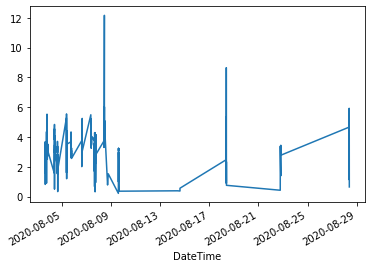

In [ ]:
M_CO = 28.01
dados_SPEC_valid['Value'] = dados_SPEC_valid['Value'].map(
    lambda v: 0.0409*v*M_CO/1e3)
dados_SPEC_valid['Value'].plot()

#### Salva dados válidos SPEC

In [ ]:
dados_RH_valid.to_csv(dataFolder.joinpath('RH_valid.csv'))

In [ ]:
dados_SPEC_valid.to_csv(dataFolder.joinpath('CO_valid.csv'))

#### Salva dados válidos Sniffer

In [ ]:
dados_Sniffer.to_csv(dataFolder.joinpath('Sniffer_Proc.csv'))

### Trabalho com os dados

#### Transforma em GeoPandas

In [ ]:
dados_RH_validGeo = gpd.GeoDataFrame(
    dados_RH_valid.drop(columns=['DeviceSt','GPS']),
    geometry = [Point(xy)for xy in zip(dados_RH_valid['Longitude'], 
                  dados_RH_valid['Latitude'])])
dados_RH_validGeo.head()

Year  Month  ...  Value                     geometry
DateTime                            ...                                    
2020-08-03 15:17:00  2020.0    8.0  ...  57.50  POINT (-48.51917 -27.60092)
2020-08-03 15:18:00  2020.0    8.0  ...  57.50  POINT (-48.51875 -27.60063)
2020-08-03 18:11:00  2020.0    8.0  ...  67.50  POINT (-48.51743 -27.60526)
2020-08-03 18:12:00  2020.0    8.0  ...  68.17  POINT (-48.51764 -27.60548)
2020-08-03 18:13:00  2020.0    8.0  ...  68.50  POINT (-48.51863 -27.60629)

[5 rows x 8 columns]

In [ ]:
dados_RH_validGeo.to_csv(dataFolder.joinpath('RH_Geo_valid.csv'))

In [ ]:
dados_SPEC_validGeo = gpd.GeoDataFrame(
    dados_SPEC_valid.drop(columns=['DeviceSt','GPS']),
    geometry = [Point(xy)for xy in zip(dados_SPEC_valid['Longitude'], 
                  dados_SPEC_valid['Latitude'])])
dados_SPEC_validGeo.head()

Year  Month  ...     Value                     geometry
DateTime                            ...                                       
2020-08-03 14:27:00  2020.0    8.0  ...  2.927031  POINT (-48.51818 -27.60052)
2020-08-03 14:28:00  2020.0    8.0  ...  3.378401  POINT (-48.51817 -27.60052)
2020-08-03 14:29:00  2020.0    8.0  ...  3.665565  POINT (-48.51818 -27.60052)
2020-08-03 14:30:00  2020.0    8.0  ...  3.429192  POINT (-48.51818 -27.60052)
2020-08-03 14:31:00  2020.0    8.0  ...  2.719767  POINT (-48.51818 -27.60052)

[5 rows x 8 columns]

In [ ]:
dados_SPEC_validGeo.to_csv(dataFolder.joinpath('CO_Geo_valid.csv'))

In [ ]:
dados_SPEC_2019Geo = gpd.GeoDataFrame(
    dados_SPEC2019_valid.drop(columns=['NO2(ppb)','O3(ppb)','SO2(ppb)',
                                       'Temperature(C)','Humidity(%)']),
    geometry = [Point(xy)for xy in zip(dados_SPEC2019_valid['Longitude'], 
                  dados_SPEC2019_valid['Latitude'])])
dados_SPEC_2019Geo.head()

Year  Month  ...      CO(ppb)                     geometry
DateTime                            ...                                          
2019-09-25 21:00:00  2019.0    9.0  ... -1304.614286  POINT (-48.51849 -27.60038)
2019-09-26 18:30:00  2019.0    9.0  ... -9999.990000  POINT (-48.51876 -27.60048)
2019-09-26 18:45:00  2019.0    9.0  ...  4695.722381  POINT (-48.51840 -27.60046)
2019-09-26 19:00:00  2019.0    9.0  ...  4915.394516  POINT (-48.51842 -27.60055)
2019-09-26 19:15:00  2019.0    9.0  ...  5085.788000  POINT (-48.51815 -27.60105)

[5 rows x 9 columns]

In [ ]:
dados_Sniffer_Geo = gpd.GeoDataFrame(
    dados_Sniffer,geometry = [Point(xy) for xy in 
                                       zip(dados_Sniffer['Longitude'], 
                                           dados_Sniffer['Latitude'])])
dados_Sniffer_Geo

Longitude  ...                     geometry
Time Stamp                      ...                             
2020-08-03 14:28:00 -48.518220  ...  POINT (-48.51822 -27.60050)
2020-08-03 14:29:00 -48.518300  ...  POINT (-48.51830 -27.60045)
2020-08-03 14:30:00 -48.517937  ...  POINT (-48.51794 -27.60064)
2020-08-03 14:31:00 -48.517980  ...  POINT (-48.51798 -27.60072)
2020-08-03 14:33:00 -48.518681  ...  POINT (-48.51868 -27.60078)
...                        ...  ...                          ...
2020-08-28 09:17:00 -48.527773  ...  POINT (-48.52777 -27.57366)
2020-08-28 09:18:00 -48.530727  ...  POINT (-48.53073 -27.57257)
2020-08-28 09:19:00 -48.532962  ...  POINT (-48.53296 -27.57185)
2020-08-28 09:49:00 -48.543203  ...  POINT (-48.54320 -27.57604)
2020-08-28 10:01:00 -48.522146  ...  POINT (-48.52215 -27.58376)

[1593 rows x 6 columns]

In [ ]:
dados_Sniffer_Per1_Geo = gpd.GeoDataFrame(
    dados_Sniffer_Per1,geometry = [Point(xy) for xy in 
                                       zip(dados_Sniffer_Per1['Longitude'], 
                                           dados_Sniffer_Per1['Latitude'])])
dados_Sniffer_Per1_Geo

NameError: ignored

In [ ]:
dados_Sniffer_Per2_Geo = gpd.GeoDataFrame(
    dados_Sniffer_Per2,geometry = [Point(xy) for xy in 
                                       zip(dados_Sniffer_Per2['Longitude'], 
                                           dados_Sniffer_Per2['Latitude'])])
dados_Sniffer_Per2_Geo

Longitude  ...                     geometry
Time Stamp                      ...                             
2020-08-03 14:28:00 -48.518263  ...  POINT (-48.51826 -27.60047)
2020-08-03 14:30:00 -48.517968  ...  POINT (-48.51797 -27.60069)
2020-08-03 14:32:00 -48.518681  ...  POINT (-48.51868 -27.60078)
2020-08-03 14:34:00 -48.519636  ...  POINT (-48.51964 -27.60077)
2020-08-03 14:36:00 -48.521055  ...  POINT (-48.52106 -27.60139)
...                        ...  ...                          ...
2020-08-19 09:06:00 -48.522600  ...  POINT (-48.52260 -27.60318)
2020-08-19 09:08:00 -48.521679  ...  POINT (-48.52168 -27.60230)
2020-08-19 09:10:00 -48.520531  ...  POINT (-48.52053 -27.60146)
2020-08-19 09:12:00 -48.519515  ...  POINT (-48.51952 -27.60086)
2020-08-19 09:14:00 -48.518647  ...  POINT (-48.51865 -27.60046)

[268 rows x 6 columns]

In [ ]:
dados_Sniffer_Per3_Geo = gpd.GeoDataFrame(
    dados_Sniffer_Per3,geometry = [Point(xy) for xy in 
                                       zip(dados_Sniffer_Per3['Longitude'], 
                                           dados_Sniffer_Per3['Latitude'])])
dados_Sniffer_Per3_Geo

Longitude  ...                     geometry
Time Stamp                      ...                             
2020-08-03 16:54:00 -48.518212  ...  POINT (-48.51821 -27.60050)
2020-08-03 16:56:00 -48.518250  ...  POINT (-48.51825 -27.60044)
2020-08-03 16:58:00 -48.518679  ...  POINT (-48.51868 -27.60026)
2020-08-03 18:02:00 -48.518489  ...  POINT (-48.51849 -27.60044)
2020-08-03 18:04:00 -48.517757  ...  POINT (-48.51776 -27.60089)
...                        ...  ...                          ...
2020-08-21 19:00:00 -48.523402  ...  POINT (-48.52340 -27.60170)
2020-08-21 19:02:00 -48.523402  ...  POINT (-48.52340 -27.60170)
2020-08-21 19:04:00 -48.523402  ...  POINT (-48.52340 -27.60170)
2020-08-21 19:06:00 -48.523402  ...  POINT (-48.52340 -27.60170)
2020-08-21 19:08:00 -48.523402  ...  POINT (-48.52340 -27.60170)

[276 rows x 6 columns]

#### Polígonos

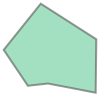

In [ ]:
coords = [(-48.525443452860124,-27.601663185840472),
          (-48.52379121210695,-27.604116167851497),
          (-48.522417921091325,-27.603964046533118),
          (-48.519156354929216,-27.604591545610287),
          (-48.51911343958498,-27.600940591522704),
          (-48.522911447550065,-27.598506554557108),
          (-48.525443452860124,-27.601663185840472)]

polyUFSC = Polygon(coords)
polyUFSC

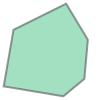

In [ ]:
coords = [(-48.512065790044915,-27.59834964698295), 
          (-48.50477018152441,-27.599566673965164), 
          (-48.50219526087011,-27.59743686787783), 
          (-48.50176610742773,-27.59264465287037),
          (-48.5044268587705,-27.588232587178442),
          (-48.51086416040624,-27.59142754903378),
          (-48.512065790044915,-27.59834964698295)]
polyBairro = Polygon(coords)
polyBairro

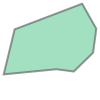

In [ ]:
coords = [(-48.5132887775032,-27.592968571186216),
          (-48.5147478992073,-27.598977805554313),
          (-48.50770978275222,-27.59829322586154),
          (-48.505392354163355,-27.598597484030655),
          (-48.50281743350906,-27.596087328876695),
          (-48.502388280066675,-27.59289250281703),
          (-48.50427655521316,-27.589545442321057),
          (-48.5132887775032,-27.592968571186216)]
polyBairro2 = Polygon(coords)
polyBairro2

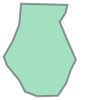

In [ ]:
coords = [(-48.469571244000264,-27.597587205961286), 
          (-48.46510804819948,-27.590893269451794), 
          (-48.46270478892214,-27.58389462609442), 
          (-48.45995820689089,-27.578417115388888),
          (-48.464764725445576,-27.5674612734486),
          (-48.468541275738545,-27.558330569613986),
          (-48.46545137095339,-27.553460550376343),
          (-48.46442140269167,-27.54919910636745),
          (-48.48914064097292,-27.548590315153824),
          (-48.49017060923464,-27.559852406327913),
          (-48.4936038367737,-27.56837430205791),
          (-48.49841035532839,-27.576895536094085),
          (-48.49669374155886,-27.581460210662424),
          (-48.49017060923464,-27.58937186324171),
          (-48.48708070444948,-27.59545736141004),
          (-48.480557572125264,-27.59789146609027),
          (-48.469571244000264,-27.597587205961286)]
polyLagoa = Polygon(coords)
polyLagoa

#### Seleciona dados RH dentro do Polígono Residencial

In [ ]:
dados_RH_validGeo['Area Type'] = dados_RH_validGeo['geometry'].map(
    lambda p: 'RESIDENTIAL' if (p.within(polyUFSC) or p.within(polyBairro) or
                                p.within(polyBairro2)) 
                            else 'STREET')
dados_RH_validGeo.head()

Year  Month  ...                     geometry    Area Type
DateTime                            ...                                          
2020-08-03 15:17:00  2020.0    8.0  ...  POINT (-48.51917 -27.60092)  RESIDENTIAL
2020-08-03 15:18:00  2020.0    8.0  ...  POINT (-48.51875 -27.60063)       STREET
2020-08-03 18:11:00  2020.0    8.0  ...  POINT (-48.51743 -27.60526)       STREET
2020-08-03 18:12:00  2020.0    8.0  ...  POINT (-48.51764 -27.60548)       STREET
2020-08-03 18:13:00  2020.0    8.0  ...  POINT (-48.51863 -27.60629)       STREET

[5 rows x 9 columns]

#### Seleciona dados SPEC dentro do Polígono Residencial

In [ ]:
dados_SPEC_validGeo['Area Type'] = dados_SPEC_validGeo['geometry'].map(
    lambda p: 'RESIDENTIAL' if (p.within(polyUFSC) or p.within(polyBairro) or
                                p.within(polyBairro2)) 
                            else 'STREET')
dados_SPEC_validGeo.head()

Year  Month  ...                     geometry  Area Type
DateTime                            ...                                        
2020-08-03 14:27:00  2020.0    8.0  ...  POINT (-48.51818 -27.60052)     STREET
2020-08-03 14:28:00  2020.0    8.0  ...  POINT (-48.51817 -27.60052)     STREET
2020-08-03 14:29:00  2020.0    8.0  ...  POINT (-48.51818 -27.60052)     STREET
2020-08-03 14:30:00  2020.0    8.0  ...  POINT (-48.51818 -27.60052)     STREET
2020-08-03 14:31:00  2020.0    8.0  ...  POINT (-48.51818 -27.60052)     STREET

[5 rows x 9 columns]

#### Seleciona dados Sniffer dentro do Polígono Residencial

In [ ]:
dados_Sniffer_Geo['Area Type'] = dados_Sniffer_Geo['geometry'].map(
    lambda p: 'RESIDENTIAL' if (p.within(polyUFSC) or p.within(polyBairro) or
                                p.within(polyBairro2)) 
                            else 'STREET')
dados_Sniffer_Geo.head()

Longitude  ...  Area Type
Time Stamp                      ...           
2020-08-03 14:28:00 -48.518220  ...     STREET
2020-08-03 14:29:00 -48.518300  ...     STREET
2020-08-03 14:30:00 -48.517937  ...     STREET
2020-08-03 14:31:00 -48.517980  ...     STREET
2020-08-03 14:33:00 -48.518681  ...     STREET

[5 rows x 7 columns]

#### Seleciona dados dentro do polígono Lagoa

In [ ]:
dados_SPEC_2019Geo['Area Type'] = dados_SPEC_2019Geo['geometry'].map(
    lambda p: 'GREEN' if p.within(polyLagoa) else 'OTHER')
dados_SPEC_2019Geo.head()

Year  Month  ...                     geometry  Area Type
DateTime                            ...                                        
2019-09-25 21:00:00  2019.0    9.0  ...  POINT (-48.51849 -27.60038)      OTHER
2019-09-26 18:30:00  2019.0    9.0  ...  POINT (-48.51876 -27.60048)      OTHER
2019-09-26 18:45:00  2019.0    9.0  ...  POINT (-48.51840 -27.60046)      OTHER
2019-09-26 19:00:00  2019.0    9.0  ...  POINT (-48.51842 -27.60055)      OTHER
2019-09-26 19:15:00  2019.0    9.0  ...  POINT (-48.51815 -27.60105)      OTHER

[5 rows x 10 columns]

#### Seleciona dados SPEC do Percurso 1

Year  Month  ...        Value                     geometry
DateTime                            ...                                          
2020-08-06 14:15:00  2020.0    8.0  ...  2725.228750  POINT (-48.52550 -27.57854)
2020-08-06 14:30:00  2020.0    8.0  ...  3343.137273  POINT (-48.54180 -27.57723)
2020-08-06 14:45:00  2020.0    8.0  ...  3244.536429  POINT (-48.55137 -27.58510)
2020-08-06 15:00:00  2020.0    8.0  ...  3321.411765  POINT (-48.53067 -27.57498)
2020-08-06 15:15:00  2020.0    8.0  ...  4136.335000  POINT (-48.51461 -27.59042)
2020-08-07 08:00:00  2020.0    8.0  ...  4044.420000  POINT (-48.51846 -27.60192)
2020-08-07 08:15:00  2020.0    8.0  ...  3916.000000  POINT (-48.52088 -27.59828)
2020-08-07 08:30:00  2020.0    8.0  ...  3232.166923  POINT (-48.52325 -27.60273)
2020-08-07 08:45:00  2020.0    8.0  ...  3762.436154  POINT (-48.52241 -27.60277)
2020-08-07 09:00:00  2020.0    8.0  ...  3075.170000  POINT (-48.51828 -27.60065)
2020-08-07 15:00:00  2020.0    8.0  ...  2288.300000  POINT (-48.51823 -27.60029)
2020-08-07 15:15:00  2020.0    8.0  ...  1784.718462  POINT (-48.52414 -27.58075)
2020-08-07 15:30:00  2020.0    8.0  ...  3452.691429  POINT (-48.55059 -27.58567)
2020-08-07 15:45:00  2020.0    8.0  ...  2950.940000  POINT (-48.53864 -27.57782)
2020-08-07 16:00:00  2020.0    8.0  ...  3018.301250  POINT (-48.51439 -27.59516)
2020-08-07 16:15:00  2020.0    8.0  ...  1128.667647  POINT (-48.51326 -27.59943)
2020-08-07 16:30:00  2020.0    8.0  ...   628.259444  POINT (-48.51407 -27.59953)
2020-08-07 17:00:00  2020.0    8.0  ...  2097.060000  POINT (-48.51850 -27.60049)
2020-08-07 17:15:00  2020.0    8.0  ...  2776.622000  POINT (-48.51629 -27.59664)
2020-08-07 17:30:00  2020.0    8.0  ...  2525.314444  POINT (-48.52237 -27.58096)
2020-08-07 17:45:00  2020.0    8.0  ...  2791.049412  POINT (-48.54028 -27.57630)
2020-08-07 18:00:00  2020.0    8.0  ...  3019.723333  POINT (-48.55532 -27.58805)
2020-08-07 18:15:00  2020.0    8.0  ...  2392.432000  POINT (-48.53501 -27.57535)
2020-08-07 18:30:00  2020.0    8.0  ...  2848.697647  POINT (-48.51873 -27.59222)
2020-08-08 09:15:00  2020.0    8.0  ...  3564.250000  POINT (-48.52389 -27.57740)
2020-08-08 09:30:00  2020.0    8.0  ...  3253.107143  POINT (-48.53661 -27.57299)
2020-08-08 09:45:00  2020.0    8.0  ...  3446.844667  POINT (-48.54878 -27.58242)
2020-08-08 10:00:00  2020.0    8.0  ...  3395.937500  POINT (-48.55441 -27.58652)
2020-08-08 10:15:00  2020.0    8.0  ...  3638.988125  POINT (-48.52997 -27.57636)
2020-08-08 10:30:00  2020.0    8.0  ...  4927.853529  POINT (-48.51438 -27.59844)
2020-08-08 10:45:00  2020.0    8.0  ...  3948.950500  POINT (-48.52205 -27.60217)
2020-08-08 11:00:00  2020.0    8.0  ...  3906.938750  POINT (-48.52238 -27.59979)
2020-08-08 16:45:00  2020.0    8.0  ...   676.670000  POINT (-48.51989 -27.60380)
2020-08-08 18:15:00  2020.0    8.0  ...  1019.170000  POINT (-48.52880 -27.62814)
2020-08-09 15:30:00  2020.0    8.0  ...   312.000000  POINT (-48.52525 -27.60345)
2020-08-14 09:30:00  2020.0    8.0  ...   334.830000  POINT (-48.51618 -27.58958)
2020-08-14 14:30:00  2020.0    8.0  ...   323.500000  POINT (-48.51921 -27.60192)
2020-08-18 08:30:00  2020.0    8.0  ...  2369.167500  POINT (-48.51760 -27.60164)
2020-08-18 08:45:00  2020.0    8.0  ...  4590.002500  POINT (-48.52624 -27.61307)
2020-08-18 09:00:00  2020.0    8.0  ...  3855.123750  POINT (-48.52321 -27.61024)
2020-08-18 09:15:00  2020.0    8.0  ...   656.330000  POINT (-48.52342 -27.60315)
2020-08-22 19:30:00  2020.0    8.0  ...  2390.468000  POINT (-48.52358 -27.60826)
2020-08-22 19:45:00  2020.0    8.0  ...  2186.500000  POINT (-48.52418 -27.60833)
2020-08-28 09:15:00  2020.0    8.0  ...  3035.743333  POINT (-48.53897 -27.57560)
2020-08-28 09:30:00  2020.0    8.0  ...  1804.232000  POINT (-48.55235 -27.58735)

[45 rows x 8 columns]

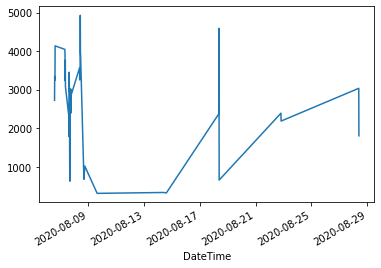

In [ ]:
#dados_SPEC_Per1Geo = dados_SPEC_validGeo[dados_Sniffer_Per1_Geo.index]
#dados_SPEC_Per1Geo['Value'].plot()
#dados_SPEC_Per1Geo

dados_SPEC_Per1Geo = dados_SPEC_validGeo[(dados_SPEC_validGeo.index >= 
                                  dados_Sniffer_Per1_Geo.index[0]) &
                                 (dados_SPEC_validGeo.index <= 
                                  dados_Sniffer_Per1_Geo.index[-1])]
dados_SPEC_Per1Geo['Value'].plot()
dados_SPEC_Per1Geo

#### Seleciona dados SPEC do Percurso 2

Year  Month  ...        Value                     geometry
DateTime                            ...                                          
2020-08-03 14:30:00  2020.0    8.0  ...  1587.585000  POINT (-48.52344 -27.60316)
2020-08-03 14:45:00  2020.0    8.0  ...  1760.820000  POINT (-48.52483 -27.60153)
2020-08-03 15:00:00  2020.0    8.0  ...  1672.694167  POINT (-48.51982 -27.59939)
2020-08-03 15:15:00  2020.0    8.0  ...  1686.266000  POINT (-48.51895 -27.60108)
2020-08-03 18:00:00  2020.0    8.0  ...  3048.000000  POINT (-48.51809 -27.60582)
...                     ...    ...  ...          ...                          ...
2020-08-14 14:30:00  2020.0    8.0  ...   323.500000  POINT (-48.51921 -27.60192)
2020-08-18 08:30:00  2020.0    8.0  ...  2369.167500  POINT (-48.51760 -27.60164)
2020-08-18 08:45:00  2020.0    8.0  ...  4590.002500  POINT (-48.52624 -27.61307)
2020-08-18 09:00:00  2020.0    8.0  ...  3855.123750  POINT (-48.52321 -27.61024)
2020-08-18 09:15:00  2020.0    8.0  ...   656.330000  POINT (-48.52342 -27.60315)

[65 rows x 8 columns]

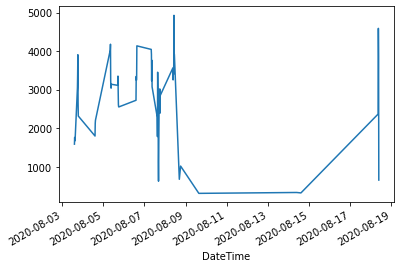

In [ ]:
dados_SPEC_Per2Geo = dados_SPEC_validGeo[(dados_SPEC_validGeo.index >= 
                                  dados_Sniffer_Per2_Geo.index[0]) &
                                 (dados_SPEC_validGeo.index <= 
                                  dados_Sniffer_Per2_Geo.index[-1])]
dados_SPEC_Per2Geo['Value'].plot()
dados_SPEC_Per2Geo

#### Seleciona dados SPEC do Percurso 3

Year  Month  ...        Value                     geometry
DateTime                            ...                                          
2020-08-03 18:00:00  2020.0    8.0  ...  3048.000000  POINT (-48.51809 -27.60582)
2020-08-03 18:15:00  2020.0    8.0  ...  3405.250833  POINT (-48.52375 -27.61071)
2020-08-03 18:30:00  2020.0    8.0  ...  3905.879091  POINT (-48.52396 -27.61072)
2020-08-03 18:45:00  2020.0    8.0  ...  2671.355000  POINT (-48.51959 -27.60395)
2020-08-03 19:00:00  2020.0    8.0  ...  2316.528333  POINT (-48.52049 -27.60190)
...                     ...    ...  ...          ...                          ...
2020-08-14 14:30:00  2020.0    8.0  ...   323.500000  POINT (-48.51921 -27.60192)
2020-08-18 08:30:00  2020.0    8.0  ...  2369.167500  POINT (-48.51760 -27.60164)
2020-08-18 08:45:00  2020.0    8.0  ...  4590.002500  POINT (-48.52624 -27.61307)
2020-08-18 09:00:00  2020.0    8.0  ...  3855.123750  POINT (-48.52321 -27.61024)
2020-08-18 09:15:00  2020.0    8.0  ...   656.330000  POINT (-48.52342 -27.60315)

[61 rows x 8 columns]

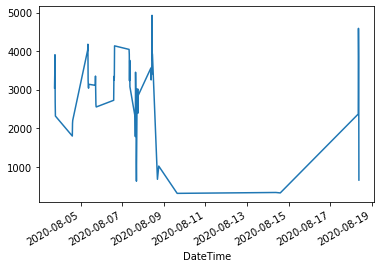

In [ ]:
dados_SPEC_Per3Geo = dados_SPEC_validGeo[(dados_SPEC_validGeo.index >= 
                                  dados_Sniffer_Per3_Geo.index[0]) &
                                 (dados_SPEC_validGeo.index <= 
                                  dados_Sniffer_Per3_Geo.index[-1])]
dados_SPEC_Per3Geo['Value'].plot()
dados_SPEC_Per3Geo

#### Mapas SPEC 2019

In [ ]:
location = dados_SPEC2019_valid[['Latitude', 'Longitude']].iloc[0]

m_5 = folium.Map(location=location, tiles='cartodbpositron', zoom_start=13)

# Add a heatmap to the base map
data = (dados_SPEC2019_valid[['Latitude', 'Longitude', 'CO(ppb)']].
        groupby(['Latitude', 'Longitude']).mean())

#data
HeatMap(data=data.reset_index().values.tolist(), radius=10, 
        max_val=data['CO(ppb)'].max()).add_to(m_5)

import branca.colormap as cm

colormap = cm.linear.viridis.scale(vmin=data['CO(ppb)'].min(), 
                                   vmax=data['CO(ppb)'].max())

colormap.caption = 'Concentration of Carbon Monoxide (ppb)'
m_5.add_child(colormap)

# Display the map
m_5

#### Mapas 2019 Green

In [ ]:
dados_SPEC_Green = dados_SPEC_2019Geo[dados_SPEC_2019Geo['Area Type']
                                            == 'GREEN']
location = dados_SPEC_Green[['Latitude', 'Longitude']].iloc[0]

#m_1 = folium.Map(location=location, tiles='openstreetmap', 
#                 zoom_start=10)
#m_1

m_5 = folium.Map(location=location, tiles='cartodbpositron', zoom_start=13)

# Add a heatmap to the base map
data = (dados_SPEC_Green[['Latitude', 'Longitude', 'CO(ppb)']].
        groupby(['Latitude', 'Longitude']).mean())

#data
HeatMap(data=data.reset_index().values.tolist(), radius=10, 
        max_val=data['CO(ppb)'].max()).add_to(m_5)

import branca.colormap as cm

colormap = cm.linear.viridis.scale(vmin=data['CO(ppb)'].min(), 
                                   vmax=data['CO(ppb)'].max())

colormap.caption = 'Concentration of Carbon Monoxide (ppb)'
m_5.add_child(colormap)

# Display the map
m_5

#### Estatísticas 2019 GREEN

Year      Month        Day  ...  Longitude      DeviceSt      CO(ppb)
count    18.0  18.000000  18.000000  ...  18.000000  1.800000e+01    18.000000
mean   2019.0   9.055556  26.555556  ... -48.476334  1.039065e+06  3500.853668
std       0.0   0.235702   6.128259  ...   0.002636  3.645784e+03  1203.171343
min    2019.0   9.000000   2.000000  ... -48.482521  1.033170e+06  1396.577000
25%    2019.0   9.000000  28.000000  ... -48.477633  1.038344e+06  3449.087500
50%    2019.0   9.000000  28.000000  ... -48.476889  1.039837e+06  3758.766644
75%    2019.0   9.000000  28.000000  ... -48.474333  1.039837e+06  3902.091409
max    2019.0  10.000000  28.000000  ... -48.471699  1.048319e+06  6563.250667

[8 rows x 8 columns]

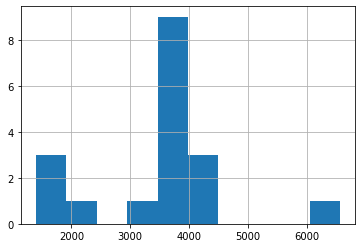

In [ ]:
dados_SPEC_2019Geo[dados_SPEC_2019Geo['Area Type'] == 'GREEN']['CO(ppb)'].hist()
dados_SPEC_2019Geo[dados_SPEC_2019Geo['Area Type'] == 'GREEN'].describe()

#### Mapas SPEC 2020

In [ ]:
location = dados_SPEC_validGeo[['Latitude', 'Longitude']].iloc[0]

#m_1 = folium.Map(location=location, tiles='openstreetmap', 
#                 zoom_start=10)
#m_1

m_5 = folium.Map(location=location, tiles='cartodbpositron', zoom_start=13)

# Add a heatmap to the base map
data = (dados_SPEC_validGeo[['Latitude', 'Longitude', 'Value']].
        groupby(['Latitude', 'Longitude']).mean())

HeatMap(data=data.reset_index().values.tolist(), min_opacity=1, blur=0, radius=10, 
        max_val=data['Value'].max()).add_to(m_5)

import branca.colormap as cm

colormap = cm.linear.viridis.scale(vmin=data['Value'].min(), 
                                   vmax=data['Value'].max())

colormap.caption = 'Concentration of Carbon Monoxide (ppb)'
m_5.add_child(colormap)

# Display the map
m_5

#### Mapas SPEC 2020 Residencial

In [ ]:
dados_SPEC_Residential = dados_SPEC_validGeo[dados_SPEC_validGeo['Area Type']
                                            == 'RESIDENTIAL']
location = dados_SPEC_Residential[['Latitude', 'Longitude']].iloc[0]

#m_1 = folium.Map(location=location, tiles='openstreetmap', 
#                 zoom_start=10)
#m_1

m_5 = folium.Map(location=location, tiles='cartodbpositron', zoom_start=13)

# Add a heatmap to the base map
data = (dados_SPEC_Residential[['Latitude', 'Longitude', 'Value']].
        groupby(['Latitude', 'Longitude']).mean())

#data
HeatMap(data=data.reset_index().values.tolist(), radius=10, 
        max_val=data['Value'].max()).add_to(m_5)

import branca.colormap as cm

colormap = cm.linear.viridis.scale(vmin=data['Value'].min(), 
                                   vmax=data['Value'].max())

colormap.caption = 'Concentration of Carbon Monoxide (ppb)'
m_5.add_child(colormap)

# Display the map
m_5

#### Estatísticas 2020 RESIDENTIAL

Year  Month         Day  ...    Latitude   Longitude        Value
count   247.0  247.0  247.000000  ...  247.000000  247.000000   247.000000
mean   2020.0    8.0    5.020243  ...  -27.602422  -48.521979  2780.161943
std       0.0    0.0    1.915808  ...    0.001078    0.001768   697.324920
min    2020.0    8.0    3.000000  ...  -27.604431  -48.524842   323.500000
25%    2020.0    8.0    4.000000  ...  -27.603156  -48.523300  2433.332500
50%    2020.0    8.0    5.000000  ...  -27.602369  -48.522315  2816.750000
75%    2020.0    8.0    5.000000  ...  -27.601819  -48.520812  3137.165000
max    2020.0    8.0   18.000000  ...  -27.594109  -48.512199  4794.170000

[8 rows x 7 columns]

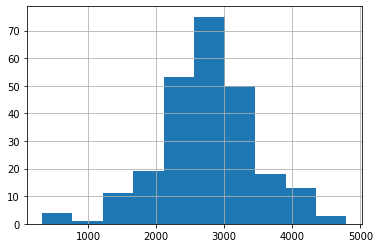

In [ ]:
dados_SPEC_validGeo[dados_SPEC_validGeo['Area Type']
                    == 'RESIDENTIAL']['Value'].hist()
dados_SPEC_validGeo[dados_SPEC_validGeo['Area Type']
                    == 'RESIDENTIAL'].describe()

#### Mapas SPEC 2020 Street

In [ ]:
dados_SPEC_Street = dados_SPEC_validGeo[dados_SPEC_validGeo['Area Type']
                                            == 'STREET']
location = dados_SPEC_Street[['Latitude', 'Longitude']].iloc[0]

#m_1 = folium.Map(location=location, tiles='openstreetmap', 
#                 zoom_start=10)
#m_1

m_5 = folium.Map(location=location, tiles='cartodbpositron', zoom_start=13)

# Add a heatmap to the base map
data = (dados_SPEC_Street[['Latitude', 'Longitude', 'Value']].
        groupby(['Latitude', 'Longitude']).mean())

#data
HeatMap(data=data.reset_index().values.tolist(), radius=10, 
        max_val=data['Value'].max()).add_to(m_5)

import branca.colormap as cm

colormap = cm.linear.viridis.scale(vmin=data['Value'].min(), 
                                   vmax=data['Value'].max())

colormap.caption = 'Concentration of Carbon Monoxide (ppb)'
m_5.add_child(colormap)

# Display the map
m_5

#### Estatísticas 2020 Street

Year  Month         Day  ...    Latitude   Longitude         Value
count   848.0  848.0  848.000000  ...  848.000000  848.000000    848.000000
mean   2020.0    8.0    6.787736  ...  -27.594525  -48.525647   2878.917606
std       0.0    0.0    4.728495  ...    0.011438    0.011632   1015.110744
min    2020.0    8.0    3.000000  ...  -27.628133  -48.562462    184.670000
25%    2020.0    8.0    4.000000  ...  -27.600564  -48.526829   2377.416250
50%    2020.0    8.0    7.000000  ...  -27.600099  -48.520183   2933.540000
75%    2020.0    8.0    7.000000  ...  -27.586459  -48.518424   3413.810000
max    2020.0    8.0   28.000000  ...  -27.571561  -48.509796  10626.000000

[8 rows x 7 columns]

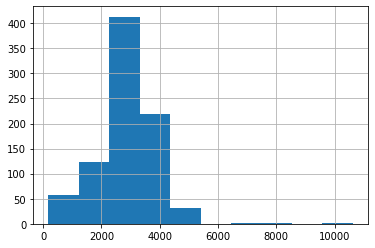

In [ ]:
dados_SPEC_validGeo[dados_SPEC_validGeo['Area Type']
                    == 'STREET']['Value'].hist()
dados_SPEC_validGeo[dados_SPEC_validGeo['Area Type']
                    == 'STREET'].describe()

### Análise por dias da semana e horário

In [ ]:
dados_RH_validGeo['Weekend'] = dados_RH_validGeo.index.map(
    lambda dt: True if dt.weekday() >= 5 else False)
dados_RH_validGeo['RushHr'] = dados_RH_validGeo['Hour'].map(
    lambda h: True if (h <= 10 or h >= 17) else False)
dados_RH_validGeo.head()

Year  Month  Day  ...    Area Type  Weekend  RushHr
DateTime                                 ...                              
2020-08-03 15:17:00  2020.0    8.0  3.0  ...  RESIDENTIAL    False   False
2020-08-03 15:18:00  2020.0    8.0  3.0  ...       STREET    False   False
2020-08-03 18:11:00  2020.0    8.0  3.0  ...       STREET    False    True
2020-08-03 18:12:00  2020.0    8.0  3.0  ...       STREET    False    True
2020-08-03 18:13:00  2020.0    8.0  3.0  ...       STREET    False    True

[5 rows x 11 columns]

In [ ]:
dados_SPEC_validGeo['Weekend'] = dados_SPEC_validGeo.index.map(
    lambda dt: True if dt.weekday() >= 5 else False)
dados_SPEC_validGeo['RushHr'] = dados_SPEC_validGeo['Hour'].map(
    lambda h: True if (h <= 10 or h >= 17) else False)
dados_SPEC_validGeo.head()

Year  Month  Day  ...  Area Type  Weekend  RushHr
DateTime                                 ...                            
2020-08-03 14:27:00  2020.0    8.0  3.0  ...     STREET    False   False
2020-08-03 14:28:00  2020.0    8.0  3.0  ...     STREET    False   False
2020-08-03 14:29:00  2020.0    8.0  3.0  ...     STREET    False   False
2020-08-03 14:30:00  2020.0    8.0  3.0  ...     STREET    False   False
2020-08-03 14:31:00  2020.0    8.0  3.0  ...     STREET    False   False

[5 rows x 11 columns]

#### Mapas SPEC 2020 Street dias da semana

In [ ]:
dados_map = dados_SPEC_validGeo[
                                (dados_SPEC_validGeo['Area Type'] == 'STREET') 
                                & (dados_SPEC_validGeo['Weekend'] == False)]
location = dados_map[['Latitude', 'Longitude']].iloc[0]

#m_1 = folium.Map(location=location, tiles='openstreetmap', 
#                 zoom_start=10)
#m_1

m_5 = folium.Map(location=location, tiles='cartodbpositron', zoom_start=13)

# Add a heatmap to the base map
data = (dados_map[['Latitude', 'Longitude', 'Value']].
        groupby(['Latitude', 'Longitude']).mean())

#data
HeatMap(data=data.reset_index().values.tolist(), radius=10, 
        max_val=data['Value'].max()).add_to(m_5)

import branca.colormap as cm

colormap = cm.linear.viridis.scale(vmin=data['Value'].min(), 
                                   vmax=data['Value'].max())

colormap.caption = 'Concentration of Carbon Monoxide (ppb)'
m_5.add_child(colormap)

# Display the map
m_5

#### Estatísticas 2020 Street dias da semana

Year  Month         Day  ...    Latitude   Longitude        Value
count   712.0  712.0  712.000000  ...  712.000000  712.000000   712.000000
mean   2020.0    8.0    6.164326  ...  -27.596193  -48.524281  2811.000787
std       0.0    0.0    4.473673  ...    0.010511    0.010767   947.172742
min    2020.0    8.0    3.000000  ...  -27.613471  -48.560672   274.500000
25%    2020.0    8.0    3.000000  ...  -27.600618  -48.525428  2355.748750
50%    2020.0    8.0    5.000000  ...  -27.600374  -48.518726  2903.000000
75%    2020.0    8.0    7.000000  ...  -27.589514  -48.518413  3353.065000
max    2020.0    8.0   28.000000  ...  -27.571561  -48.509796  7555.415000

[8 rows x 7 columns]

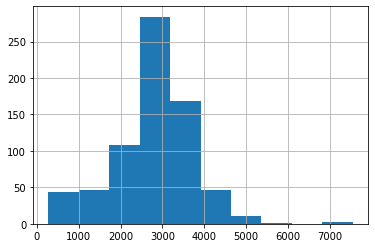

In [ ]:
dados_SPEC_validGeo[(dados_SPEC_validGeo['Area Type'] == 'STREET')
& (dados_SPEC_validGeo['Weekend'] == False)]['Value'].hist()
dados_SPEC_validGeo[(dados_SPEC_validGeo['Area Type'] == 'STREET')
& (dados_SPEC_validGeo['Weekend'] == False)].describe()

#### Mapas SPEC 2020 Street horários de Rush

In [ ]:
dados_map = dados_SPEC_validGeo[
                                (dados_SPEC_validGeo['Area Type'] == 'STREET') 
                                & (dados_SPEC_validGeo['RushHr'] == True)]
location = dados_map[['Latitude', 'Longitude']].iloc[0]

#m_1 = folium.Map(location=location, tiles='openstreetmap', 
#                 zoom_start=10)
#m_1

m_5 = folium.Map(location=location, tiles='cartodbpositron', zoom_start=13)

# Add a heatmap to the base map
data = (dados_map[['Latitude', 'Longitude', 'Value']].
        groupby(['Latitude', 'Longitude']).mean())

#data
HeatMap(data=data.reset_index().values.tolist(), radius=10, 
        max_val=data['Value'].max()).add_to(m_5)

import branca.colormap as cm

colormap = cm.linear.viridis.scale(vmin=data['Value'].min(), 
                                   vmax=data['Value'].max())

colormap.caption = 'Concentration of Carbon Monoxide (ppb)'
m_5.add_child(colormap)

# Display the map
m_5

#### Estatísticas 2020 Street horários de Rush

Year  Month        Day       Hour   Latitude  Longitude        Value
count    49.0   49.0  49.000000  49.000000  49.000000  49.000000    49.000000
mean   2020.0    8.0   8.653061  13.306122 -27.597116 -48.525044  3033.476889
std       0.0    0.0   6.743982   4.628733   0.011921   0.010347   815.362795
min    2020.0    8.0   3.000000   8.000000 -27.628133 -48.555306   334.830000
25%    2020.0    8.0   4.000000   9.000000 -27.601616 -48.526009  2746.983667
50%    2020.0    8.0   7.000000  10.000000 -27.600469 -48.521149  2938.550333
75%    2020.0    8.0   8.000000  18.000000 -27.589576 -48.518424  3462.755333
max    2020.0    8.0  28.000000  20.000000 -27.573029 -48.515068  4922.356000

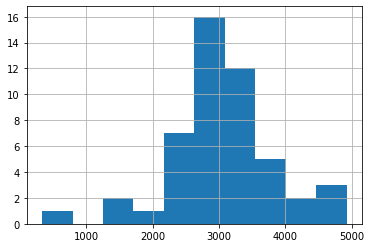

In [ ]:
dados_SPEC_validGeo[(dados_SPEC_validGeo['Area Type'] == 'STREET')
& (dados_SPEC_validGeo['RushHr'] == True)]['Value'].hist()
dados_SPEC_validGeo[(dados_SPEC_validGeo['Area Type'] == 'STREET')
& (dados_SPEC_validGeo['RushHr'] == True)].describe()

#### Mapas SPEC 2020 Street horários de No Rush

In [ ]:
dados_map = dados_SPEC_validGeo[
                                (dados_SPEC_validGeo['Area Type'] == 'STREET') 
                                & (dados_SPEC_validGeo['RushHr'] == False)]
location = dados_map[['Latitude', 'Longitude']].iloc[0]

#m_1 = folium.Map(location=location, tiles='openstreetmap', 
#                 zoom_start=10)
#m_1

m_5 = folium.Map(location=location, tiles='cartodbpositron', zoom_start=13)

# Add a heatmap to the base map
data = (dados_map[['Latitude', 'Longitude', 'Value']].
        groupby(['Latitude', 'Longitude']).mean())

#data
HeatMap(data=data.reset_index().values.tolist(), radius=10, 
        max_val=data['Value'].max()).add_to(m_5)

import branca.colormap as cm

colormap = cm.linear.viridis.scale(vmin=data['Value'].min(), 
                                   vmax=data['Value'].max())

colormap.caption = 'Concentration of Carbon Monoxide (ppb)'
m_5.add_child(colormap)

# Display the map
m_5

#### Estatísticas 2020 Street horários de No Rush

Year  Month         Day  ...    Latitude   Longitude        Value
count   280.0  280.0  280.000000  ...  280.000000  280.000000   280.000000
mean   2020.0    8.0    6.032143  ...  -27.590995  -48.526779  2319.289946
std       0.0    0.0    1.784753  ...    0.011303    0.012652   997.796024
min    2020.0    8.0    3.000000  ...  -27.613302  -48.560384   184.670000
25%    2020.0    8.0    4.000000  ...  -27.600120  -48.537263  1656.522500
50%    2020.0    8.0    6.000000  ...  -27.595836  -48.522561  2370.330000
75%    2020.0    8.0    7.000000  ...  -27.580362  -48.518190  3039.231250
max    2020.0    8.0    9.000000  ...  -27.571561  -48.509796  4580.170000

[8 rows x 7 columns]

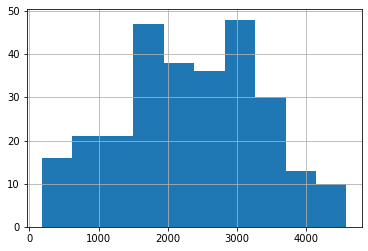

In [ ]:
dados_SPEC_validGeo[(dados_SPEC_validGeo['Area Type'] == 'STREET')
& (dados_SPEC_validGeo['RushHr'] == False)]['Value'].hist()
dados_SPEC_validGeo[(dados_SPEC_validGeo['Area Type'] == 'STREET')
& (dados_SPEC_validGeo['RushHr'] == False)].describe()

#### Mapas SPEC 2020 Street dias da semana horário de rush

In [ ]:
dados_map = dados_SPEC_validGeo[
                                (dados_SPEC_validGeo['Area Type'] == 'STREET') 
                                & (dados_SPEC_validGeo['Weekend'] == False) &
                                ((dados_SPEC_validGeo['RushHr'] == True))]
location = dados_map[['Latitude', 'Longitude']].iloc[0]

#m_1 = folium.Map(location=location, tiles='openstreetmap', 
#                 zoom_start=10)
#m_1

m_5 = folium.Map(location=location, tiles='cartodbpositron', zoom_start=13)

# Add a heatmap to the base map
data = (dados_map[['Latitude', 'Longitude', 'Value']].
        groupby(['Latitude', 'Longitude']).mean())

#data
HeatMap(data=data.reset_index().values.tolist(), radius=10, 
        max_val=data['Value'].max()).add_to(m_5)

import branca.colormap as cm

colormap = cm.linear.viridis.scale(vmin=data['Value'].min(), 
                                   vmax=data['Value'].max())

colormap.caption = 'Concentration of Carbon Monoxide (ppb)'
m_5.add_child(colormap)

# Display the map
m_5

#### Estatísticas 2020 Street dias da semana horário de rush

Year  Month         Day  ...    Latitude   Longitude        Value
count   470.0  470.0  470.000000  ...  470.000000  470.000000   470.000000
mean   2020.0    8.0    6.448936  ...  -27.598484  -48.523111  3086.219064
std       0.0    0.0    5.375510  ...    0.009276    0.009168   804.533940
min    2020.0    8.0    3.000000  ...  -27.613471  -48.560672   334.830000
25%    2020.0    8.0    3.000000  ...  -27.600856  -48.524261  2726.876250
50%    2020.0    8.0    5.000000  ...  -27.600469  -48.518726  3001.335000
75%    2020.0    8.0    7.000000  ...  -27.598385  -48.518424  3479.581250
max    2020.0    8.0   28.000000  ...  -27.571593  -48.514852  7555.415000

[8 rows x 7 columns]

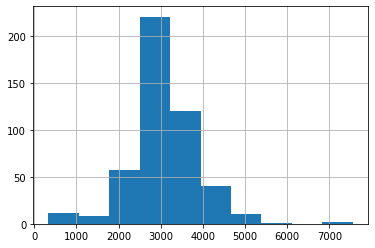

In [ ]:
dados_SPEC_validGeo[(dados_SPEC_validGeo['Area Type'] == 'STREET')
& (dados_SPEC_validGeo['Weekend'] == False) &
(dados_SPEC_validGeo['RushHr'] == True)]['Value'].hist()
dados_SPEC_validGeo[(dados_SPEC_validGeo['Area Type'] == 'STREET')
& (dados_SPEC_validGeo['Weekend'] == False) &
(dados_SPEC_validGeo['RushHr'] == True)].describe()

#### Mapas SPEC 2020 Street dias da semana horário de no rush

In [ ]:
dados_map = dados_SPEC_validGeo[
                                (dados_SPEC_validGeo['Area Type'] == 'STREET') 
                                & (dados_SPEC_validGeo['Weekend'] == False) &
                                ((dados_SPEC_validGeo['RushHr'] == False))]
location = dados_map[['Latitude', 'Longitude']].iloc[0]

#m_1 = folium.Map(location=location, tiles='openstreetmap', 
#                 zoom_start=10)
#m_1

m_5 = folium.Map(location=location, tiles='cartodbpositron', zoom_start=13)

# Add a heatmap to the base map
data = (dados_map[['Latitude', 'Longitude', 'Value']].
        groupby(['Latitude', 'Longitude']).mean())

#data
HeatMap(data=data.reset_index().values.tolist(), radius=10, 
        max_val=data['Value'].max()).add_to(m_5)

import branca.colormap as cm

colormap = cm.linear.viridis.scale(vmin=data['Value'].min(), 
                                   vmax=data['Value'].max())

colormap.caption = 'Concentration of Carbon Monoxide (ppb)'
m_5.add_child(colormap)

# Display the map
m_5

#### Estatísticas 2020 Street dias da semana horário de no rush

Year  Month        Day       Hour   Latitude  Longitude        Value
count    19.0   19.0  19.000000  19.000000  19.000000  19.000000    19.000000
mean   2020.0    8.0   5.631579  14.947368 -27.592351 -48.525173  2311.935558
std       0.0    0.0   1.570935   0.705036   0.010516   0.012046   877.499398
min    2020.0    8.0   3.000000  14.000000 -27.608194 -48.552386   667.066800
25%    2020.0    8.0   4.000000  14.500000 -27.600350 -48.528388  1714.716644
50%    2020.0    8.0   6.000000  15.000000 -27.598956 -48.518946  2203.105455
75%    2020.0    8.0   7.000000  15.000000 -27.582359 -48.517989  3060.017000
max    2020.0    8.0   7.000000  16.000000 -27.575920 -48.513256  3596.712727

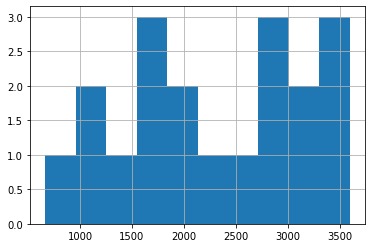

In [ ]:
dados_SPEC_validGeo[(dados_SPEC_validGeo['Area Type'] == 'STREET')
& (dados_SPEC_validGeo['Weekend'] == False) &
(dados_SPEC_validGeo['RushHr'] == False)]['Value'].hist()
dados_SPEC_validGeo[(dados_SPEC_validGeo['Area Type'] == 'STREET')
& (dados_SPEC_validGeo['Weekend'] == False) &
(dados_SPEC_validGeo['RushHr'] == False)].describe()

#### Mapas SPEC 2020 Street finais de semana

In [ ]:
dados_map = dados_SPEC_validGeo[
                                (dados_SPEC_validGeo['Area Type'] == 'STREET') 
                                & (dados_SPEC_validGeo['Weekend'] == True)]
location = dados_map[['Latitude', 'Longitude']].iloc[0]

#m_1 = folium.Map(location=location, tiles='openstreetmap', 
#                 zoom_start=10)
#m_1

m_5 = folium.Map(location=location, tiles='cartodbpositron', zoom_start=13)

# Add a heatmap to the base map
data = (dados_map[['Latitude', 'Longitude', 'Value']].
        groupby(['Latitude', 'Longitude']).mean())

#data
HeatMap(data=data.reset_index().values.tolist(), radius=10, 
        max_val=data['Value'].max()).add_to(m_5)

import branca.colormap as cm

colormap = cm.linear.viridis.scale(vmin=data['Value'].min(), 
                                   vmax=data['Value'].max())

colormap.caption = 'Concentration of Carbon Monoxide (ppb)'
m_5.add_child(colormap)

# Display the map
m_5

#### Estatísticas 2020 Street finais de semana

Year  Month        Day       Hour   Latitude  Longitude        Value
count    14.0   14.0  14.000000  14.000000  14.000000  14.000000    14.000000
mean   2020.0    8.0  11.214286  13.214286 -27.590865 -48.530853  2831.384766
std       0.0    0.0   5.859622   3.984172   0.016539   0.011103  1199.259294
min    2020.0    8.0   8.000000   9.000000 -27.628133 -48.554426   312.000000
25%    2020.0    8.0   8.000000  10.000000 -27.601878 -48.538276  2242.054731
50%    2020.0    8.0   8.000000  12.500000 -27.585974 -48.527011  2925.226583
75%    2020.0    8.0   9.000000  17.250000 -27.577012 -48.523793  3527.501333
max    2020.0    8.0  22.000000  19.000000 -27.573029 -48.515068  4922.356000

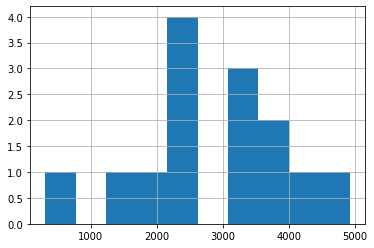

In [ ]:
dados_SPEC_validGeo[(dados_SPEC_validGeo['Area Type'] == 'STREET')
& (dados_SPEC_validGeo['Weekend'] == True)]['Value'].hist()
dados_SPEC_validGeo[(dados_SPEC_validGeo['Area Type'] == 'STREET')
& (dados_SPEC_validGeo['Weekend'] == True)].describe()

#### Mapas SPEC 2020 Street finais de semana horário de rush

In [ ]:
dados_map = dados_SPEC_validGeo[
                                (dados_SPEC_validGeo['Area Type'] == 'STREET') 
                                & (dados_SPEC_validGeo['Weekend'] == True) &
                                (dados_SPEC_validGeo['RushHr'] == True)]
location = dados_map[['Latitude', 'Longitude']].iloc[0]

#m_1 = folium.Map(location=location, tiles='openstreetmap', 
#                 zoom_start=10)
#m_1

m_5 = folium.Map(location=location, tiles='cartodbpositron', zoom_start=13)

# Add a heatmap to the base map
data = (dados_map[['Latitude', 'Longitude', 'Value']].
        groupby(['Latitude', 'Longitude']).mean())

#data
HeatMap(data=data.reset_index().values.tolist(), radius=10, 
        max_val=data['Value'].max()).add_to(m_5)

import branca.colormap as cm

colormap = cm.linear.viridis.scale(vmin=data['Value'].min(), 
                                   vmax=data['Value'].max())

colormap.caption = 'Concentration of Carbon Monoxide (ppb)'
m_5.add_child(colormap)

# Display the map
m_5

#### Estatísticas 2020 Street finais de semana horário de rush

Year  Month        Day       Hour   Latitude  Longitude        Value
count    10.0   10.0  10.000000  10.000000  10.000000  10.000000    10.000000
mean   2020.0    8.0  12.200000  13.100000 -27.591080 -48.532126  3092.886707
std       0.0    0.0   6.762642   4.677369   0.018680   0.012099   988.817803
min    2020.0    8.0   8.000000   9.000000 -27.628133 -48.554426  1330.920000
25%    2020.0    8.0   8.000000   9.250000 -27.605452 -48.538276  2458.890817
50%    2020.0    8.0   8.000000  10.000000 -27.584272 -48.529081  3339.663333
75%    2020.0    8.0  18.500000  18.000000 -27.576808 -48.523793  3527.501333
max    2020.0    8.0  22.000000  19.000000 -27.573029 -48.515068  4922.356000

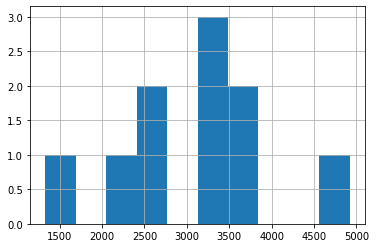

In [ ]:
dados_SPEC_validGeo[(dados_SPEC_validGeo['Area Type'] == 'STREET')
& (dados_SPEC_validGeo['Weekend'] == True) &
(dados_SPEC_validGeo['RushHr'] == True)]['Value'].hist()
dados_SPEC_validGeo[(dados_SPEC_validGeo['Area Type'] == 'STREET')
& (dados_SPEC_validGeo['Weekend'] == True) &
(dados_SPEC_validGeo['RushHr'] == True)].describe()

#### Mapas SPEC 2020 Street finais de semana horário de no rush

In [ ]:
dados_map = dados_SPEC_validGeo[
                                (dados_SPEC_validGeo['Area Type'] == 'STREET') 
                                & (dados_SPEC_validGeo['Weekend'] == True) &
                                ((dados_SPEC_validGeo['RushHr'] == False))]
location = dados_map[['Latitude', 'Longitude']].iloc[0]

#m_1 = folium.Map(location=location, tiles='openstreetmap', 
#                 zoom_start=10)
#m_1

m_5 = folium.Map(location=location, tiles='cartodbpositron', zoom_start=13)

# Add a heatmap to the base map
data = (dados_map[['Latitude', 'Longitude', 'Value']].
        groupby(['Latitude', 'Longitude']).mean())

#data
HeatMap(data=data.reset_index().values.tolist(), radius=10, 
        max_val=data['Value'].max()).add_to(m_5)

import branca.colormap as cm

colormap = cm.linear.viridis.scale(vmin=data['Value'].min(), 
                                   vmax=data['Value'].max())

colormap.caption = 'Concentration of Carbon Monoxide (ppb)'
m_5.add_child(colormap)

# Display the map
m_5

#### Estatísticas 2020 Street finais de semana horário de no rush

Year  Month   Day       Hour   Latitude  Longitude        Value
count     4.0    4.0  4.00   4.000000   4.000000   4.000000     4.000000
mean   2020.0    8.0  8.75  13.500000 -27.590326 -48.527670  2177.629916
std       0.0    0.0  0.50   1.732051   0.011741   0.008724  1581.522157
min    2020.0    8.0  8.00  11.000000 -27.603448 -48.540275   312.000000
25%    2020.0    8.0  8.75  13.250000 -27.597739 -48.529005  1572.185100
50%    2020.0    8.0  9.00  14.000000 -27.590587 -48.525125  2112.232054
75%    2020.0    8.0  9.00  14.250000 -27.583175 -48.523790  2717.676870
max    2020.0    8.0  9.00  15.000000 -27.576683 -48.520155  4174.055556

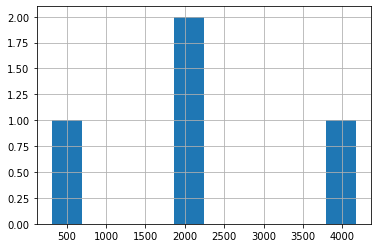

In [ ]:
dados_SPEC_validGeo[(dados_SPEC_validGeo['Area Type'] == 'STREET')
& (dados_SPEC_validGeo['Weekend'] == True) &
(dados_SPEC_validGeo['RushHr'] == False)]['Value'].hist()
dados_SPEC_validGeo[(dados_SPEC_validGeo['Area Type'] == 'STREET')
& (dados_SPEC_validGeo['Weekend'] == True) &
(dados_SPEC_validGeo['RushHr'] == False)].describe()

#### Mapas SPEC 2020 Residencial dias da semana

In [ ]:
dados_map = dados_SPEC_validGeo[
                                (dados_SPEC_validGeo['Area Type'] == 'RESIDENTIAL') 
                                & (dados_SPEC_validGeo['Weekend'] == False)]
location = dados_map[['Latitude', 'Longitude']].iloc[0]

#m_1 = folium.Map(location=location, tiles='openstreetmap', 
#                 zoom_start=10)
#m_1

m_5 = folium.Map(location=location, tiles='cartodbpositron', zoom_start=13)

# Add a heatmap to the base map
data = (dados_map[['Latitude', 'Longitude', 'Value']].
        groupby(['Latitude', 'Longitude']).mean())

#data
HeatMap(data=data.reset_index().values.tolist(), radius=10, 
        max_val=data['Value'].max()).add_to(m_5)

import branca.colormap as cm

colormap = cm.linear.viridis.scale(vmin=data['Value'].min(), 
                                   vmax=data['Value'].max())

colormap.caption = 'Concentration of Carbon Monoxide (ppb)'
m_5.add_child(colormap)

# Display the map
m_5

#### Estatísticas 2020 Residencial dias da semana

Year  Month        Day       Hour   Latitude  Longitude        Value
count    14.0   14.0  14.000000  14.000000  14.000000  14.000000    14.000000
mean   2020.0    8.0   5.714286  14.214286 -27.601940 -48.522424  2524.901023
std       0.0    0.0   3.750458   4.060666   0.001266   0.001551   836.533121
min    2020.0    8.0   3.000000   8.000000 -27.603356 -48.524825   656.330000
25%    2020.0    8.0   4.250000  10.250000 -27.602762 -48.523434  1927.870583
50%    2020.0    8.0   5.000000  15.500000 -27.602038 -48.522632  2587.534683
75%    2020.0    8.0   5.000000  17.000000 -27.601595 -48.521284  3105.833750
max    2020.0    8.0  18.000000  19.000000 -27.598428 -48.519928  3762.436154

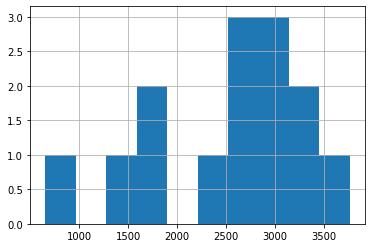

In [ ]:
dados_SPEC_validGeo[(dados_SPEC_validGeo['Area Type'] == 'RESIDENTIAL')
& (dados_SPEC_validGeo['Weekend'] == False)]['Value'].hist()
dados_SPEC_validGeo[(dados_SPEC_validGeo['Area Type'] == 'RESIDENTIAL')
& (dados_SPEC_validGeo['Weekend'] == False)].describe()

#### Mapas SPEC 2020 Street finais de semana

In [ ]:
dados_map = dados_SPEC_validGeo[
                                (dados_SPEC_validGeo['Area Type'] == 'RESIDENTIAL') 
                                & (dados_SPEC_validGeo['Weekend'] == True)]
location = dados_map[['Latitude', 'Longitude']].iloc[0]

#m_1 = folium.Map(location=location, tiles='openstreetmap', 
#                 zoom_start=10)
#m_1

m_5 = folium.Map(location=location, tiles='cartodbpositron', zoom_start=13)

# Add a heatmap to the base map
data = (dados_map[['Latitude', 'Longitude', 'Value']].
        groupby(['Latitude', 'Longitude']).mean())

#data
HeatMap(data=data.reset_index().values.tolist(), radius=10, 
        max_val=data['Value'].max()).add_to(m_5)

import branca.colormap as cm

colormap = cm.linear.viridis.scale(vmin=data['Value'].min(), 
                                   vmax=data['Value'].max())

colormap.caption = 'Concentration of Carbon Monoxide (ppb)'
m_5.add_child(colormap)

# Display the map
m_5

#### Estatísticas 2020 Residenciais finais de semana

Year  Month       Day       Hour   Latitude  Longitude        Value
count     3.0    3.0  3.000000   3.000000   3.000000   3.000000     3.000000
mean   2020.0    8.0  8.333333  12.000000 -27.601801 -48.523224  2722.629750
std       0.0    0.0  0.577350   2.645751   0.001857   0.001761  2087.772279
min    2020.0    8.0  8.000000  10.000000 -27.603448 -48.525249   312.000000
25%    2020.0    8.0  8.000000  10.500000 -27.602807 -48.523813  2109.469375
50%    2020.0    8.0  8.000000  11.000000 -27.602167 -48.522377  3906.938750
75%    2020.0    8.0  8.500000  13.000000 -27.600978 -48.522212  3927.944625
max    2020.0    8.0  9.000000  15.000000 -27.599789 -48.522047  3948.950500

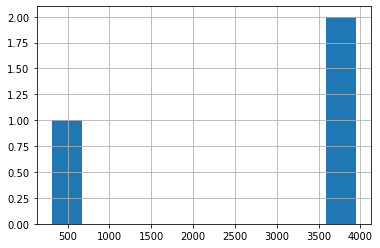

In [ ]:
dados_SPEC_validGeo[(dados_SPEC_validGeo['Area Type'] == 'RESIDENTIAL')
& (dados_SPEC_validGeo['Weekend'] == True)]['Value'].hist()
dados_SPEC_validGeo[(dados_SPEC_validGeo['Area Type'] == 'RESIDENTIAL')
& (dados_SPEC_validGeo['Weekend'] == True)].describe()

#### Mapas SPEC 2020 Residencial finais de semana horários de Rush

In [ ]:
dados_map = dados_SPEC_validGeo[
                                (dados_SPEC_validGeo['Area Type'] == 'RESIDENTIAL') 
                                & (dados_SPEC_validGeo['Weekend'] == True) &
                                (dados_SPEC_validGeo['RushHr'] == True)]
location = dados_map[['Latitude', 'Longitude']].iloc[0]

#m_1 = folium.Map(location=location, tiles='openstreetmap', 
#                 zoom_start=10)
#m_1

m_5 = folium.Map(location=location, tiles='cartodbpositron', zoom_start=13)

# Add a heatmap to the base map
data = (dados_map[['Latitude', 'Longitude', 'Value']].
        groupby(['Latitude', 'Longitude']).mean())

#data
HeatMap(data=data.reset_index().values.tolist(), radius=10, 
        max_val=data['Value'].max()).add_to(m_5)

import branca.colormap as cm

colormap = cm.linear.viridis.scale(vmin=data['Value'].min(), 
                                   vmax=data['Value'].max())

colormap.caption = 'Concentration of Carbon Monoxide (ppb)'
m_5.add_child(colormap)

# Display the map
m_5

#### Estatísticas 2020 Residencial finais de semana horários de rush

Year  Month  Day  Hour  Latitude  Longitude        Value
count     1.0    1.0  1.0   1.0   1.00000   1.000000     1.000000
mean   2020.0    8.0  8.0  10.0 -27.60215 -48.521918  3929.350333
std       NaN    NaN  NaN   NaN       NaN        NaN          NaN
min    2020.0    8.0  8.0  10.0 -27.60215 -48.521918  3929.350333
25%    2020.0    8.0  8.0  10.0 -27.60215 -48.521918  3929.350333
50%    2020.0    8.0  8.0  10.0 -27.60215 -48.521918  3929.350333
75%    2020.0    8.0  8.0  10.0 -27.60215 -48.521918  3929.350333
max    2020.0    8.0  8.0  10.0 -27.60215 -48.521918  3929.350333

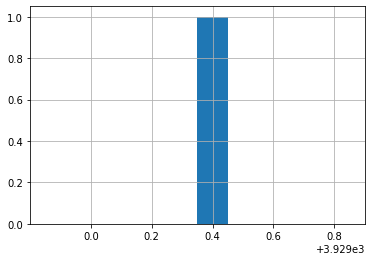

In [ ]:
dados_SPEC_validGeo[(dados_SPEC_validGeo['Area Type'] == 'RESIDENTIAL')
& (dados_SPEC_validGeo['Weekend'] == True) 
& (dados_SPEC_validGeo['RushHr'] == True)]['Value'].hist()
dados_SPEC_validGeo[(dados_SPEC_validGeo['Area Type'] == 'RESIDENTIAL')
& (dados_SPEC_validGeo['Weekend'] == True) 
& (dados_SPEC_validGeo['RushHr'] == True)].describe()

#### Mapas SPEC 2020 Residencial finais de semana horários de No Rush

In [ ]:
dados_map = dados_SPEC_validGeo[
                                (dados_SPEC_validGeo['Area Type'] == 'RESIDENTIAL') 
                                & (dados_SPEC_validGeo['Weekend'] == True) &
                                (dados_SPEC_validGeo['RushHr'] == False)]
location = dados_map[['Latitude', 'Longitude']].iloc[0]

#m_1 = folium.Map(location=location, tiles='openstreetmap', 
#                 zoom_start=10)
#m_1

m_5 = folium.Map(location=location, tiles='cartodbpositron', zoom_start=13)

# Add a heatmap to the base map
data = (dados_map[['Latitude', 'Longitude', 'Value']].
        groupby(['Latitude', 'Longitude']).mean())

#data
HeatMap(data=data.reset_index().values.tolist(), radius=10, 
        max_val=data['Value'].max()).add_to(m_5)

import branca.colormap as cm

colormap = cm.linear.viridis.scale(vmin=data['Value'].min(), 
                                   vmax=data['Value'].max())

colormap.caption = 'Concentration of Carbon Monoxide (ppb)'
m_5.add_child(colormap)

# Display the map
m_5

#### Estatísticas 2020 Residencial finais de semana horários de rush

Year  Month  Day       Hour   Latitude  Longitude        Value
count     2.0    2.0  2.0   2.000000   2.000000   2.000000     2.000000
mean   2020.0    8.0  8.0  13.500000 -27.602020 -48.521154  2275.260690
std       0.0    0.0  0.0   3.535534   0.002525   0.001789  2260.748634
min    2020.0    8.0  8.0  11.000000 -27.603805 -48.522420   676.670000
25%    2020.0    8.0  8.0  12.250000 -27.602912 -48.521787  1475.965345
50%    2020.0    8.0  8.0  13.500000 -27.602020 -48.521154  2275.260690
75%    2020.0    8.0  8.0  14.750000 -27.601127 -48.520522  3074.556034
max    2020.0    8.0  8.0  16.000000 -27.600234 -48.519889  3873.851379

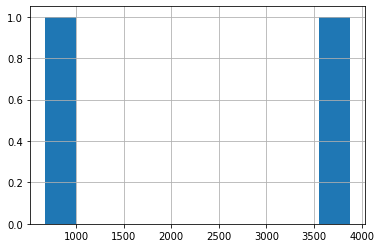

In [ ]:
dados_SPEC_validGeo[(dados_SPEC_validGeo['Area Type'] == 'RESIDENTIAL')
& (dados_SPEC_validGeo['Weekend'] == True) 
& (dados_SPEC_validGeo['RushHr'] == False)]['Value'].hist()
dados_SPEC_validGeo[(dados_SPEC_validGeo['Area Type'] == 'RESIDENTIAL')
& (dados_SPEC_validGeo['Weekend'] == True) 
& (dados_SPEC_validGeo['RushHr'] == False)].describe()

#### Mapas Sniffer

In [ ]:
location = dados_Sniffer_Geo[['Latitude', 'Longitude']].iloc[0]

#m_1 = folium.Map(location=location, tiles='openstreetmap', 
#                 zoom_start=10)
#m_1

m_5 = folium.Map(location=location, tiles='cartodbpositron', zoom_start=13)

# Add a heatmap to the base map
data = (dados_Sniffer_Geo[['Latitude', 'Longitude', 'CO']].
        groupby(['Latitude', 'Longitude']).mean()).dropna(how='all')

#data
HeatMap(data=data.reset_index().values.tolist(), radius=10, 
        max_val=data['CO'].max()).add_to(m_5)

import branca.colormap as cm

colormap = cm.linear.viridis.scale(vmin=data['CO'].min(), 
                                   vmax=data['CO'].max())

colormap.caption = 'Concentration of Carbon Monoxide (ppb)'
m_5.add_child(colormap)

# Display the map
m_5

#### Mapas Sniffer Residencial

In [ ]:
dados_map = dados_Sniffer_Geo[dados_Sniffer_Geo['Area Type']
                                            == 'RESIDENTIAL']
location = dados_map[['Latitude', 'Longitude']].iloc[0]

#m_1 = folium.Map(location=location, tiles='openstreetmap', 
#                 zoom_start=10)
#m_1

m_5 = folium.Map(location=location, tiles='cartodbpositron', zoom_start=13)

# Add a heatmap to the base map
data = (dados_map[['Latitude', 'Longitude', 'CO']].
        groupby(['Latitude', 'Longitude']).mean())

#data
HeatMap(data=data.reset_index().values.tolist(), radius=10, 
        max_val=data['CO'].max()).add_to(m_5)

import branca.colormap as cm

colormap = cm.linear.viridis.scale(vmin=data['CO'].min(), 
                                   vmax=data['CO'].max())

colormap.caption = 'Concentration of Carbon Monoxide (ppb)'
m_5.add_child(colormap)

# Display the map
m_5

#### Estatísticas 2020 RESIDENTIAL

Longitude    Latitude  Temperature    Humidity          CO
count  213.000000  213.000000   213.000000  213.000000  213.000000
mean   -48.521733  -27.602204    19.912920   67.703251    0.588157
std      0.003186    0.001817     2.694931    8.895067    0.563238
min    -48.525275  -27.604508    12.360137   49.176471    0.274066
25%    -48.523381  -27.603186    18.606209   63.158497    0.369336
50%    -48.522638  -27.602312    19.954248   68.934640    0.494200
75%    -48.520717  -27.601733    21.269608   73.303922    0.552508
max    -48.503469  -27.590389    25.686274   85.712419    4.132662

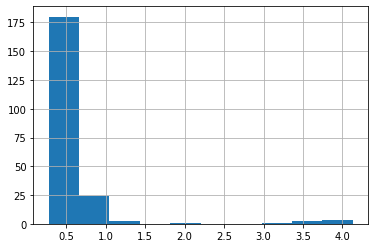

In [ ]:
dados_Sniffer_Geo[dados_Sniffer_Geo['Area Type']
                    == 'RESIDENTIAL']['CO'].hist()
dados_Sniffer_Geo[dados_Sniffer_Geo['Area Type']
                    == 'RESIDENTIAL'].describe()

#### Mapas Sniffer Street

In [ ]:
dados_map = dados_Sniffer_Geo[dados_Sniffer_Geo['Area Type']
                                            == 'STREET']
location = dados_map[['Latitude', 'Longitude']].iloc[0]

#m_1 = folium.Map(location=location, tiles='openstreetmap', 
#                 zoom_start=10)
#m_1

m_5 = folium.Map(location=location, tiles='cartodbpositron', zoom_start=13)

# Add a heatmap to the base map
data = (dados_map[['Latitude', 'Longitude', 'CO']].
        groupby(['Latitude', 'Longitude']).mean())

#data
HeatMap(data=data.reset_index().values.tolist(), radius=10, 
        max_val=data['CO'].max()).add_to(m_5)

import branca.colormap as cm

colormap = cm.linear.viridis.scale(vmin=data['CO'].min(), 
                                   vmax=data['CO'].max())

colormap.caption = 'Concentration of Carbon Monoxide (ppb)'
m_5.add_child(colormap)

# Display the map
m_5

#### Estatísticas 2020 Street

Longitude    Latitude  Temperature    Humidity          CO
count  614.000000  614.000000   614.000000  614.000000  614.000000
mean   -48.524071  -27.598457    19.766581   64.919733    0.884271
std      0.010312    0.012111     3.735085    9.912306    0.689148
min    -48.560771  -27.627317    12.549020   46.024510    0.261450
25%    -48.525729  -27.604924    17.254902   56.140115    0.478339
50%    -48.521271  -27.600385    19.861928   64.464126    0.672425
75%    -48.518223  -27.591255    22.255356   71.743175    1.005650
max    -48.508882  -27.571745    27.651961   86.139948    5.242079

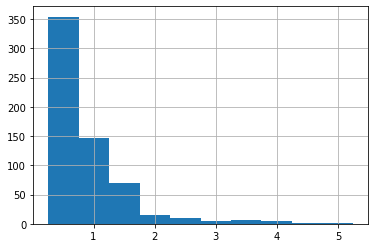

In [ ]:
dados_Sniffer_Geo[dados_Sniffer_Geo['Area Type']
                    == 'STREET']['CO'].hist()
dados_Sniffer_Geo[dados_Sniffer_Geo['Area Type']
                    == 'STREET'].describe()

### Análise por dias da semana e horário

In [ ]:
dados_Sniffer_Geo['Weekend'] = dados_Sniffer_Geo.index.map(
    lambda dt: True if dt.weekday() >= 5 else False)
dados_Sniffer_Geo['RushHr'] = dados_Sniffer_Geo.index.map(
    lambda dt: True if (dt.hour <= 10 or dt.hour >= 17) else False)
dados_Sniffer_Geo['Hour'] = dados_Sniffer_Geo.index.map(
    lambda dt: dt.hour)
dados_Sniffer_Geo.head()

Longitude   Latitude  Temperature  ...  Weekend  RushHr Hour
Time Stamp                                              ...                      
2020-08-03 14:28:00 -48.518220 -27.600500    23.860054  ...    False   False   14
2020-08-03 14:29:00 -48.518300 -27.600447    23.686275  ...    False   False   14
2020-08-03 14:30:00 -48.517937 -27.600635    23.411765  ...    False   False   14
2020-08-03 14:31:00 -48.517980 -27.600715    23.529411  ...    False   False   14
2020-08-03 14:33:00 -48.518681 -27.600776    22.983468  ...    False   False   14

[5 rows x 10 columns]

#### Mapas Sniffer Street Weekday

In [ ]:
dados_map = dados_Sniffer_Geo[
                              (dados_Sniffer_Geo['Area Type'] == 'STREET')
                              & (dados_Sniffer_Geo['Weekend'] == False)]
location = dados_map[['Latitude', 'Longitude']].iloc[0]

#m_1 = folium.Map(location=location, tiles='openstreetmap', 
#                 zoom_start=10)
#m_1

m_5 = folium.Map(location=location, tiles='cartodbpositron', zoom_start=13)

# Add a heatmap to the base map
data = (dados_map[['Latitude', 'Longitude', 'CO']].
        groupby(['Latitude', 'Longitude']).mean())

#data
HeatMap(data=data.reset_index().values.tolist(), radius=10, 
        max_val=data['CO'].max()).add_to(m_5)

import branca.colormap as cm

colormap = cm.linear.viridis.scale(vmin=data['CO'].min(), 
                                   vmax=data['CO'].max())

colormap.caption = 'Concentration of Carbon Monoxide (ppb)'
m_5.add_child(colormap)

# Display the map
m_5

#### Estatísticas Street Weekday

Longitude    Latitude  Temperature    Humidity          CO
count  342.000000  342.000000   342.000000  342.000000  342.000000
mean   -48.522668  -27.598261    19.413803   66.671964    0.903922
std      0.010027    0.009213     3.700624   10.751340    0.706692
min    -48.560581  -27.613404    12.549020   46.816993    0.261450
25%    -48.524221  -27.601887    16.675244   55.931373    0.467009
50%    -48.518889  -27.600377    20.041667   66.845588    0.725680
75%    -48.517765  -27.597840    21.660540   76.218760    1.010892
max    -48.509750  -27.571950    26.526144   86.139948    4.643158

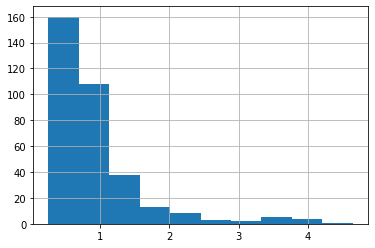

In [ ]:
dados_Sniffer_Geo[(dados_Sniffer_Geo['Area Type'] == 'STREET')
& (dados_Sniffer_Geo['Weekend'] == False)]['CO'].hist()
dados_Sniffer_Geo[(dados_Sniffer_Geo['Area Type'] == 'STREET')
& (dados_Sniffer_Geo['Weekend'] == False)].describe()

#### Mapas Sniffer Street Weekend

In [ ]:
dados_map = dados_Sniffer_Geo[
                              (dados_Sniffer_Geo['Area Type'] == 'STREET')
                              & (dados_Sniffer_Geo['Weekend'] == True)]
location = dados_map[['Latitude', 'Longitude']].iloc[0]

#m_1 = folium.Map(location=location, tiles='openstreetmap', 
#                 zoom_start=10)
#m_1

m_5 = folium.Map(location=location, tiles='cartodbpositron', zoom_start=13)

# Add a heatmap to the base map
data = (dados_map[['Latitude', 'Longitude', 'CO']].
        groupby(['Latitude', 'Longitude']).mean())

#data
HeatMap(data=data.reset_index().values.tolist(), radius=10, 
        max_val=data['CO'].max()).add_to(m_5)

import branca.colormap as cm

colormap = cm.linear.viridis.scale(vmin=data['CO'].min(), 
                                   vmax=data['CO'].max())

colormap.caption = 'Concentration of Carbon Monoxide (ppb)'
m_5.add_child(colormap)

# Display the map
m_5

#### Estatísticas Street Weekend

Longitude    Latitude  Temperature    Humidity          CO
count  272.000000  272.000000   272.000000  272.000000  272.000000
mean   -48.525835  -27.598703    20.210148   62.716559    0.859563
std      0.010413    0.014996     3.737677    8.249481    0.666906
min    -48.560771  -27.627317    14.245098   46.024510    0.295085
25%    -48.527020  -27.608918    17.430556   56.854165    0.489020
50%    -48.522735  -27.600413    19.060458   62.183007    0.625308
75%    -48.518549  -27.587353    24.180556   69.259804    0.991496
max    -48.508882  -27.571745    27.651961   84.179740    5.242079

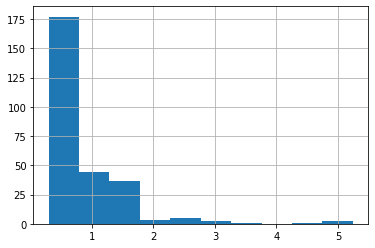

In [ ]:
dados_Sniffer_Geo[(dados_Sniffer_Geo['Area Type'] == 'STREET')
& (dados_Sniffer_Geo['Weekend'] == True)]['CO'].hist()
dados_Sniffer_Geo[(dados_Sniffer_Geo['Area Type'] == 'STREET')
& (dados_Sniffer_Geo['Weekend'] == True)].describe()

#### Mapas Sniffer Street Weekday horários de Rush

In [ ]:
dados_map = dados_Sniffer_Geo[
                              (dados_Sniffer_Geo['Area Type'] == 'STREET')
                              & (dados_Sniffer_Geo['Weekend'] == False)
                              & (dados_Sniffer_Geo['RushHr'] == True)]
location = dados_map[['Latitude', 'Longitude']].iloc[0]

#m_1 = folium.Map(location=location, tiles='openstreetmap', 
#                 zoom_start=10)
#m_1

m_5 = folium.Map(location=location, tiles='cartodbpositron', zoom_start=13)

# Add a heatmap to the base map
data = (dados_map[['Latitude', 'Longitude', 'CO']].
        groupby(['Latitude', 'Longitude']).mean())

#data
HeatMap(data=data.reset_index().values.tolist(), radius=10, 
        max_val=data['CO'].max()).add_to(m_5)

import branca.colormap as cm

colormap = cm.linear.viridis.scale(vmin=data['CO'].min(), 
                                   vmax=data['CO'].max())

colormap.caption = 'Concentration of Carbon Monoxide (ppb)'
m_5.add_child(colormap)

# Display the map
m_5

#### Estatísticas Street Weekday horários de Rush

Longitude    Latitude  Temperature    Humidity          CO
count  279.000000  279.000000   279.000000  279.000000  279.000000
mean   -48.521777  -27.599846    18.314838   69.427831    0.975717
std      0.009076    0.008156     3.129076    9.751735    0.750463
min    -48.557768  -27.613404    12.549020   49.882353    0.261450
25%    -48.523319  -27.604051    14.509804   62.923867    0.517583
50%    -48.518867  -27.600452    19.545923   71.083100    0.792599
75%    -48.517553  -27.599372    20.588236   77.590687    1.120631
max    -48.513008  -27.572294    23.725491   86.139948    4.643158

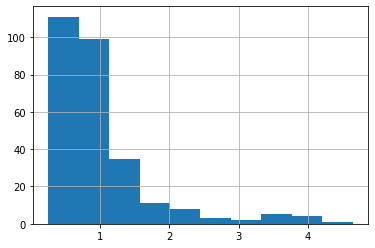

In [ ]:
dados_Sniffer_Geo[(dados_Sniffer_Geo['Area Type'] == 'STREET')
& (dados_Sniffer_Geo['Weekend'] == False)
& (dados_Sniffer_Geo['RushHr'] == True)]['CO'].hist()
dados_Sniffer_Geo[(dados_Sniffer_Geo['Area Type'] == 'STREET')
& (dados_Sniffer_Geo['Weekend'] == False)
& (dados_Sniffer_Geo['RushHr'] == True)].describe()

#### Mapas Sniffer Street Weekday horários de No Rush

In [ ]:
dados_map = dados_Sniffer_Geo[
                              (dados_Sniffer_Geo['Area Type'] == 'STREET')
                              & (dados_Sniffer_Geo['Weekend'] == False)
                              & (dados_Sniffer_Geo['RushHr'] == False)]
location = dados_map[['Latitude', 'Longitude']].iloc[0]

#m_1 = folium.Map(location=location, tiles='openstreetmap', 
#                 zoom_start=10)
#m_1

m_5 = folium.Map(location=location, tiles='cartodbpositron', zoom_start=13)

# Add a heatmap to the base map
data = (dados_map[['Latitude', 'Longitude', 'CO']].
        groupby(['Latitude', 'Longitude']).mean())

#data
HeatMap(data=data.reset_index().values.tolist(), radius=10, 
        max_val=data['CO'].max()).add_to(m_5)

import branca.colormap as cm

colormap = cm.linear.viridis.scale(vmin=data['CO'].min(), 
                                   vmax=data['CO'].max())

colormap.caption = 'Concentration of Carbon Monoxide (ppb)'
m_5.add_child(colormap)

# Display the map
m_5

#### Estatísticas Street Weekday horários de No Rush

Longitude   Latitude  Temperature   Humidity         CO
count  63.000000  63.000000    63.000000  63.000000  63.000000
mean  -48.526615 -27.591243    24.280646  54.467412   0.585975
std     0.012816   0.010351     1.383958   4.880817   0.309146
min   -48.560581 -27.601951    21.568628  46.816993   0.312280
25%   -48.532391 -27.600468    23.725491  50.750000   0.399676
50%   -48.519986 -27.597022    24.199347  53.806228   0.478006
75%   -48.518264 -27.581612    25.260181  58.279412   0.616275
max   -48.509750 -27.571950    26.526144  64.599672   1.754775

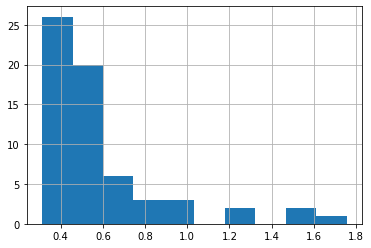

In [ ]:
dados_Sniffer_Geo[(dados_Sniffer_Geo['Area Type'] == 'STREET')
& (dados_Sniffer_Geo['Weekend'] == False)
& (dados_Sniffer_Geo['RushHr'] == False)]['CO'].hist()
dados_Sniffer_Geo[(dados_Sniffer_Geo['Area Type'] == 'STREET')
& (dados_Sniffer_Geo['Weekend'] == False)
& (dados_Sniffer_Geo['RushHr'] == False)].describe()

#### Mapas Sniffer Street Weekend horários de Rush

In [ ]:
dados_map = dados_Sniffer_Geo[
                              (dados_Sniffer_Geo['Area Type'] == 'STREET')
                              & (dados_Sniffer_Geo['Weekend'] == True)
                              & (dados_Sniffer_Geo['RushHr'] == True)]
location = dados_map[['Latitude', 'Longitude']].iloc[0]

#m_1 = folium.Map(location=location, tiles='openstreetmap', 
#                 zoom_start=10)
#m_1

m_5 = folium.Map(location=location, tiles='cartodbpositron', zoom_start=13)

# Add a heatmap to the base map
data = (dados_map[['Latitude', 'Longitude', 'CO']].
        groupby(['Latitude', 'Longitude']).mean())

#data
HeatMap(data=data.reset_index().values.tolist(), radius=10, 
        max_val=data['CO'].max()).add_to(m_5)

import branca.colormap as cm

colormap = cm.linear.viridis.scale(vmin=data['CO'].min(), 
                                   vmax=data['CO'].max())

colormap.caption = 'Concentration of Carbon Monoxide (ppb)'
m_5.add_child(colormap)

# Display the map
m_5

#### Estatísticas Street Weekend horários de Rush

Longitude    Latitude  Temperature    Humidity          CO
count  201.000000  201.000000   201.000000  201.000000  201.000000
mean   -48.525424  -27.599778    18.834608   64.731653    0.818249
std      0.009836    0.015508     3.084409    7.354929    0.545911
min    -48.560260  -27.627317    14.245098   51.529411    0.295085
25%    -48.527018  -27.609112    16.862745   58.758170    0.469064
50%    -48.522942  -27.600360    18.210784   63.887256    0.625680
75%    -48.518602  -27.587768    20.319328   69.501634    1.128943
max    -48.508882  -27.571745    26.756536   84.179740    5.242079

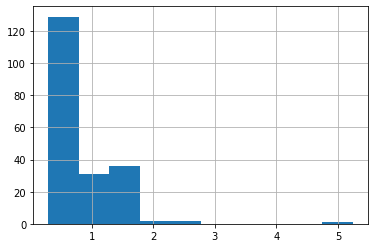

In [ ]:
dados_Sniffer_Geo[(dados_Sniffer_Geo['Area Type'] == 'STREET')
& (dados_Sniffer_Geo['Weekend'] == True)
& (dados_Sniffer_Geo['RushHr'] == True)]['CO'].hist()
dados_Sniffer_Geo[(dados_Sniffer_Geo['Area Type'] == 'STREET')
& (dados_Sniffer_Geo['Weekend'] == True)
& (dados_Sniffer_Geo['RushHr'] == True)].describe()

#### Mapas Sniffer Street Weekend horários de No Rush

In [ ]:
dados_map = dados_Sniffer_Geo[
                              (dados_Sniffer_Geo['Area Type'] == 'STREET')
                              & (dados_Sniffer_Geo['Weekend'] == True)
                              & (dados_Sniffer_Geo['RushHr'] == False)]
location = dados_map[['Latitude', 'Longitude']].iloc[0]

#m_1 = folium.Map(location=location, tiles='openstreetmap', 
#                 zoom_start=10)
#m_1

m_5 = folium.Map(location=location, tiles='cartodbpositron', zoom_start=13)

# Add a heatmap to the base map
data = (dados_map[['Latitude', 'Longitude', 'CO']].
        groupby(['Latitude', 'Longitude']).mean())

#data
HeatMap(data=data.reset_index().values.tolist(), radius=10, 
        max_val=data['CO'].max()).add_to(m_5)

import branca.colormap as cm

colormap = cm.linear.viridis.scale(vmin=data['CO'].min(), 
                                   vmax=data['CO'].max())

colormap.caption = 'Concentration of Carbon Monoxide (ppb)'
m_5.add_child(colormap)

# Display the map
m_5

#### Estatísticas Street Weekend horários de No Rush

Longitude   Latitude  Temperature   Humidity         CO
count  71.000000  71.000000    71.000000  71.000000  71.000000
mean  -48.526997 -27.595660    24.104282  57.011857   0.976524
std     0.011896   0.013070     2.467616   8.015025   0.922827
min   -48.560771 -27.612747    18.431372  46.024510   0.384936
25%   -48.529697 -27.608100    21.764706  51.375817   0.551300
50%   -48.521881 -27.600487    25.101308  54.093137   0.622810
75%   -48.518506 -27.584960    25.631536  60.338235   0.874947
max   -48.515037 -27.571780    27.651961  73.260935   4.922095

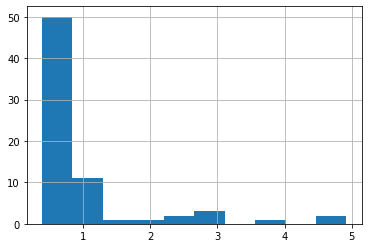

In [ ]:
dados_Sniffer_Geo[(dados_Sniffer_Geo['Area Type'] == 'STREET')
& (dados_Sniffer_Geo['Weekend'] == True)
& (dados_Sniffer_Geo['RushHr'] == False)]['CO'].hist()
dados_Sniffer_Geo[(dados_Sniffer_Geo['Area Type'] == 'STREET')
& (dados_Sniffer_Geo['Weekend'] == True)
& (dados_Sniffer_Geo['RushHr'] == False)].describe()

#### Mapas do Percurso 2 SPEC

In [ ]:
location = dados_SPEC_Per2Geo[['Latitude', 'Longitude']].iloc[0]

#m_1 = folium.Map(location=location, tiles='openstreetmap', 
#                 zoom_start=10)
#m_1

m_5 = folium.Map(location=location, tiles='cartodbpositron', zoom_start=13)

# Add a heatmap to the base map
data = (dados_SPEC_Per2Geo[['Latitude', 'Longitude', 'Value']].
        groupby(['Latitude', 'Longitude']).mean())

#data
HeatMap(data=data.reset_index().values.tolist(), radius=10, 
        max_val=data['Value'].max()).add_to(m_5)

import branca.colormap as cm

colormap = cm.linear.viridis.scale(vmin=data['Value'].min(), 
                                   vmax=data['Value'].max())

colormap.caption = 'Concentration of Carbon Monoxide (ppb)'
m_5.add_child(colormap)

# Display the map
m_5

#### Mapas do Percurso 2 Sniffer

In [ ]:
location = dados_Sniffer_Per2_Geo[['Latitude', 'Longitude']].iloc[0]

#m_1 = folium.Map(location=location, tiles='openstreetmap', 
#                 zoom_start=10)
#m_1

m_5 = folium.Map(location=location, tiles='cartodbpositron', zoom_start=13)

# Add a heatmap to the base map
data = (dados_Sniffer_Per2_Geo[['Latitude', 'Longitude', 'CO']].
        groupby(['Latitude', 'Longitude']).mean()).dropna(how='all')

#data
HeatMap(data=data.reset_index().values.tolist(), radius=10, 
        max_val=data['CO'].max()).add_to(m_5)

import branca.colormap as cm

colormap = cm.linear.viridis.scale(vmin=data['CO'].min(), 
                                   vmax=data['CO'].max())

colormap.caption = 'Concentration of Carbon Monoxide (ppb)'
m_5.add_child(colormap)

# Display the map
m_5

#### Mapas do Percurso 3 SPEC

In [ ]:
location = dados_SPEC_Per3Geo[['Latitude', 'Longitude']].iloc[0]

#m_1 = folium.Map(location=location, tiles='openstreetmap', 
#                 zoom_start=10)
#m_1

m_5 = folium.Map(location=location, tiles='cartodbpositron', zoom_start=13)

# Add a heatmap to the base map
data = (dados_SPEC_Per3Geo[['Latitude', 'Longitude', 'Value']].
        groupby(['Latitude', 'Longitude']).mean()).dropna(how='all')

#data
HeatMap(data=data.reset_index().values.tolist(), radius=10, 
        max_val=data['Value'].max()).add_to(m_5)

import branca.colormap as cm

colormap = cm.linear.viridis.scale(vmin=data['Value'].min(), 
                                   vmax=data['Value'].max())

colormap.caption = 'Concentration of Carbon Monoxide (ppb)'
m_5.add_child(colormap)

# Display the map
m_5

#### Mapas do Percurso 3 Sniffer

In [ ]:
location = dados_Sniffer_Per3_Geo[['Latitude', 'Longitude']].iloc[0]

#m_1 = folium.Map(location=location, tiles='openstreetmap', 
#                 zoom_start=10)
#m_1

m_5 = folium.Map(location=location, tiles='cartodbpositron', zoom_start=13)

# Add a heatmap to the base map
data = (dados_Sniffer_Per3_Geo[['Latitude', 'Longitude', 'CO']].
        groupby(['Latitude', 'Longitude']).mean()).dropna(how='all')

#data
HeatMap(data=data.reset_index().values.tolist(), radius=10, 
        max_val=data['CO'].max()).add_to(m_5)

import branca.colormap as cm

colormap = cm.linear.viridis.scale(vmin=data['CO'].min(), 
                                   vmax=data['CO'].max())

colormap.caption = 'Concentration of Carbon Monoxide (ppb)'
m_5.add_child(colormap)

# Display the map
m_5

In [ ]:
data_d1 = valid_data.where(valid_data['Month'].eq(8)).where(
    valid_data['Day'].eq(3)).dropna()

location = data_d1[['Latitude', 'Longitude']].iloc[0]

map_d1 = folium.Map(location=location, tiles='cartodbpositron', zoom_start=14)


data = (data_d1[['Latitude', 'Longitude', 'Value']].
        groupby(['Latitude', 'Longitude']).mean())

HeatMap(data=data.reset_index().values.tolist(), radius=10, 
        max_val=data['Value'].max()).add_to(map_d1)

import branca.colormap as cm

colormap = cm.linear.viridis.scale(vmin=data['Value'].min(), 
                                   vmax=data['Value'].max())

colormap.caption = 'Concentration of Carbon Monoxide (ppb)'
map_d1.add_child(colormap)

# Display the map
map_d1

##### Mapas do Sniffer

In [ ]:
data_d1

In [ ]:
data_d1 = dados_Sniffer[['Longitude', 'Latitude', 'CO mg/m³']].where(
    dados_Sniffer['Month'].eq(8)).where(
    dados_Sniffer['Weekday'].eq(0)).dropna()

location = data_d1[['Latitude', 'Longitude']].iloc[0]

map_d1 = folium.Map(location=location, tiles='cartodbpositron', zoom_start=14)


data = (data_d1.groupby(['Latitude', 'Longitude']).mean())

HeatMap(data=data.reset_index().values.tolist(), radius=10, 
        max_val=data['CO mg/m³'].max()).add_to(map_d1)

import branca.colormap as cm

colormap = cm.linear.viridis.scale(vmin=data['CO mg/m³'].min(), 
                                   vmax=data['CO mg/m³'].max())

colormap.caption = 'Concentration of Carbon Monoxide (ppm)'
map_d1.add_child(colormap)

# Display the map
map_d1

### Importa shapefiles

#### Shapefiles de Santa Catarina

NM_MUNICIP CD_GEOCMU                                           geometry
153  FLORIANÓPOLIS   4205407  MULTIPOLYGON (((-48.50498 -27.89191, -48.50514...

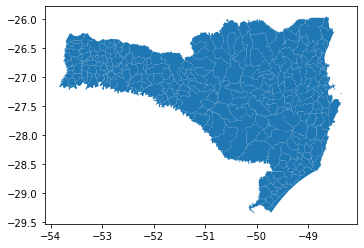

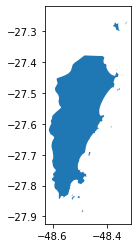

In [ ]:
#sc_gpd = gpd.read_file(filename=shapefileFolder.joinpath("42MEE250GC_SIR.shp"))
#sc_gpd = gpd.read_file(filename=shapefileFolder.joinpath("42UFE250GC_SIR.shp"))
sc_gpd = gpd.read_file(filename=shapefileFolder.joinpath("42MUE250GC_SIR.shp"))
#sc_gpd = gpd.read_file(filename=baseFolder.joinpath(
#    "SHAPEFILES/REDE VIARIA/REDE VIARIA.shp"))
sc_gpd.plot()
sc_gpd.head()
sc_gpd[sc_gpd['NM_MUNICIP'] == 'FLORIANÓPOLIS'].plot()
fln_gdp = sc_gpd[sc_gpd['NM_MUNICIP'] == 'FLORIANÓPOLIS']
fln_gdp.head()

#### Shapefile da Grande Florianópolis

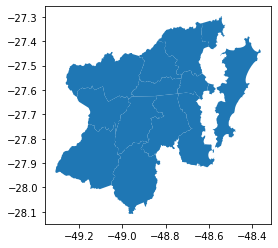

In [ ]:
fln_gpd = gpd.read_file(filename=shapefileFolder.joinpath(
    "Municípios/municipios.shp"))
fln_gpd.plot()

#### Shapefile da rede viária da Grande Florianópolis

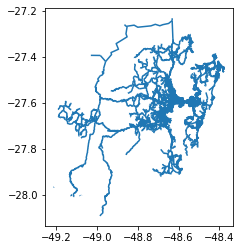

In [ ]:
net_gpd = gpd.read_file(filename=shapefileFolder.joinpath(
    "REDE VIARIA/REDE VIARIA.shp"))
net_gpd.plot()

#### Plota valores de concentração de SPEC no mapa

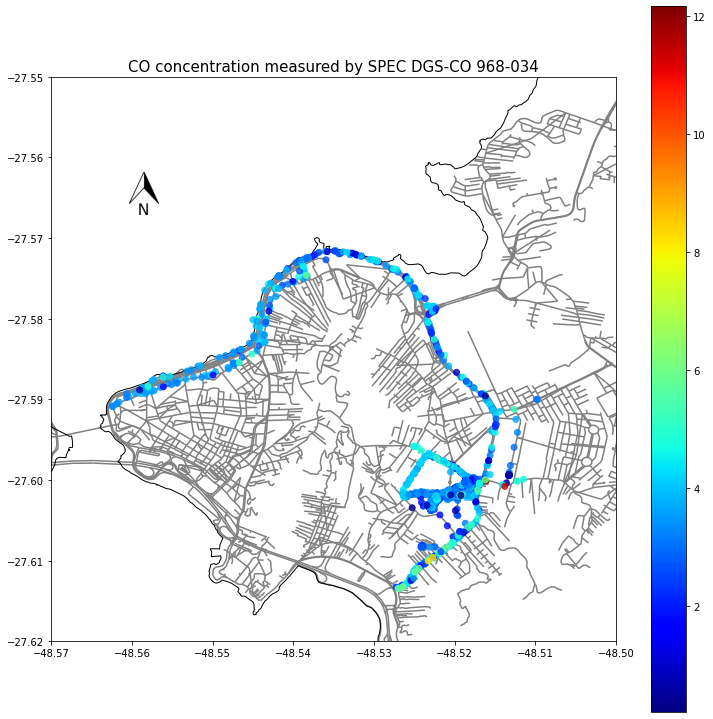

In [ ]:
fig = plt.figure(figsize=(10,10))

zoom_rectX = -48.57
zoom_rectY = -27.62
zoom_rectW = 0.07

ax2 = fig.add_axes([0.01,0.01,0.98,0.98])
fln_gpd.geometry.boundary.plot(ax=ax2, color = 'k', linewidth = 1.0)
ax2.set_xlim(zoom_rectX, zoom_rectX+zoom_rectW) 
ax2.set_ylim(zoom_rectY, zoom_rectY+zoom_rectW)
ax2.set_title('CO concentration measured by SPEC DGS-CO 968-034', 
              fontsize=15)

im = plt.imread(shapefileFolder.joinpath(
    'north.png'))
newax = fig.add_axes([0.1, 0.7, 0.06, 0.06], anchor='NE', zorder = 1)
newax.imshow(im)
newax.axis('off')

net_gpd.plot(ax=ax2, color='gray', zorder=1)
dados_SPEC_validGeo.plot(ax=ax2, column = 'Value', alpha=0.8, 
                       legend = True, zorder=2, cmap='jet')

#### Plota valores de concentração de Sniffer no mapa

(-0.5, 186.5, 269.5, -0.5)

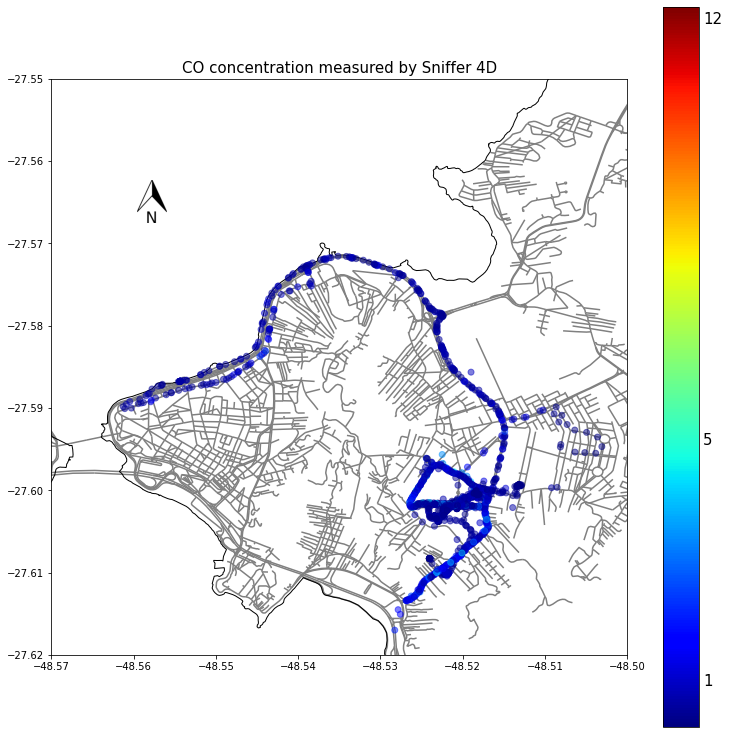

In [ ]:
fig = plt.figure(figsize=(10,10))

zoom_rectX = -48.57
zoom_rectY = -27.62
zoom_rectW = 0.07

ax2 = fig.add_axes([0.0,0.0,0.8,1])
fln_gpd.geometry.boundary.plot(ax=ax2, color = 'k', linewidth = 1.0)
ax2.set_xlim(zoom_rectX, zoom_rectX+zoom_rectW) 
ax2.set_ylim(zoom_rectY, zoom_rectY+zoom_rectW)
ax2.set_title('CO concentration measured by Sniffer 4D', 
              fontsize=15)

net_gpd.plot(ax=ax2, color='gray', zorder=1)

data = dados_Sniffer_Geo
data.plot(ax=ax2, column = 'CO', alpha=0.5, legend = False, zorder=2, cmap='jet', 
          vmin = dados_SPEC_validGeo['Value'].min(), 
          vmax = dados_SPEC_validGeo['Value'].max())

img = plt.imshow([np.array(dados_SPEC_validGeo['Value'])], cmap='jet')
cax = plt.axes([0.85, 0.0, 0.05, 1])
cbar = plt.colorbar(orientation='vertical', cax=cax)
cbar.ax.tick_params(labelsize=11, length=0)
ticks = [np.int64(dados_SPEC_validGeo['Value'].min()+1),
         np.int64((dados_SPEC_validGeo['Value'].max()
         -dados_SPEC_validGeo['Value'].min())/2),
         np.int64(dados_SPEC_validGeo['Value'].max())]
cbar.set_ticks(np.array(ticks))
cbar.ax.tick_params(labelsize=15, length=0)

im = plt.imread(shapefileFolder.joinpath(
    'north.png'))
newax = fig.add_axes([0.1, 0.7, 0.06, 0.06], anchor='NE', zorder = 1)
newax.imshow(im)
newax.axis('off')

#### Análise por Rua o Residencial

##### Plota valores de concentração SPEC em Ruas no mapa

(-0.5, 186.5, 269.5, -0.5)

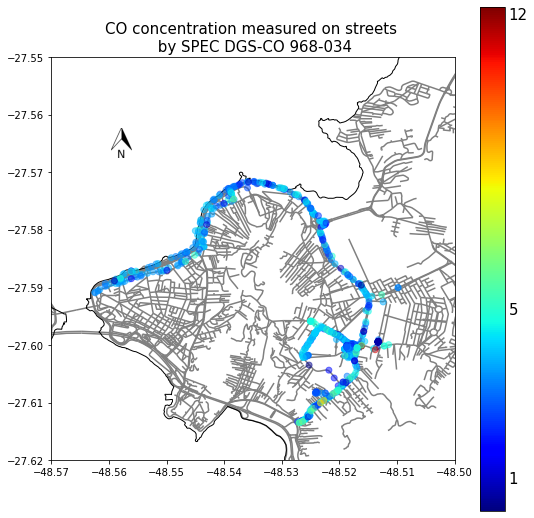

In [ ]:
fig = plt.figure(figsize=(7,7))

zoom_rectX = -48.57
zoom_rectY = -27.62
zoom_rectW = 0.07

ax2 = fig.add_axes([0.0,0.0,0.8,1])
fln_gpd.geometry.boundary.plot(ax=ax2, color = 'k', linewidth = 1.0)
ax2.set_xlim(zoom_rectX, zoom_rectX+zoom_rectW) 
ax2.set_ylim(zoom_rectY, zoom_rectY+zoom_rectW)
ax2.set_title('CO concentration measured on streets \n by SPEC DGS-CO 968-034', 
              fontsize=15)

net_gpd.plot(ax=ax2, color='gray', zorder=1)

data = dados_SPEC_validGeo
data[data['Area Type'] == 'STREET'].plot(
    ax=ax2, column = 'Value', alpha=0.5, legend = False, 
    zorder=2, cmap='jet', vmin = data['Value'].min(), 
    vmax = data['Value'].max())

img = plt.imshow([np.array(data['Value'])], cmap='jet')
cax = plt.axes([0.85, 0.0, 0.05, 1])
cbar = plt.colorbar(orientation='vertical', cax=cax)
cbar.ax.tick_params(labelsize=11, length=0)
ticks = [np.int64(data['Value'].min()+1),
         np.int64((data['Value'].max()
         -data['Value'].min())/2),
         np.int64(data['Value'].max())]
cbar.set_ticks(np.array(ticks))
cbar.ax.tick_params(labelsize=15, length=0)

im = plt.imread(shapefileFolder.joinpath(
    'north.png'))
newax = fig.add_axes([0.1, 0.7, 0.06, 0.06], anchor='NE', zorder = 3)
newax.imshow(im)
newax.axis('off')

##### Plota valores de concentração Sniffer em Ruas no mapa

(-0.5, 186.5, 269.5, -0.5)

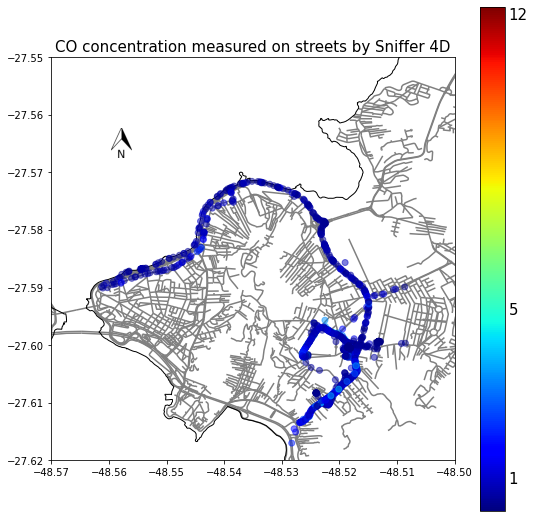

In [ ]:
fig = plt.figure(figsize=(7,7))

zoom_rectX = -48.57
zoom_rectY = -27.62
zoom_rectW = 0.07

ax2 = fig.add_axes([0.0,0.0,0.8,1])
fln_gpd.geometry.boundary.plot(ax=ax2, color = 'k', linewidth = 1.0)
ax2.set_xlim(zoom_rectX, zoom_rectX+zoom_rectW) 
ax2.set_ylim(zoom_rectY, zoom_rectY+zoom_rectW)
ax2.set_title('CO concentration measured on streets by Sniffer 4D',
              fontsize=15)

net_gpd.plot(ax=ax2, color='gray', zorder=1)

data = dados_Sniffer_Geo
data[data['Area Type'] == 'STREET'].plot(
    ax=ax2, column = 'CO', alpha=0.5, legend = False, 
    zorder=2, cmap='jet', vmin = dados_SPEC_validGeo['Value'].min(), 
    vmax = dados_SPEC_validGeo['Value'].max())

img = plt.imshow([np.array(dados_SPEC_validGeo['Value'])], cmap='jet')
cax = plt.axes([0.85, 0.0, 0.05, 1])
cbar = plt.colorbar(orientation='vertical', cax=cax)
cbar.ax.tick_params(labelsize=11, length=0)
ticks = [np.int64(dados_SPEC_validGeo['Value'].min()+1),
         np.int64((dados_SPEC_validGeo['Value'].max()
         -dados_SPEC_validGeo['Value'].min())/2),
         np.int64(dados_SPEC_validGeo['Value'].max())]
cbar.set_ticks(np.array(ticks))
cbar.ax.tick_params(labelsize=15, length=0)

im = plt.imread(shapefileFolder.joinpath(
    'north.png'))
newax = fig.add_axes([0.1, 0.7, 0.06, 0.06], anchor='NE', zorder = 3)
newax.imshow(im)
newax.axis('off')

##### Plota valores de concentração SPEC em área Residencial no mapa

(-0.5, 186.5, 269.5, -0.5)

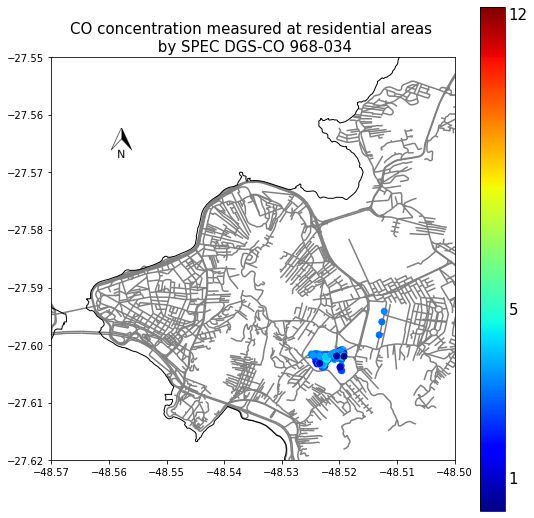

In [ ]:
fig = plt.figure(figsize=(7,7))

zoom_rectX = -48.57
zoom_rectY = -27.62
zoom_rectW = 0.07

ax2 = fig.add_axes([0.0,0.0,0.8,1])
fln_gpd.geometry.boundary.plot(ax=ax2, color = 'k', linewidth = 1.0)
ax2.set_xlim(zoom_rectX, zoom_rectX+zoom_rectW) 
ax2.set_ylim(zoom_rectY, zoom_rectY+zoom_rectW)
ax2.set_title('CO concentration measured at residential areas \n by SPEC DGS-CO 968-034',
              fontsize=15)

net_gpd.plot(ax=ax2, color='gray', zorder=1)

data = dados_SPEC_validGeo
data[data['Area Type'] == 'RESIDENTIAL'].plot(
    ax=ax2, column = 'Value', alpha=1.0, legend = False, 
    zorder=2, cmap='jet', vmin = dados_SPEC_validGeo['Value'].min(), 
    vmax = dados_SPEC_validGeo['Value'].max())

img = plt.imshow([np.array(data['Value'])], cmap='jet')
cax = plt.axes([0.85, 0.0, 0.05, 1])
cbar = plt.colorbar(orientation='vertical', cax=cax)
cbar.ax.tick_params(labelsize=11, length=0)
ticks = [np.int64(data['Value'].min()+1),
         np.int64((data['Value'].max()
         -data['Value'].min())/2),
         np.int64(data['Value'].max())]
cbar.set_ticks(np.array(ticks))
cbar.ax.tick_params(labelsize=15, length=0)

im = plt.imread(shapefileFolder.joinpath(
    'north.png'))
newax = fig.add_axes([0.1, 0.7, 0.06, 0.06], anchor='NE', zorder = 3)
newax.imshow(im)
newax.axis('off')

##### Plota valores de concentração Sniffer em área Residencial no mapa

(-0.5, 186.5, 269.5, -0.5)

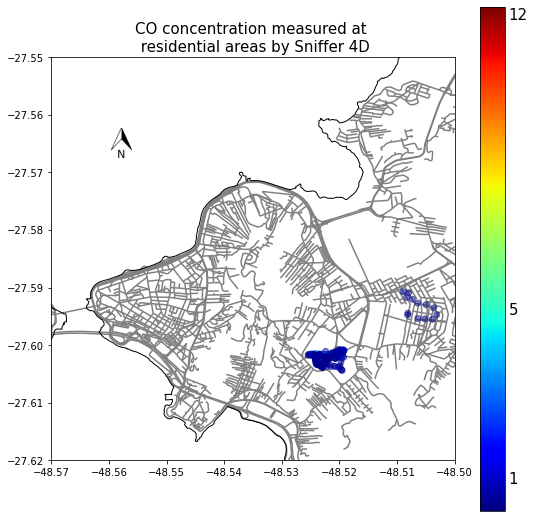

In [ ]:
fig = plt.figure(figsize=(7,7))

zoom_rectX = -48.57
zoom_rectY = -27.62
zoom_rectW = 0.07

ax2 = fig.add_axes([0.0,0.0,0.8,1])
fln_gpd.geometry.boundary.plot(ax=ax2, color = 'k', linewidth = 1.0)
ax2.set_xlim(zoom_rectX, zoom_rectX+zoom_rectW) 
ax2.set_ylim(zoom_rectY, zoom_rectY+zoom_rectW)
ax2.set_title('CO concentration measured at \n residential areas by Sniffer 4D',
              fontsize=15)


net_gpd.plot(ax=ax2, color='gray', zorder=1)

data = dados_Sniffer_Geo
data[data['Area Type'] == 'RESIDENTIAL'].plot(
    ax=ax2, column = 'CO', alpha=0.5, legend = False, 
    zorder=2, cmap='jet', vmin = dados_SPEC_validGeo['Value'].min(), 
    vmax = dados_SPEC_validGeo['Value'].max())

img = plt.imshow([np.array(dados_SPEC_validGeo['Value'])], cmap='jet')
cax = plt.axes([0.85, 0.0, 0.05, 1])
cbar = plt.colorbar(orientation='vertical', cax=cax)
cbar.ax.tick_params(labelsize=11, length=0)
ticks = [np.int64(dados_SPEC_validGeo['Value'].min()+1),
         np.int64((dados_SPEC_validGeo['Value'].max()
         -dados_SPEC_validGeo['Value'].min())/2),
         np.int64(dados_SPEC_validGeo['Value'].max())]
cbar.set_ticks(np.array(ticks))
cbar.ax.tick_params(labelsize=15, length=0)

im = plt.imread(shapefileFolder.joinpath(
    'north.png'))
newax = fig.add_axes([0.1, 0.7, 0.06, 0.06], anchor='NE', zorder = 3)
newax.imshow(im)
newax.axis('off')

##### Boxplot segundo local

Text(0.5, 1.0, 'Box-plots of CO concentrations according to area type')

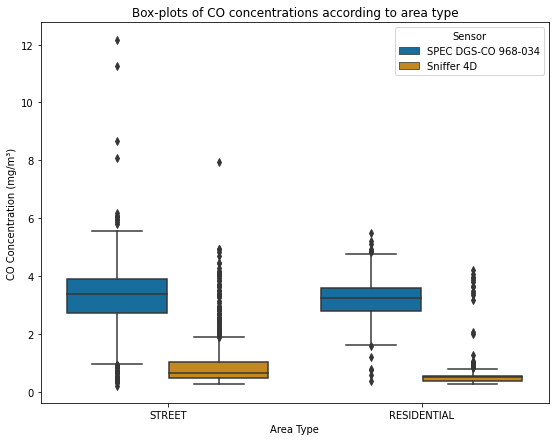

In [ ]:
dados_SPEC_validGeo['Sensor'] = dados_SPEC_validGeo.index.map(
    lambda i: 'SPEC DGS-CO 968-034')
dados_Sniffer_Geo['Sensor'] = dados_Sniffer_Geo.index.map(
    lambda i: 'Sniffer 4D')

dados_boxplot = pd.DataFrame(columns=['Area Type', 'Sensor', 'Value'])
dados_boxplot = pd.concat([dados_SPEC_validGeo[['Area Type', 'Sensor', 'Value']]
                           .rename(columns={"Value": "CO Concentration (mg/m\N{SUPERSCRIPT THREE})"})
                           .dropna(axis='index', how='any'),
                           dados_Sniffer_Geo[['Area Type', 'Sensor', 'CO']]
                           .rename(columns={"CO": "CO Concentration (mg/m\N{SUPERSCRIPT THREE})"})
                           .dropna(axis='index', how='any')])

fig = plt.figure(figsize=(1.3*7,7))
ax = sns.boxplot(y='CO Concentration (mg/m\N{SUPERSCRIPT THREE})', 
                 x='Area Type', data=dados_boxplot, palette="colorblind",
                 hue='Sensor')
ax.set_title('Box-plots of CO concentrations according to area type')

##### Plota valores de concentração SPEC dias da semana no mapa

(-0.5, 186.5, 269.5, -0.5)

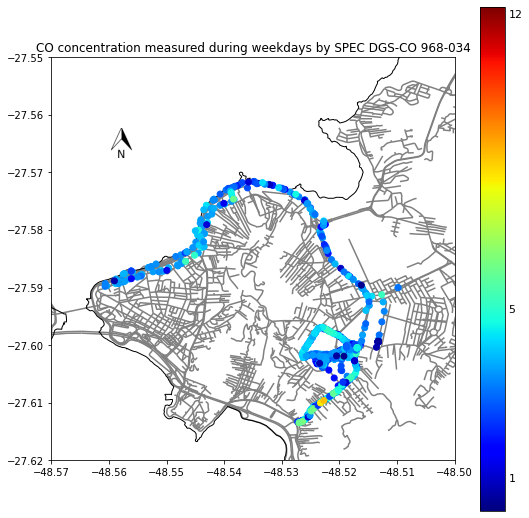

In [ ]:
fig = plt.figure(figsize=(7,7))

zoom_rectX = -48.57
zoom_rectY = -27.62
zoom_rectW = 0.07

ax2 = fig.add_axes([0.0,0.0,0.8,1])
fln_gpd.geometry.boundary.plot(ax=ax2, color = 'k', linewidth = 1.0)
ax2.set_xlim(zoom_rectX, zoom_rectX+zoom_rectW) 
ax2.set_ylim(zoom_rectY, zoom_rectY+zoom_rectW)
ax2.set_title('CO concentration measured during weekdays by SPEC DGS-CO 968-034',
              fontsize=12)

net_gpd.plot(ax=ax2, color='gray', zorder=1)

data = dados_SPEC_validGeo
data[data['Weekend'] == False].plot(
    ax=ax2, column = 'Value', alpha=1.0, legend = False, 
    zorder=2, cmap='jet', vmin = dados_SPEC_validGeo['Value'].min(), 
    vmax = dados_SPEC_validGeo['Value'].max())

img = plt.imshow([np.array(data['Value'])], cmap='jet')
cax = plt.axes([0.85, 0.0, 0.05, 1])
cbar = plt.colorbar(orientation='vertical', cax=cax)
cbar.ax.tick_params(labelsize=11, length=0)
ticks = [np.int64(data['Value'].min()+1),
         np.int64((data['Value'].max()
         -data['Value'].min())/2),
         np.int64(data['Value'].max())]
cbar.set_ticks(np.array(ticks))

im = plt.imread(shapefileFolder.joinpath(
    'north.png'))
newax = fig.add_axes([0.1, 0.7, 0.06, 0.06], anchor='NE', zorder = 3)
newax.imshow(im)
newax.axis('off')

##### Plota valores de concentração Sniffer dias da semana no mapa

(-0.5, 186.5, 269.5, -0.5)

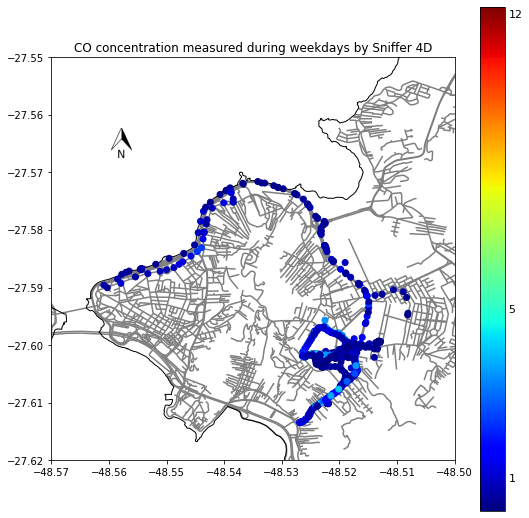

In [ ]:
fig = plt.figure(figsize=(7,7))

zoom_rectX = -48.57
zoom_rectY = -27.62
zoom_rectW = 0.07

ax2 = fig.add_axes([0.0,0.0,0.8,1])
fln_gpd.geometry.boundary.plot(ax=ax2, color = 'k', linewidth = 1.0)
ax2.set_xlim(zoom_rectX, zoom_rectX+zoom_rectW) 
ax2.set_ylim(zoom_rectY, zoom_rectY+zoom_rectW)
ax2.set_title('CO concentration measured during weekdays by Sniffer 4D',
              fontsize=12)

net_gpd.plot(ax=ax2, color='gray', zorder=1)

data = dados_Sniffer_Geo
data[data['Weekend'] == False].plot(
    ax=ax2, column = 'CO', alpha=1.0, legend = False, 
    zorder=2, cmap='jet', vmin = dados_SPEC_validGeo['Value'].min(), 
    vmax = dados_SPEC_validGeo['Value'].max())

img = plt.imshow([np.array(dados_SPEC_validGeo['Value'])], cmap='jet')
cax = plt.axes([0.85, 0.0, 0.05, 1])
cbar = plt.colorbar(orientation='vertical', cax=cax)
cbar.ax.tick_params(labelsize=11, length=0)
ticks = [np.int64(dados_SPEC_validGeo['Value'].min()+1),
         np.int64((dados_SPEC_validGeo['Value'].max()
         -dados_SPEC_validGeo['Value'].min())/2),
         np.int64(dados_SPEC_validGeo['Value'].max())]
cbar.set_ticks(np.array(ticks))

im = plt.imread(shapefileFolder.joinpath(
    'north.png'))
newax = fig.add_axes([0.1, 0.7, 0.06, 0.06], anchor='NE', zorder = 3)
newax.imshow(im)
newax.axis('off')

##### Plota valores de concentração SPEC finais de semana no mapa

(-0.5, 186.5, 269.5, -0.5)

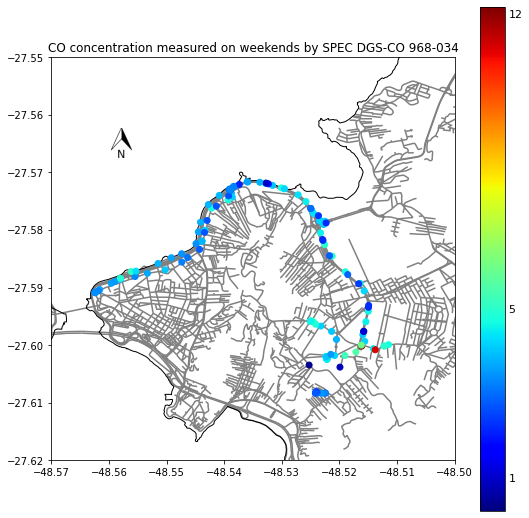

In [ ]:
fig = plt.figure(figsize=(7,7))

zoom_rectX = -48.57
zoom_rectY = -27.62
zoom_rectW = 0.07

ax2 = fig.add_axes([0.0,0.0,0.8,1])
fln_gpd.geometry.boundary.plot(ax=ax2, color = 'k', linewidth = 1.0)
ax2.set_xlim(zoom_rectX, zoom_rectX+zoom_rectW) 
ax2.set_ylim(zoom_rectY, zoom_rectY+zoom_rectW)
ax2.set_title('CO concentration measured on weekends by SPEC DGS-CO 968-034',
              fontsize=12)

net_gpd.plot(ax=ax2, color='gray', zorder=1)

data = dados_SPEC_validGeo
data[data['Weekend'] == True].plot(
    ax=ax2, column = 'Value', alpha=1.0, legend = False, 
    zorder=2, cmap='jet', vmin = dados_SPEC_validGeo['Value'].min(), 
    vmax = dados_SPEC_validGeo['Value'].max())

img = plt.imshow([np.array(data['Value'])], cmap='jet')
cax = plt.axes([0.85, 0.0, 0.05, 1])
cbar = plt.colorbar(orientation='vertical', cax=cax)
cbar.ax.tick_params(labelsize=11, length=0)
ticks = [np.int64(data['Value'].min()+1),
         np.int64((data['Value'].max()
         -data['Value'].min())/2),
         np.int64(data['Value'].max())]
cbar.set_ticks(np.array(ticks))

im = plt.imread(shapefileFolder.joinpath(
    'north.png'))
newax = fig.add_axes([0.1, 0.7, 0.06, 0.06], anchor='NE', zorder = 3)
newax.imshow(im)
newax.axis('off')

##### Plota valores de concentração Sniffer finais de semana no mapa

(-0.5, 186.5, 269.5, -0.5)

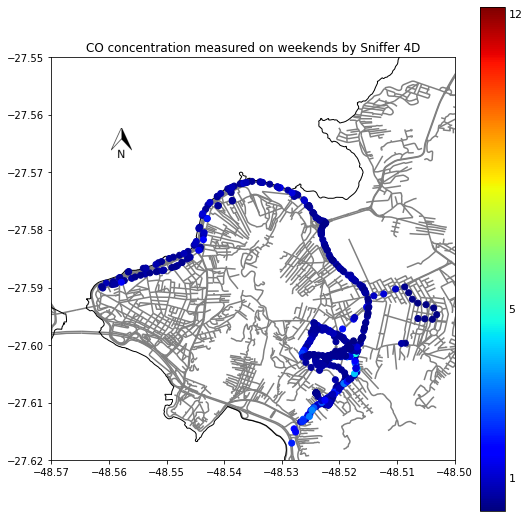

In [ ]:
fig = plt.figure(figsize=(7,7))

zoom_rectX = -48.57
zoom_rectY = -27.62
zoom_rectW = 0.07

ax2 = fig.add_axes([0.0,0.0,0.8,1])
fln_gpd.geometry.boundary.plot(ax=ax2, color = 'k', linewidth = 1.0)
ax2.set_xlim(zoom_rectX, zoom_rectX+zoom_rectW) 
ax2.set_ylim(zoom_rectY, zoom_rectY+zoom_rectW)
ax2.set_title('CO concentration measured on weekends by Sniffer 4D',
              fontsize=12)

net_gpd.plot(ax=ax2, color='gray', zorder=1)

data = dados_Sniffer_Geo
data[data['Weekend'] == True].plot(
    ax=ax2, column = 'CO', alpha=1.0, legend = False, 
    zorder=2, cmap='jet', vmin = dados_SPEC_validGeo['Value'].min(), 
    vmax = dados_SPEC_validGeo['Value'].max())

img = plt.imshow([np.array(dados_SPEC_validGeo['Value'])], cmap='jet')
cax = plt.axes([0.85, 0.0, 0.05, 1])
cbar = plt.colorbar(orientation='vertical', cax=cax)
cbar.ax.tick_params(labelsize=11, length=0)
ticks = [np.int64(dados_SPEC_validGeo['Value'].min()+1),
         np.int64((dados_SPEC_validGeo['Value'].max()
         -dados_SPEC_validGeo['Value'].min())/2),
         np.int64(dados_SPEC_validGeo['Value'].max())]
cbar.set_ticks(np.array(ticks))

im = plt.imread(shapefileFolder.joinpath(
    'north.png'))
newax = fig.add_axes([0.1, 0.7, 0.06, 0.06], anchor='NE', zorder = 3)
newax.imshow(im)
newax.axis('off')

##### Boxplot segundo dia da semana

Text(0.5, 1.0, 'Box-plots of CO concentrations according to day of the week')

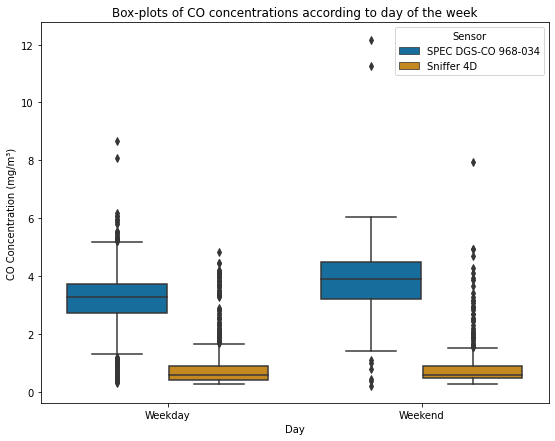

In [ ]:
dados_SPEC_validGeo['Sensor'] = dados_SPEC_validGeo.index.map(
    lambda i: 'SPEC DGS-CO 968-034')
dados_Sniffer_Geo['Sensor'] = dados_Sniffer_Geo.index.map(
    lambda i: 'Sniffer 4D')
dados_SPEC_validGeo['Day'] = dados_SPEC_validGeo['Weekend'].map(
    lambda d: 'Weekend' if d else 'Weekday')
dados_Sniffer_Geo['Day'] = dados_Sniffer_Geo['Weekend'].map(
    lambda d: 'Weekend' if d else 'Weekday')

dados_boxplot = pd.DataFrame(columns=['Day', 'Sensor', 'CO Concentration (mg/m\N{SUPERSCRIPT THREE})'])
dados_boxplot = pd.concat([dados_SPEC_validGeo[['Day', 'Sensor', 'Value']]
                           .rename(columns={"Value": "CO Concentration (mg/m\N{SUPERSCRIPT THREE})"})
                           .dropna(axis='index', how='any'),
                           dados_Sniffer_Geo[['Day', 'Sensor', 'CO']]
                           .rename(columns={"CO": "CO Concentration (mg/m\N{SUPERSCRIPT THREE})"})
                           .dropna(axis='index', how='any')])

fig = plt.figure(figsize=(1.3*7,7))
ax = sns.boxplot(y='CO Concentration (mg/m\N{SUPERSCRIPT THREE})', 
                 x='Day', data=dados_boxplot, palette="colorblind",
                 hue='Sensor')
ax.set_title('Box-plots of CO concentrations according to day of the week')

##### Plota valores de concentração SPEC dias da semana em ruas no mapa

(-0.5, 186.5, 269.5, -0.5)

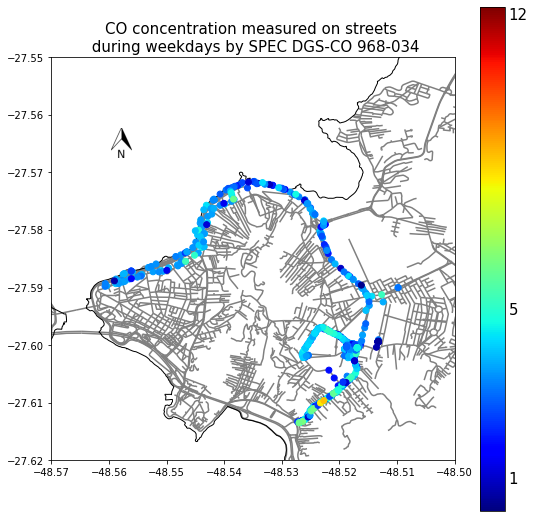

In [ ]:
fig = plt.figure(figsize=(7,7))

zoom_rectX = -48.57
zoom_rectY = -27.62
zoom_rectW = 0.07

ax2 = fig.add_axes([0.0,0.0,0.8,1])
fln_gpd.geometry.boundary.plot(ax=ax2, color = 'k', linewidth = 1.0)
ax2.set_xlim(zoom_rectX, zoom_rectX+zoom_rectW) 
ax2.set_ylim(zoom_rectY, zoom_rectY+zoom_rectW)
ax2.set_title('CO concentration measured on streets \n during weekdays by SPEC DGS-CO 968-034',
              fontsize=15)

net_gpd.plot(ax=ax2, color='gray', zorder=1)

data = dados_SPEC_validGeo
data[(data['Weekend'] == False) &
     (data['Area Type'] == 'STREET')].plot(
    ax=ax2, column = 'Value', alpha=1.0, legend = False, 
    zorder=2, cmap='jet', vmin = dados_SPEC_validGeo['Value'].min(), 
    vmax = dados_SPEC_validGeo['Value'].max())

img = plt.imshow([np.array(data['Value'])], cmap='jet')
cax = plt.axes([0.85, 0.0, 0.05, 1])
cbar = plt.colorbar(orientation='vertical', cax=cax)
cbar.ax.tick_params(labelsize=11, length=0)
ticks = [np.int64(data['Value'].min()+1),
         np.int64((data['Value'].max()
         -data['Value'].min())/2),
         np.int64(data['Value'].max())]
cbar.set_ticks(np.array(ticks))
cbar.ax.tick_params(labelsize=15, length=0)

im = plt.imread(shapefileFolder.joinpath(
    'north.png'))
newax = fig.add_axes([0.1, 0.7, 0.06, 0.06], anchor='NE', zorder = 3)
newax.imshow(im)
newax.axis('off')

##### Plota valores de concentração Sniffer dias da semana em ruas no mapa

(-0.5, 186.5, 269.5, -0.5)

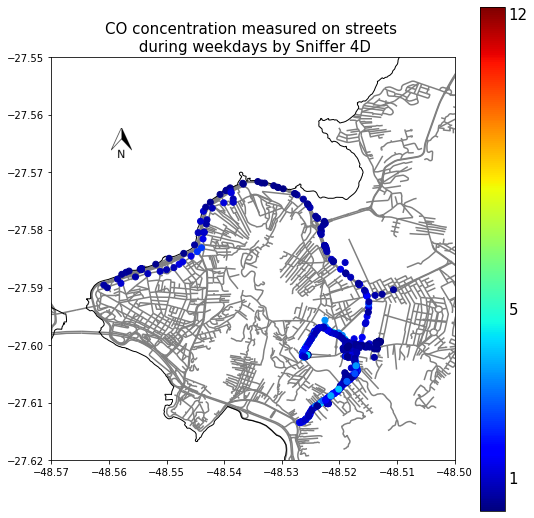

In [ ]:
fig = plt.figure(figsize=(7,7))

zoom_rectX = -48.57
zoom_rectY = -27.62
zoom_rectW = 0.07

ax2 = fig.add_axes([0.0,0.0,0.8,1])
fln_gpd.geometry.boundary.plot(ax=ax2, color = 'k', linewidth = 1.0)
ax2.set_xlim(zoom_rectX, zoom_rectX+zoom_rectW) 
ax2.set_ylim(zoom_rectY, zoom_rectY+zoom_rectW)
ax2.set_title('CO concentration measured on streets \n during weekdays by Sniffer 4D',
              fontsize=15)

net_gpd.plot(ax=ax2, color='gray', zorder=1)

data = dados_Sniffer_Geo
data[(data['Weekend'] == False) &
     (data['Area Type'] == 'STREET')].plot(
    ax=ax2, column = 'CO', alpha=1.0, legend = False, 
    zorder=2, cmap='jet', vmin = dados_SPEC_validGeo['Value'].min(), 
    vmax = dados_SPEC_validGeo['Value'].max())

img = plt.imshow([np.array(dados_SPEC_validGeo['Value'])], cmap='jet')
cax = plt.axes([0.85, 0.0, 0.05, 1])
cbar = plt.colorbar(orientation='vertical', cax=cax)
cbar.ax.tick_params(labelsize=11, length=0)
ticks = [np.int64(dados_SPEC_validGeo['Value'].min()+1),
         np.int64((dados_SPEC_validGeo['Value'].max()
         -dados_SPEC_validGeo['Value'].min())/2),
         np.int64(dados_SPEC_validGeo['Value'].max())]
cbar.set_ticks(np.array(ticks))
cbar.ax.tick_params(labelsize=15, length=0)

im = plt.imread(shapefileFolder.joinpath(
    'north.png'))
newax = fig.add_axes([0.1, 0.7, 0.06, 0.06], anchor='NE', zorder = 3)
newax.imshow(im)
newax.axis('off')

##### Plota valores de concentração SPEC finais de semana em ruas no mapa

(-0.5, 186.5, 269.5, -0.5)

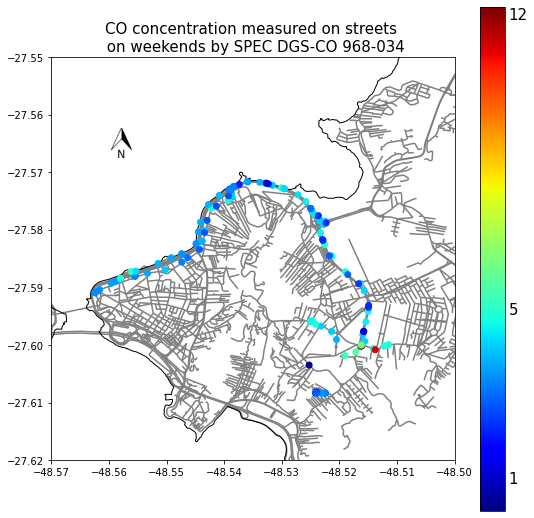

In [ ]:
fig = plt.figure(figsize=(7,7))

zoom_rectX = -48.57
zoom_rectY = -27.62
zoom_rectW = 0.07

ax2 = fig.add_axes([0.0,0.0,0.8,1])
fln_gpd.geometry.boundary.plot(ax=ax2, color = 'k', linewidth = 1.0)
ax2.set_xlim(zoom_rectX, zoom_rectX+zoom_rectW) 
ax2.set_ylim(zoom_rectY, zoom_rectY+zoom_rectW)
ax2.set_title('CO concentration measured on streets \n on weekends by SPEC DGS-CO 968-034',
              fontsize=15)

net_gpd.plot(ax=ax2, color='gray', zorder=1)

data = dados_SPEC_validGeo
data[(data['Weekend'] == True) &
     (data['Area Type'] == 'STREET')].plot(
    ax=ax2, column = 'Value', alpha=1.0, legend = False, 
    zorder=2, cmap='jet', vmin = dados_SPEC_validGeo['Value'].min(), 
    vmax = dados_SPEC_validGeo['Value'].max())

img = plt.imshow([np.array(data['Value'])], cmap='jet')
cax = plt.axes([0.85, 0.0, 0.05, 1])
cbar = plt.colorbar(orientation='vertical', cax=cax)
cbar.ax.tick_params(labelsize=11, length=0)
ticks = [np.int64(data['Value'].min()+1),
         np.int64((data['Value'].max()
         -data['Value'].min())/2),
         np.int64(data['Value'].max())]
cbar.set_ticks(np.array(ticks))
cbar.ax.tick_params(labelsize=15, length=0)

im = plt.imread(shapefileFolder.joinpath(
    'north.png'))
newax = fig.add_axes([0.1, 0.7, 0.06, 0.06], anchor='NE', zorder = 3)
newax.imshow(im)
newax.axis('off')

##### Plota valores de concentração Sniffer finais de semana em ruas no mapa

(-0.5, 186.5, 269.5, -0.5)

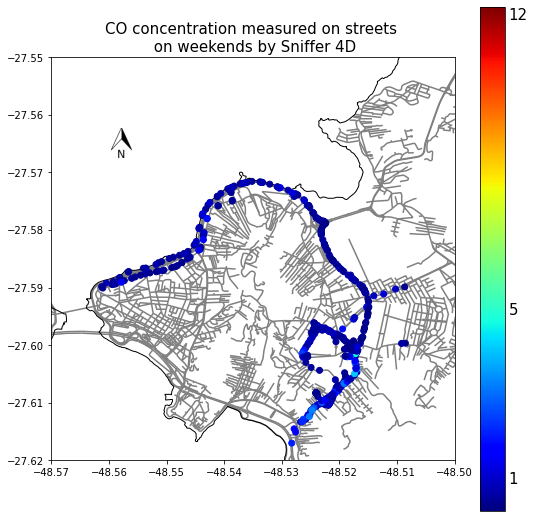

In [ ]:
fig = plt.figure(figsize=(7,7))

zoom_rectX = -48.57
zoom_rectY = -27.62
zoom_rectW = 0.07

ax2 = fig.add_axes([0.0,0.0,0.8,1])
fln_gpd.geometry.boundary.plot(ax=ax2, color = 'k', linewidth = 1.0)
ax2.set_xlim(zoom_rectX, zoom_rectX+zoom_rectW) 
ax2.set_ylim(zoom_rectY, zoom_rectY+zoom_rectW)
ax2.set_title('CO concentration measured on streets \n on weekends by Sniffer 4D',
              fontsize=15)

net_gpd.plot(ax=ax2, color='gray', zorder=1)

data = dados_Sniffer_Geo
data[(data['Weekend'] == True) &
     (data['Area Type'] == 'STREET')].plot(
    ax=ax2, column = 'CO', alpha=1.0, legend = False, 
    zorder=2, cmap='jet', vmin = dados_SPEC_validGeo['Value'].min(), 
    vmax = dados_SPEC_validGeo['Value'].max())

img = plt.imshow([np.array(dados_SPEC_validGeo['Value'])], cmap='jet')
cax = plt.axes([0.85, 0.0, 0.05, 1])
cbar = plt.colorbar(orientation='vertical', cax=cax)
cbar.ax.tick_params(labelsize=11, length=0)
ticks = [np.int64(dados_SPEC_validGeo['Value'].min()+1),
         np.int64((dados_SPEC_validGeo['Value'].max()
         -dados_SPEC_validGeo['Value'].min())/2),
         np.int64(dados_SPEC_validGeo['Value'].max())]
cbar.set_ticks(np.array(ticks))
cbar.ax.tick_params(labelsize=15, length=0)

im = plt.imread(shapefileFolder.joinpath(
    'north.png'))
newax = fig.add_axes([0.1, 0.7, 0.06, 0.06], anchor='NE', zorder = 3)
newax.imshow(im)
newax.axis('off')

##### Boxplot segundo dia da semana em ruas

Text(0.5, 1.0, 'Box-plots of CO concentrations according to day of the week')

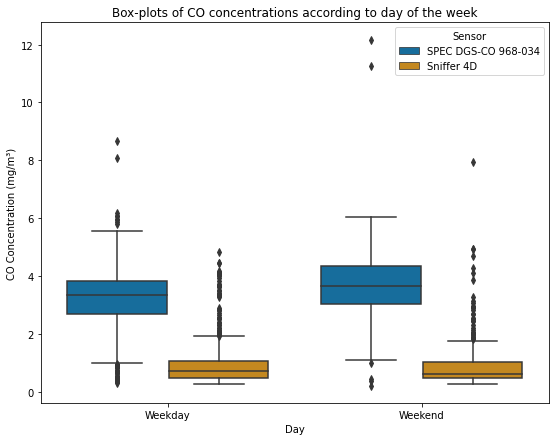

In [ ]:
data_spec = dados_SPEC_validGeo[dados_SPEC_validGeo['Area Type'] == 'STREET'].copy()
data_sniffer = dados_Sniffer_Geo[dados_Sniffer_Geo['Area Type'] == 'STREET'].copy()

data_spec['Sensor'] = data_spec.index.map(
    lambda i: 'SPEC DGS-CO 968-034')
data_sniffer['Sensor'] = data_sniffer.index.map(
    lambda i: 'Sniffer 4D')
data_spec['Day'] = data_spec['Weekend'].map(
    lambda d: 'Weekend' if d else 'Weekday')
data_sniffer['Day'] = data_sniffer['Weekend'].map(
    lambda d: 'Weekend' if d else 'Weekday')

dados_boxplot = pd.DataFrame(columns=['Day', 'Sensor', 'CO Concentration (mg/m\N{SUPERSCRIPT THREE})'])
dados_boxplot = pd.concat([data_spec[['Day', 'Sensor', 'Value']]
                           .rename(columns={"Value": "CO Concentration (mg/m\N{SUPERSCRIPT THREE})"})
                           .dropna(axis='index', how='any'),
                           data_sniffer[['Day', 'Sensor', 'CO']]
                           .rename(columns={"CO": "CO Concentration (mg/m\N{SUPERSCRIPT THREE})"})
                           .dropna(axis='index', how='any')])

fig = plt.figure(figsize=(1.3*7,7))
ax = sns.boxplot(y='CO Concentration (mg/m\N{SUPERSCRIPT THREE})', 
                 x='Day', data=dados_boxplot, palette="colorblind",
                 hue='Sensor')
ax.set_title('Box-plots of CO concentrations according to day of the week')

##### Plota valores de concentração SPEC rush hour

(-0.5, 186.5, 269.5, -0.5)

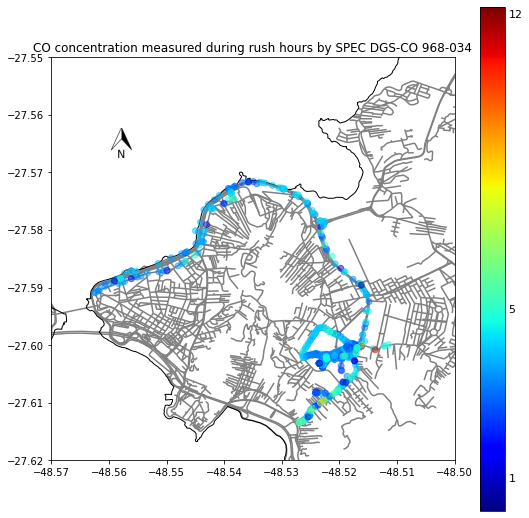

In [ ]:
fig = plt.figure(figsize=(7,7))

zoom_rectX = -48.57
zoom_rectY = -27.62
zoom_rectW = 0.07

ax2 = fig.add_axes([0.0,0.0,0.8,1])
fln_gpd.geometry.boundary.plot(ax=ax2, color = 'k', linewidth = 1.0)
ax2.set_xlim(zoom_rectX, zoom_rectX+zoom_rectW) 
ax2.set_ylim(zoom_rectY, zoom_rectY+zoom_rectW)
ax2.set_title('CO concentration measured during rush hours by SPEC DGS-CO 968-034',
              fontsize=12)

net_gpd.plot(ax=ax2, color='gray', zorder=1)

data = dados_SPEC_validGeo
data[data['RushHr'] == True].plot(
    ax=ax2, column = 'Value', alpha=0.5, legend = False, 
    zorder=2, cmap='jet', vmin = dados_SPEC_validGeo['Value'].min(), 
    vmax = dados_SPEC_validGeo['Value'].max())

img = plt.imshow([np.array(data['Value'])], cmap='jet')
cax = plt.axes([0.85, 0.0, 0.05, 1])
cbar = plt.colorbar(orientation='vertical', cax=cax)
cbar.ax.tick_params(labelsize=11, length=0)
ticks = [np.int64(data['Value'].min()+1),
         np.int64((data['Value'].max()
         -data['Value'].min())/2),
         np.int64(data['Value'].max())]
cbar.set_ticks(np.array(ticks))

im = plt.imread(shapefileFolder.joinpath(
    'north.png'))
newax = fig.add_axes([0.1, 0.7, 0.06, 0.06], anchor='NE', zorder = 3)
newax.imshow(im)
newax.axis('off')

##### Plota valores de concentração Sniffer rush hour

(-0.5, 186.5, 269.5, -0.5)

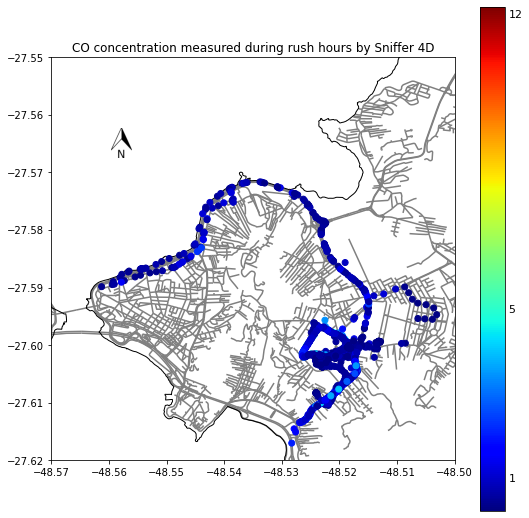

In [ ]:
fig = plt.figure(figsize=(7,7))

zoom_rectX = -48.57
zoom_rectY = -27.62
zoom_rectW = 0.07

ax2 = fig.add_axes([0.0,0.0,0.8,1])
fln_gpd.geometry.boundary.plot(ax=ax2, color = 'k', linewidth = 1.0)
ax2.set_xlim(zoom_rectX, zoom_rectX+zoom_rectW) 
ax2.set_ylim(zoom_rectY, zoom_rectY+zoom_rectW)
ax2.set_title('CO concentration measured during rush hours by Sniffer 4D',
              fontsize=12)

net_gpd.plot(ax=ax2, color='gray', zorder=1)

data = dados_Sniffer_Geo
data[data['RushHr'] == True].plot(
    ax=ax2, column = 'CO', alpha=1.0, legend = False, 
    zorder=2, cmap='jet', vmin = dados_SPEC_validGeo['Value'].min(), 
    vmax = dados_SPEC_validGeo['Value'].max())

img = plt.imshow([np.array(dados_SPEC_validGeo['Value'])], cmap='jet')
cax = plt.axes([0.85, 0.0, 0.05, 1])
cbar = plt.colorbar(orientation='vertical', cax=cax)
cbar.ax.tick_params(labelsize=11, length=0)
ticks = [np.int64(dados_SPEC_validGeo['Value'].min()+1),
         np.int64((dados_SPEC_validGeo['Value'].max()
         -dados_SPEC_validGeo['Value'].min())/2),
         np.int64(dados_SPEC_validGeo['Value'].max())]
cbar.set_ticks(np.array(ticks))

im = plt.imread(shapefileFolder.joinpath(
    'north.png'))
newax = fig.add_axes([0.1, 0.7, 0.06, 0.06], anchor='NE', zorder = 3)
newax.imshow(im)
newax.axis('off')

##### Plota valores de concentração SPEC não rush hour

(-0.5, 186.5, 269.5, -0.5)

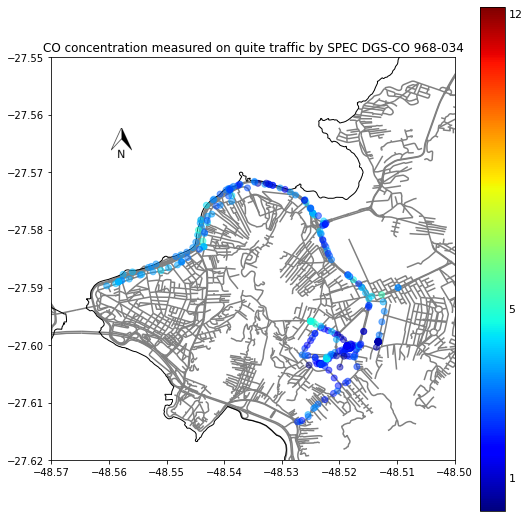

In [ ]:
fig = plt.figure(figsize=(7,7))

zoom_rectX = -48.57
zoom_rectY = -27.62
zoom_rectW = 0.07

ax2 = fig.add_axes([0.0,0.0,0.8,1])
fln_gpd.geometry.boundary.plot(ax=ax2, color = 'k', linewidth = 1.0)
ax2.set_xlim(zoom_rectX, zoom_rectX+zoom_rectW) 
ax2.set_ylim(zoom_rectY, zoom_rectY+zoom_rectW)
ax2.set_title('CO concentration measured on quite traffic by SPEC DGS-CO 968-034',
              fontsize=12)

net_gpd.plot(ax=ax2, color='gray', zorder=1)

data = dados_SPEC_validGeo
data[data['RushHr'] == False].plot(
    ax=ax2, column = 'Value', alpha=0.5, legend = False, 
    zorder=2, cmap='jet', vmin = data['Value'].min(), 
    vmax = data['Value'].max())

img = plt.imshow([np.array(data['Value'])], cmap='jet')
cax = plt.axes([0.85, 0.0, 0.05, 1])
cbar = plt.colorbar(orientation='vertical', cax=cax)
cbar.ax.tick_params(labelsize=11, length=0)
ticks = [np.int64(data['Value'].min()+1),
         np.int64((data['Value'].max()
         -data['Value'].min())/2),
         np.int64(data['Value'].max())]
cbar.set_ticks(np.array(ticks))

im = plt.imread(shapefileFolder.joinpath(
    'north.png'))
newax = fig.add_axes([0.1, 0.7, 0.06, 0.06], anchor='NE', zorder = 3)
newax.imshow(im)
newax.axis('off')

##### Plota valores de concentração Sniffer não rush hour

(-0.5, 186.5, 269.5, -0.5)

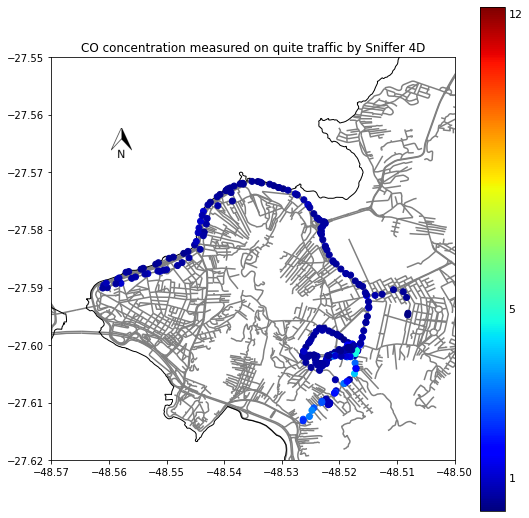

In [ ]:
fig = plt.figure(figsize=(7,7))

zoom_rectX = -48.57
zoom_rectY = -27.62
zoom_rectW = 0.07

ax2 = fig.add_axes([0.0,0.0,0.8,1])
fln_gpd.geometry.boundary.plot(ax=ax2, color = 'k', linewidth = 1.0)
ax2.set_xlim(zoom_rectX, zoom_rectX+zoom_rectW) 
ax2.set_ylim(zoom_rectY, zoom_rectY+zoom_rectW)
ax2.set_title('CO concentration measured on quite traffic by Sniffer 4D',
              fontsize=12)

net_gpd.plot(ax=ax2, color='gray', zorder=1)

data = dados_Sniffer_Geo
data[data['RushHr'] == False].plot(
    ax=ax2, column = 'CO', alpha=1.0, legend = False, 
    zorder=2, cmap='jet', vmin = dados_SPEC_validGeo['Value'].min(), 
    vmax = dados_SPEC_validGeo['Value'].max())

img = plt.imshow([np.array(dados_SPEC_validGeo['Value'])], cmap='jet')
cax = plt.axes([0.85, 0.0, 0.05, 1])
cbar = plt.colorbar(orientation='vertical', cax=cax)
cbar.ax.tick_params(labelsize=11, length=0)
ticks = [np.int64(dados_SPEC_validGeo['Value'].min()+1),
         np.int64((dados_SPEC_validGeo['Value'].max()
         -dados_SPEC_validGeo['Value'].min())/2),
         np.int64(dados_SPEC_validGeo['Value'].max())]
cbar.set_ticks(np.array(ticks))

im = plt.imread(shapefileFolder.joinpath(
    'north.png'))
newax = fig.add_axes([0.1, 0.7, 0.06, 0.06], anchor='NE', zorder = 3)
newax.imshow(im)
newax.axis('off')

##### Boxplot segundo horário

Text(0.5, 1.0, 'Box-plots of CO concentrations according to traffic pattern')

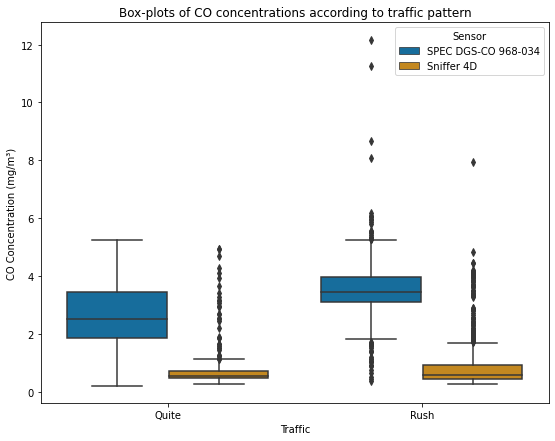

In [ ]:
dados_SPEC_validGeo['Sensor'] = dados_SPEC_validGeo.index.map(
    lambda i: 'SPEC DGS-CO 968-034')
dados_Sniffer_Geo['Sensor'] = dados_Sniffer_Geo.index.map(
    lambda i: 'Sniffer 4D')
dados_SPEC_validGeo['Traffic'] = dados_SPEC_validGeo['RushHr'].map(
    lambda h: 'Rush' if h else 'Quite')
dados_Sniffer_Geo['Traffic'] = dados_Sniffer_Geo['RushHr'].map(
    lambda h: 'Rush' if h else 'Quite')

dados_boxplot = pd.DataFrame(columns=['Traffic', 'Sensor', 'CO Concentration (mg/m\N{SUPERSCRIPT THREE})'])
dados_boxplot = pd.concat([dados_SPEC_validGeo[['Traffic', 'Sensor', 'Value']]
                           .rename(columns={"Value": "CO Concentration (mg/m\N{SUPERSCRIPT THREE})"})
                           .dropna(axis='index', how='any'),
                           dados_Sniffer_Geo[['Traffic', 'Sensor', 'CO']]
                           .rename(columns={"CO": "CO Concentration (mg/m\N{SUPERSCRIPT THREE})"})
                           .dropna(axis='index', how='any')])

fig = plt.figure(figsize=(1.3*7,7))
ax = sns.boxplot(y='CO Concentration (mg/m\N{SUPERSCRIPT THREE})', 
                 x='Traffic', data=dados_boxplot, palette="colorblind",
                 hue='Sensor')
ax.set_title('Box-plots of CO concentrations according to traffic pattern')

##### Plota valores de concentração SPEC rush hour em ruas

(-0.5, 186.5, 269.5, -0.5)

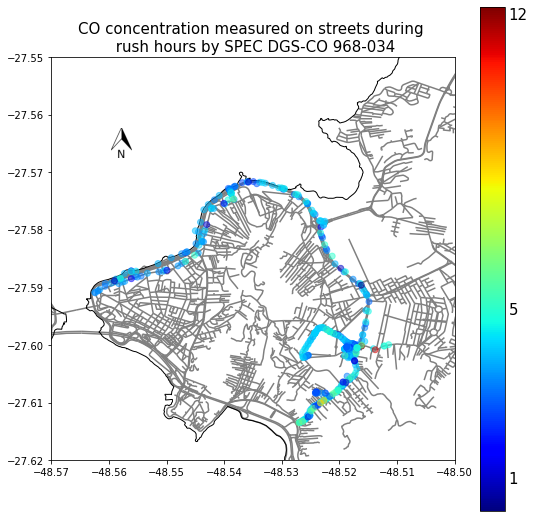

In [ ]:
fig = plt.figure(figsize=(7,7))

zoom_rectX = -48.57
zoom_rectY = -27.62
zoom_rectW = 0.07

ax2 = fig.add_axes([0.0,0.0,0.8,1])
fln_gpd.geometry.boundary.plot(ax=ax2, color = 'k', linewidth = 1.0)

ax2.set_xlim(zoom_rectX, zoom_rectX+zoom_rectW)
ax2.set_ylim(zoom_rectY, zoom_rectY+zoom_rectW)
ax2.set_title('CO concentration measured on streets during \n rush hours by SPEC DGS-CO 968-034',
              fontsize=15)

net_gpd.plot(ax=ax2, color='gray', zorder=1)

data = dados_SPEC_validGeo
data[(data['RushHr'] == True) &
     (data['Area Type'] == 'STREET')].plot(
    ax=ax2, column = 'Value', alpha=0.5, legend = False, 
    zorder=2, cmap='jet', vmin = dados_SPEC_validGeo['Value'].min(), 
    vmax = dados_SPEC_validGeo['Value'].max())

img = plt.imshow([np.array(data['Value'])], cmap='jet')
cax = plt.axes([0.85, 0.0, 0.05, 1])
cbar = plt.colorbar(orientation='vertical', cax=cax)
cbar.ax.tick_params(labelsize=11, length=0)
ticks = [np.int64(data['Value'].min()+1),
         np.int64((data['Value'].max()
         -data['Value'].min())/2),
         np.int64(data['Value'].max())]
cbar.set_ticks(np.array(ticks))
cbar.ax.tick_params(labelsize=15, length=0)

im = plt.imread(shapefileFolder.joinpath(
    'north.png'))
newax = fig.add_axes([0.1, 0.7, 0.06, 0.06], anchor='NE', zorder = 3)
newax.imshow(im)
newax.axis('off')

##### Plota valores de concentração Sniffer rush hour em ruas

(-0.5, 186.5, 269.5, -0.5)

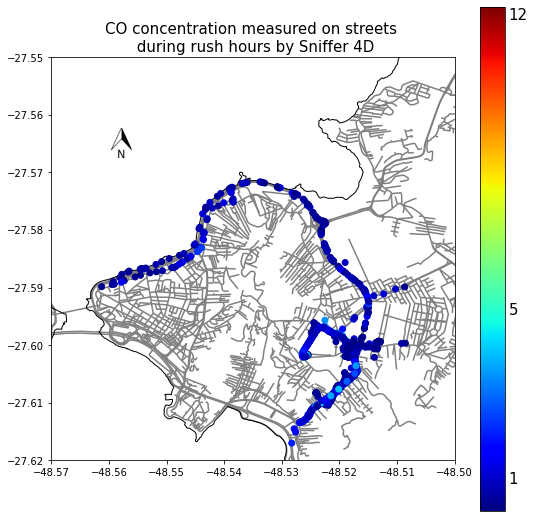

In [ ]:
fig = plt.figure(figsize=(7,7))

zoom_rectX = -48.57
zoom_rectY = -27.62
zoom_rectW = 0.07

ax2 = fig.add_axes([0.0,0.0,0.8,1])
fln_gpd.geometry.boundary.plot(ax=ax2, color = 'k', linewidth = 1.0)
ax2.set_xlim(zoom_rectX, zoom_rectX+zoom_rectW) 
ax2.set_ylim(zoom_rectY, zoom_rectY+zoom_rectW)
ax2.set_title('CO concentration measured on streets \n during rush hours by Sniffer 4D',
              fontsize=15)

net_gpd.plot(ax=ax2, color='gray', zorder=1)

data = dados_Sniffer_Geo
data[(data['RushHr'] == True) &
     (data['Area Type'] == 'STREET')].plot(
    ax=ax2, column = 'CO', alpha=1.0, legend = False, 
    zorder=2, cmap='jet', vmin = dados_SPEC_validGeo['Value'].min(), 
    vmax = dados_SPEC_validGeo['Value'].max())

img = plt.imshow([np.array(dados_SPEC_validGeo['Value'])], cmap='jet')
cax = plt.axes([0.85, 0.0, 0.05, 1])
cbar = plt.colorbar(orientation='vertical', cax=cax)
cbar.ax.tick_params(labelsize=11, length=0)
ticks = [np.int64(dados_SPEC_validGeo['Value'].min()+1),
         np.int64((dados_SPEC_validGeo['Value'].max()
         -dados_SPEC_validGeo['Value'].min())/2),
         np.int64(dados_SPEC_validGeo['Value'].max())]
cbar.set_ticks(np.array(ticks))
cbar.ax.tick_params(labelsize=15, length=0)

im = plt.imread(shapefileFolder.joinpath(
    'north.png'))
newax = fig.add_axes([0.1, 0.7, 0.06, 0.06], anchor='NE', zorder = 3)
newax.imshow(im)
newax.axis('off')

##### Plota valores de concentração SPEC não rush hour em ruas

(-0.5, 186.5, 269.5, -0.5)

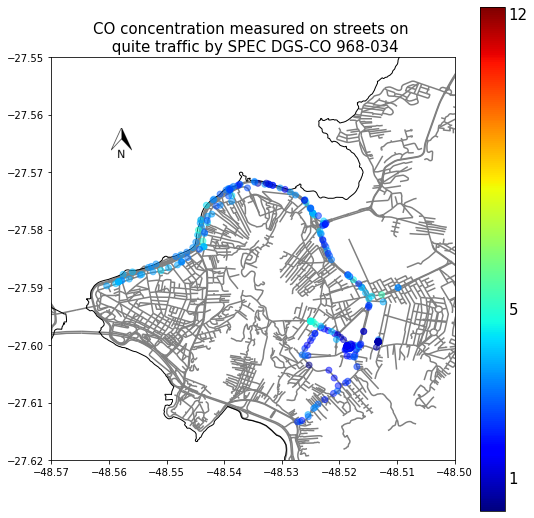

In [ ]:
fig = plt.figure(figsize=(7,7))

zoom_rectX = -48.57
zoom_rectY = -27.62
zoom_rectW = 0.07

ax2 = fig.add_axes([0.0,0.0,0.8,1])
fln_gpd.geometry.boundary.plot(ax=ax2, color = 'k', linewidth = 1.0)
ax2.set_xlim(zoom_rectX, zoom_rectX+zoom_rectW) 
ax2.set_ylim(zoom_rectY, zoom_rectY+zoom_rectW)
ax2.set_title('CO concentration measured on streets on \n quite traffic by SPEC DGS-CO 968-034',
              fontsize=15)

net_gpd.plot(ax=ax2, color='gray', zorder=1)

data = dados_SPEC_validGeo
data[(data['RushHr'] == False) &
     (data['Area Type'] == 'STREET')].plot(
    ax=ax2, column = 'Value', alpha=0.5, legend = False, 
    zorder=2, cmap='jet', vmin = data['Value'].min(), 
    vmax = data['Value'].max())

img = plt.imshow([np.array(data['Value'])], cmap='jet')
cax = plt.axes([0.85, 0.0, 0.05, 1])
cbar = plt.colorbar(orientation='vertical', cax=cax)
cbar.ax.tick_params(labelsize=11, length=0)
ticks = [np.int64(data['Value'].min()+1),
         np.int64((data['Value'].max()
         -data['Value'].min())/2),
         np.int64(data['Value'].max())]
cbar.set_ticks(np.array(ticks))
cbar.ax.tick_params(labelsize=15, length=0)

im = plt.imread(shapefileFolder.joinpath(
    'north.png'))
newax = fig.add_axes([0.1, 0.7, 0.06, 0.06], anchor='NE', zorder = 3)
newax.imshow(im)
newax.axis('off')

##### Plota valores de concentração Sniffer não rush hour em ruas

(-0.5, 186.5, 269.5, -0.5)

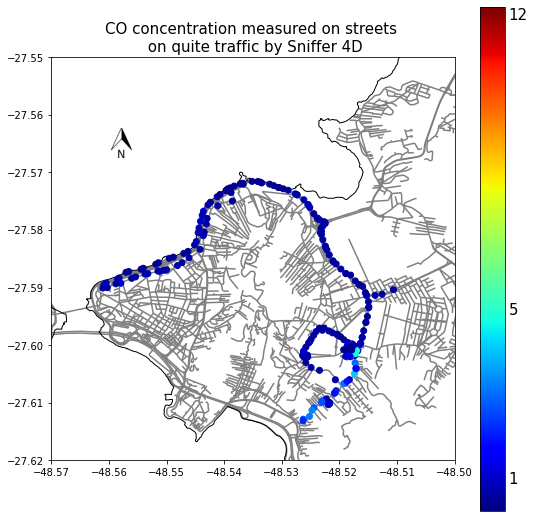

In [ ]:
fig = plt.figure(figsize=(7,7))

zoom_rectX = -48.57
zoom_rectY = -27.62
zoom_rectW = 0.07

ax2 = fig.add_axes([0.0,0.0,0.8,1])
fln_gpd.geometry.boundary.plot(ax=ax2, color = 'k', linewidth = 1.0)
ax2.set_xlim(zoom_rectX, zoom_rectX+zoom_rectW) 
ax2.set_ylim(zoom_rectY, zoom_rectY+zoom_rectW)
ax2.set_title('CO concentration measured on streets \n on quite traffic by Sniffer 4D',
              fontsize=15)

net_gpd.plot(ax=ax2, color='gray', zorder=1)

data = dados_Sniffer_Geo
data[(data['RushHr'] == False) &
     (data['Area Type'] == 'STREET')].plot(
    ax=ax2, column = 'CO', alpha=1.0, legend = False, 
    zorder=2, cmap='jet', vmin = dados_SPEC_validGeo['Value'].min(), 
    vmax = dados_SPEC_validGeo['Value'].max())

img = plt.imshow([np.array(dados_SPEC_validGeo['Value'])], cmap='jet')
cax = plt.axes([0.85, 0.0, 0.05, 1])
cbar = plt.colorbar(orientation='vertical', cax=cax)
cbar.ax.tick_params(labelsize=11, length=0)
ticks = [np.int64(dados_SPEC_validGeo['Value'].min()+1),
         np.int64((dados_SPEC_validGeo['Value'].max()
         -dados_SPEC_validGeo['Value'].min())/2),
         np.int64(dados_SPEC_validGeo['Value'].max())]
cbar.set_ticks(np.array(ticks))
cbar.ax.tick_params(labelsize=15, length=0)

im = plt.imread(shapefileFolder.joinpath(
    'north.png'))
newax = fig.add_axes([0.1, 0.7, 0.06, 0.06], anchor='NE', zorder = 3)
newax.imshow(im)
newax.axis('off')

##### Boxplot segundo horário em ruas

Text(0.5, 1.0, 'Box-plots of normalized values of CO concentrations \n and relative humidity according to traffic pattern')

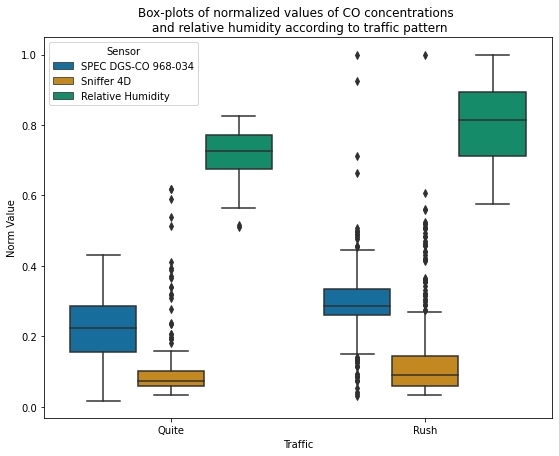

In [ ]:
data_spec = dados_SPEC_validGeo[dados_SPEC_validGeo['Area Type'] == 'STREET'].copy()
data_sniffer = dados_Sniffer_Geo[dados_Sniffer_Geo['Area Type'] == 'STREET'].copy()
data_rh = dados_RH_validGeo[dados_RH_validGeo['Area Type'] == 'STREET'].copy()

data_spec['Sensor'] = data_spec.index.map(
    lambda i: 'SPEC DGS-CO 968-034')
data_sniffer['Sensor'] = data_sniffer.index.map(
    lambda i: 'Sniffer 4D')
data_rh['Sensor'] = data_rh.index.map(
    lambda i: 'Relative Humidity')
data_spec['Traffic'] = data_spec['RushHr'].map(
    lambda h: 'Rush' if h else 'Quite')
data_sniffer['Traffic'] = data_sniffer['RushHr'].map(
    lambda h: 'Rush' if h else 'Quite')
data_rh['Traffic'] = data_rh['RushHr'].map(
    lambda h: 'Rush' if h else 'Quite')
data_spec['Norm Value'] = data_spec['Value'].map(
    lambda v: v/data_spec['Value'].max())
data_sniffer['Norm Value'] = data_sniffer['CO'].map(
    lambda v: v/data_sniffer['CO'].max())
data_rh['Norm Value'] = data_rh['Value'].map(
    lambda v: v/data_rh['Value'].max())

#dados_boxplot = pd.DataFrame(columns=['Traffic', 'Sensor', 'CO Concentration (mg/m\N{SUPERSCRIPT THREE})'])
#dados_boxplot = pd.concat([data_spec[['Traffic', 'Sensor', 'Value']]
#                           .rename(columns={"Value": "CO Concentration (mg/m\N{SUPERSCRIPT THREE})"})
#                           .dropna(axis='index', how='any'),
#                           data_sniffer[['Traffic', 'Sensor', 'CO']]
#                           .rename(columns={"CO": "CO Concentration (mg/m\N{SUPERSCRIPT THREE})"})
#                           .dropna(axis='index', how='any')])
dados_boxplot = pd.DataFrame(columns=['Traffic', 'Sensor', 'Norm Value'])
dados_boxplot = pd.concat([data_spec[['Traffic', 'Sensor', 'Norm Value']]
                           .dropna(axis='index', how='any'),
                           data_sniffer[['Traffic', 'Sensor', 'Norm Value']]
                           .dropna(axis='index', how='any'),
                           data_rh[['Traffic', 'Sensor', 'Norm Value']]
                           .dropna(axis='index', how='any'),])

fig = plt.figure(figsize=(1.3*7,7))
#ax = sns.boxplot(y='CO Concentration (mg/m\N{SUPERSCRIPT THREE})', 
#                 x='Traffic', data=dados_boxplot, palette="colorblind",
#                 hue='Sensor')
ax = sns.boxplot(y='Norm Value', 
                 x='Traffic', data=dados_boxplot, palette="colorblind",
                 hue='Sensor')
ax.set_title('Box-plots of normalized values of CO concentrations \n and relative humidity according to traffic pattern')

##### Plota valores de concentração SPEC rua, weekday, rush hour

(-0.5, 186.5, 269.5, -0.5)

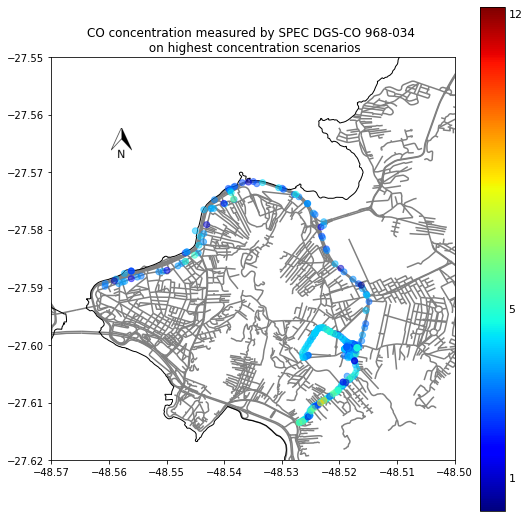

In [ ]:
fig = plt.figure(figsize=(7,7))

zoom_rectX = -48.57
zoom_rectY = -27.62
zoom_rectW = 0.07

ax2 = fig.add_axes([0.0,0.0,0.8,1])
fln_gpd.geometry.boundary.plot(ax=ax2, color = 'k', linewidth = 1.0)
ax2.set_xlim(zoom_rectX, zoom_rectX+zoom_rectW) 
ax2.set_ylim(zoom_rectY, zoom_rectY+zoom_rectW)
ax2.set_title('CO concentration measured by SPEC DGS-CO 968-034 \n on highest concentration scenarios',
              fontsize=12)

net_gpd.plot(ax=ax2, color='gray', zorder=1)

data = dados_SPEC_validGeo
data[(data['Area Type'] == 'STREET') &
     (data['Weekend'] == False) &
     (data['RushHr'] == True)].plot(
    ax=ax2, column = 'Value', alpha=0.5, legend = False, 
    zorder=2, cmap='jet', vmin = dados_SPEC_validGeo['Value'].min(), 
    vmax = dados_SPEC_validGeo['Value'].max())

img = plt.imshow([np.array(data['Value'])], cmap='jet')
cax = plt.axes([0.85, 0.0, 0.05, 1])
cbar = plt.colorbar(orientation='vertical', cax=cax)
cbar.ax.tick_params(labelsize=11, length=0)
ticks = [np.int64(data['Value'].min()+1),
         np.int64((data['Value'].max()
         -data['Value'].min())/2),
         np.int64(data['Value'].max())]
cbar.set_ticks(np.array(ticks))

im = plt.imread(shapefileFolder.joinpath(
    'north.png'))
newax = fig.add_axes([0.1, 0.7, 0.06, 0.06], anchor='NE', zorder = 3)
newax.imshow(im)
newax.axis('off')

##### Plota valores de concentração Sniffer rua, weeekday, rush hour

(-0.5, 186.5, 269.5, -0.5)

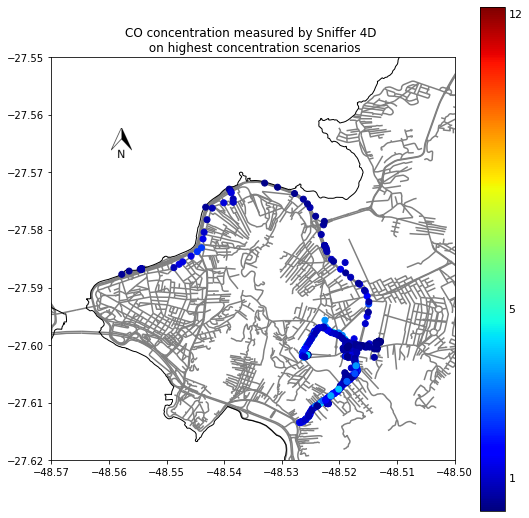

In [ ]:
fig = plt.figure(figsize=(7,7))

zoom_rectX = -48.57
zoom_rectY = -27.62
zoom_rectW = 0.07

ax2 = fig.add_axes([0.0,0.0,0.8,1])
fln_gpd.geometry.boundary.plot(ax=ax2, color = 'k', linewidth = 1.0)
ax2.set_xlim(zoom_rectX, zoom_rectX+zoom_rectW) 
ax2.set_ylim(zoom_rectY, zoom_rectY+zoom_rectW)
ax2.set_title('CO concentration measured by Sniffer 4D \n on highest concentration scenarios',
              fontsize=12)

net_gpd.plot(ax=ax2, color='gray', zorder=1)

data = dados_Sniffer_Geo
data[(data['Area Type'] == 'STREET') &
     (data['Weekend'] == False) &
     (data['RushHr'] == True)].plot(
    ax=ax2, column = 'CO', alpha=1.0, legend = False, 
    zorder=2, cmap='jet', vmin = dados_SPEC_validGeo['Value'].min(), 
    vmax = dados_SPEC_validGeo['Value'].max())

img = plt.imshow([np.array(dados_SPEC_validGeo['Value'])], cmap='jet')
cax = plt.axes([0.85, 0.0, 0.05, 1])
cbar = plt.colorbar(orientation='vertical', cax=cax)
cbar.ax.tick_params(labelsize=11, length=0)
ticks = [np.int64(dados_SPEC_validGeo['Value'].min()+1),
         np.int64((dados_SPEC_validGeo['Value'].max()
         -dados_SPEC_validGeo['Value'].min())/2),
         np.int64(dados_SPEC_validGeo['Value'].max())]
cbar.set_ticks(np.array(ticks))

im = plt.imread(shapefileFolder.joinpath(
    'north.png'))
newax = fig.add_axes([0.1, 0.7, 0.06, 0.06], anchor='NE', zorder = 3)
newax.imshow(im)
newax.axis('off')

##### Plota valores de concentração SPEC residencial, weekend, não rush hour

(-0.5, 186.5, 269.5, -0.5)

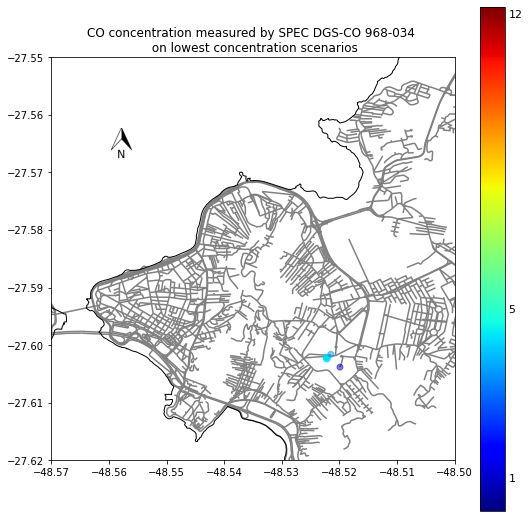

In [ ]:
fig = plt.figure(figsize=(7,7))

zoom_rectX = -48.57
zoom_rectY = -27.62
zoom_rectW = 0.07

ax2 = fig.add_axes([0.0,0.0,0.8,1])
fln_gpd.geometry.boundary.plot(ax=ax2, color = 'k', linewidth = 1.0)
ax2.set_xlim(zoom_rectX, zoom_rectX+zoom_rectW) 
ax2.set_ylim(zoom_rectY, zoom_rectY+zoom_rectW)
ax2.set_title('CO concentration measured by SPEC DGS-CO 968-034 \n on lowest concentration scenarios',
              fontsize=12)

net_gpd.plot(ax=ax2, color='gray', zorder=1)

data = dados_SPEC_validGeo
data[(data['Area Type'] == 'RESIDENTIAL') &
     (data['Weekend'] == True) &
     (data['RushHr'] == False)].plot(
    ax=ax2, column = 'Value', alpha=0.5, legend = False, 
    zorder=2, cmap='jet', vmin = data['Value'].min(), 
    vmax = data['Value'].max())

img = plt.imshow([np.array(data['Value'])], cmap='jet')
cax = plt.axes([0.85, 0.0, 0.05, 1])
cbar = plt.colorbar(orientation='vertical', cax=cax)
cbar.ax.tick_params(labelsize=11, length=0)
ticks = [np.int64(data['Value'].min()+1),
         np.int64((data['Value'].max()
         -data['Value'].min())/2),
         np.int64(data['Value'].max())]
cbar.set_ticks(np.array(ticks))

im = plt.imread(shapefileFolder.joinpath(
    'north.png'))
newax = fig.add_axes([0.1, 0.7, 0.06, 0.06], anchor='NE', zorder = 3)
newax.imshow(im)
newax.axis('off')

In [ ]:
dados_SPEC_validGeo[(dados_SPEC_validGeo['Area Type'] == 'RESIDENTIAL') &
                  (dados_SPEC_validGeo['Weekend'] == True) &
                  (dados_SPEC_validGeo['RushHr'] == False)].count()
dados_SPEC_validGeo[(dados_SPEC_validGeo['Area Type'] == 'RESIDENTIAL') &
                  (dados_SPEC_validGeo['Weekend'] == True) &
                  (dados_SPEC_validGeo['RushHr'] == False)]

Year  Month  ... Traffic Concentration scenario
DateTime                            ...                               
2020-08-08 11:00:00  2020.0    8.0  ...   Quite   Lowest Concentration
2020-08-08 11:01:00  2020.0    8.0  ...   Quite   Lowest Concentration
2020-08-08 11:02:00  2020.0    8.0  ...   Quite   Lowest Concentration
2020-08-08 11:03:00  2020.0    8.0  ...   Quite   Lowest Concentration
2020-08-08 11:04:00  2020.0    8.0  ...   Quite   Lowest Concentration
2020-08-08 11:05:00  2020.0    8.0  ...   Quite   Lowest Concentration
2020-08-08 11:06:00  2020.0    8.0  ...   Quite   Lowest Concentration
2020-08-08 11:07:00  2020.0    8.0  ...   Quite   Lowest Concentration
2020-08-08 11:08:00  2020.0    8.0  ...   Quite   Lowest Concentration
2020-08-08 16:55:00  2020.0    8.0  ...   Quite   Lowest Concentration

[10 rows x 14 columns]

##### Plota valores de concentração Sniffer residencial, weekends, não rush hour

(-0.5, 186.5, 269.5, -0.5)

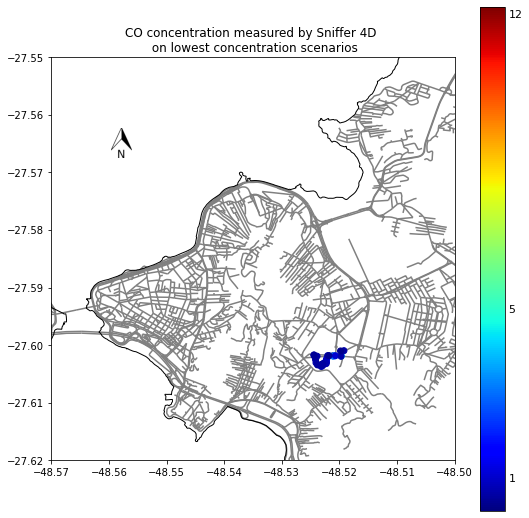

In [ ]:
fig = plt.figure(figsize=(7,7))

zoom_rectX = -48.57
zoom_rectY = -27.62
zoom_rectW = 0.07

ax2 = fig.add_axes([0.0,0.0,0.8,1])
fln_gpd.geometry.boundary.plot(ax=ax2, color = 'k', linewidth = 1.0)
ax2.set_xlim(zoom_rectX, zoom_rectX+zoom_rectW) 
ax2.set_ylim(zoom_rectY, zoom_rectY+zoom_rectW)
ax2.set_title('CO concentration measured by Sniffer 4D \n on lowest concentration scenarios',
              fontsize=12)

net_gpd.plot(ax=ax2, color='gray', zorder=1)

data = dados_Sniffer_Geo
data[(data['Area Type'] == 'RESIDENTIAL') &
     (data['Weekend'] == True) &
     (data['RushHr'] == False)].plot(
    ax=ax2, column = 'CO', alpha=1.0, legend = False, 
    zorder=2, cmap='jet', vmin = dados_SPEC_validGeo['Value'].min(), 
    vmax = dados_SPEC_validGeo['Value'].max())

img = plt.imshow([np.array(dados_SPEC_validGeo['Value'])], cmap='jet')
cax = plt.axes([0.85, 0.0, 0.05, 1])
cbar = plt.colorbar(orientation='vertical', cax=cax)
cbar.ax.tick_params(labelsize=11, length=0)
ticks = [np.int64(dados_SPEC_validGeo['Value'].min()+1),
         np.int64((dados_SPEC_validGeo['Value'].max()
         -dados_SPEC_validGeo['Value'].min())/2),
         np.int64(dados_SPEC_validGeo['Value'].max())]
cbar.set_ticks(np.array(ticks))

im = plt.imread(shapefileFolder.joinpath(
    'north.png'))
newax = fig.add_axes([0.1, 0.7, 0.06, 0.06], anchor='NE', zorder = 3)
newax.imshow(im)
newax.axis('off')

##### Boxplot segundo horário

Text(0.5, 1.0, 'Box-plots of CO concentrations according to traffic pattern')

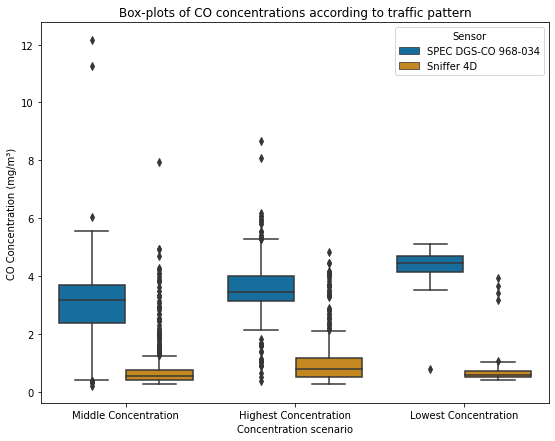

In [ ]:
def concentration_scenarios(d):
  if ((d[0] == 'STREET') and (not d[1]) and d[2]):
    return 'Highest Concentration'
  elif ((d[0] == 'RESIDENTIAL') and d[1] and (not d[2])):
    return 'Lowest Concentration'
  return 'Middle Concentration'

dados_SPEC_validGeo['Sensor'] = dados_SPEC_validGeo.index.map(
    lambda i: 'SPEC DGS-CO 968-034')
dados_Sniffer_Geo['Sensor'] = dados_Sniffer_Geo.index.map(
    lambda i: 'Sniffer 4D')
     
dados_SPEC_validGeo['Concentration scenario'] = dados_SPEC_validGeo[['Area Type','Weekend','RushHr']].apply(
    lambda d:  concentration_scenarios(d), axis=1)
dados_Sniffer_Geo['Concentration scenario'] = dados_Sniffer_Geo[['Area Type','Weekend','RushHr']].apply(
    lambda d: concentration_scenarios(d), axis=1)

dados_boxplot = pd.DataFrame(columns=['Concentration scenario', 'Sensor', 'CO Concentration (mg/m\N{SUPERSCRIPT THREE})'])
dados_boxplot = pd.concat([dados_SPEC_validGeo[['Concentration scenario', 'Sensor', 'Value']]
                           .rename(columns={"Value": "CO Concentration (mg/m\N{SUPERSCRIPT THREE})"})
                           .dropna(axis='index', how='any'),
                           dados_Sniffer_Geo[['Concentration scenario', 'Sensor', 'CO']]
                           .rename(columns={"CO": "CO Concentration (mg/m\N{SUPERSCRIPT THREE})"})
                           .dropna(axis='index', how='any')])

fig = plt.figure(figsize=(1.3*7,7))
ax = sns.boxplot(y='CO Concentration (mg/m\N{SUPERSCRIPT THREE})', 
                 x='Concentration scenario', data=dados_boxplot, palette="colorblind",
                 hue='Sensor')
ax.set_title('Box-plots of CO concentrations according to traffic pattern')

##### Plota valores de concentração SPEC em ruas dias da semana e rush hour no mapa

(-0.5, 186.5, 269.5, -0.5)

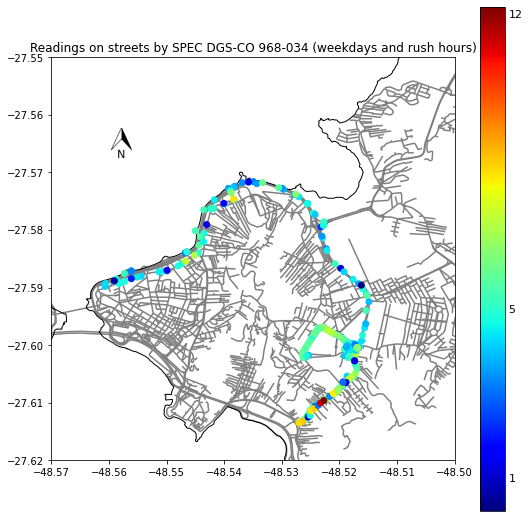

In [ ]:
fig = plt.figure(figsize=(7,7))

zoom_rectX = -48.57
zoom_rectY = -27.62
zoom_rectW = 0.07

ax2 = fig.add_axes([0.0,0.0,0.8,1])
fln_gpd.geometry.boundary.plot(ax=ax2, color = 'k', linewidth = 1.0)
ax2.set_xlim(zoom_rectX, zoom_rectX+zoom_rectW) 
ax2.set_ylim(zoom_rectY, zoom_rectY+zoom_rectW)
ax2.set_title('Readings on streets by SPEC DGS-CO 968-034 (weekdays and rush hours)')

net_gpd.plot(ax=ax2, color='gray', zorder=1)

data = dados_SPEC_validGeo
data[(data['Area Type'] == 'STREET') &
     (data['Weekend'] == False) &
     (data['RushHr'] == True)].plot(
    ax=ax2, column = 'Value', alpha=1.0, legend = False, 
    zorder=2, cmap='jet')

img = plt.imshow([np.array(data['Value'])], cmap='jet')
cax = plt.axes([0.85, 0.0, 0.05, 1])
cbar = plt.colorbar(orientation='vertical', cax=cax)
cbar.ax.tick_params(labelsize=11, length=0)
ticks = [np.int64(data['Value'].min()+1),
         np.int64((data['Value'].max()
         -data['Value'].min())/2),
         np.int64(data['Value'].max())]
cbar.set_ticks(np.array(ticks))

im = plt.imread(shapefileFolder.joinpath(
    'north.png'))
newax = fig.add_axes([0.1, 0.7, 0.06, 0.06], anchor='NE', zorder = 3)
newax.imshow(im)
newax.axis('off')

##### Estatísticas de valores de concentração SPEC em área Residencial

Year  Month         Day  ...    Latitude   Longitude        Value
count   247.0  247.0  247.000000  ...  247.000000  247.000000   247.000000
mean   2020.0    8.0    5.020243  ...  -27.602422  -48.521979  2780.161943
std       0.0    0.0    1.915808  ...    0.001078    0.001768   697.324920
min    2020.0    8.0    3.000000  ...  -27.604431  -48.524842   323.500000
25%    2020.0    8.0    4.000000  ...  -27.603156  -48.523300  2433.332500
50%    2020.0    8.0    5.000000  ...  -27.602369  -48.522315  2816.750000
75%    2020.0    8.0    5.000000  ...  -27.601819  -48.520812  3137.165000
max    2020.0    8.0   18.000000  ...  -27.594109  -48.512199  4794.170000

[8 rows x 7 columns]

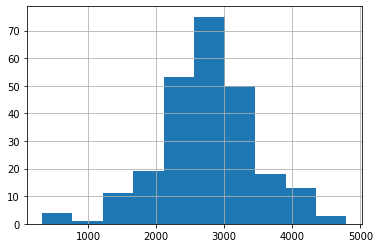

In [ ]:
dados_SPEC_validGeo[(dados_SPEC_validGeo['Area Type'] == 'RESIDENTIAL')]['Value'].hist()
dados_SPEC_validGeo[(dados_SPEC_validGeo['Area Type'] == 'RESIDENTIAL')].describe()

##### Plota valores de concentração Sniffer  em ruas dias da semana e rush hour no mapa

(-0.5, 186.5, 269.5, -0.5)

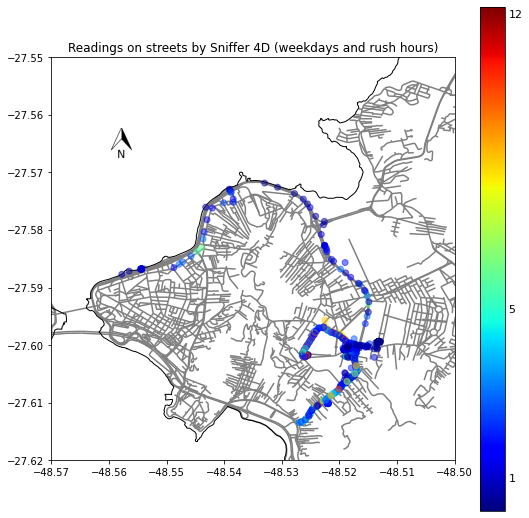

In [ ]:
fig = plt.figure(figsize=(7,7))

zoom_rectX = -48.57
zoom_rectY = -27.62
zoom_rectW = 0.07

ax2 = fig.add_axes([0.0,0.0,0.8,1])
fln_gpd.geometry.boundary.plot(ax=ax2, color = 'k', linewidth = 1.0)
ax2.set_xlim(zoom_rectX, zoom_rectX+zoom_rectW) 
ax2.set_ylim(zoom_rectY, zoom_rectY+zoom_rectW)
ax2.set_title('Readings on streets by Sniffer 4D (weekdays and rush hours)')

net_gpd.plot(ax=ax2, color='gray', zorder=1)

data = dados_Sniffer_Geo
data[(data['Area Type'] == 'STREET') &
     (data['Weekend'] == False) &
     (data['RushHr'] == True)].plot(
    ax=ax2, column = 'CO', alpha=0.5, legend = False, 
    zorder=2, cmap='jet')

img = plt.imshow([np.array(dados_SPEC_validGeo['Value'])], cmap='jet')
cax = plt.axes([0.85, 0.0, 0.05, 1])
cbar = plt.colorbar(orientation='vertical', cax=cax)
cbar.ax.tick_params(labelsize=11, length=0)
ticks = [np.int64(dados_SPEC_validGeo['Value'].min()+1),
         np.int64((dados_SPEC_validGeo['Value'].max()
         -dados_SPEC_validGeo['Value'].min())/2),
         np.int64(dados_SPEC_validGeo['Value'].max())]
cbar.set_ticks(np.array(ticks))

im = plt.imread(shapefileFolder.joinpath(
    'north.png'))
newax = fig.add_axes([0.1, 0.7, 0.06, 0.06], anchor='NE', zorder = 3)
newax.imshow(im)
newax.axis('off')

##### Estatísticas de valores de concentração Sniffer em área Residencial

Longitude    Latitude  Temperature    Humidity          CO
count  409.000000  409.000000   409.000000  409.000000  409.000000
mean   -48.521769  -27.602224    19.957629   67.816580    0.593175
std      0.003151    0.001821     2.689023    8.962520    0.573699
min    -48.525410  -27.604374    12.209151   48.104575    0.263142
25%    -48.523402  -27.603195    18.702615   62.996732    0.376375
50%    -48.522691  -27.602360    20.000000   69.192422    0.492750
75%    -48.520808  -27.601707    21.176470   73.519608    0.552206
max    -48.503095  -27.590713    25.794117   85.771242    4.208039

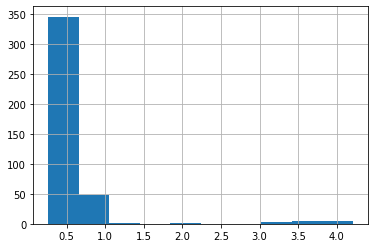

In [ ]:
dados_Sniffer_Geo[(dados_Sniffer_Geo['Area Type'] == 'RESIDENTIAL')]['CO'].hist()
dados_Sniffer_Geo[(dados_Sniffer_Geo['Area Type'] == 'RESIDENTIAL')].describe()

#### Mapa composto da Grande Florianópolis e zoom na área de interesse

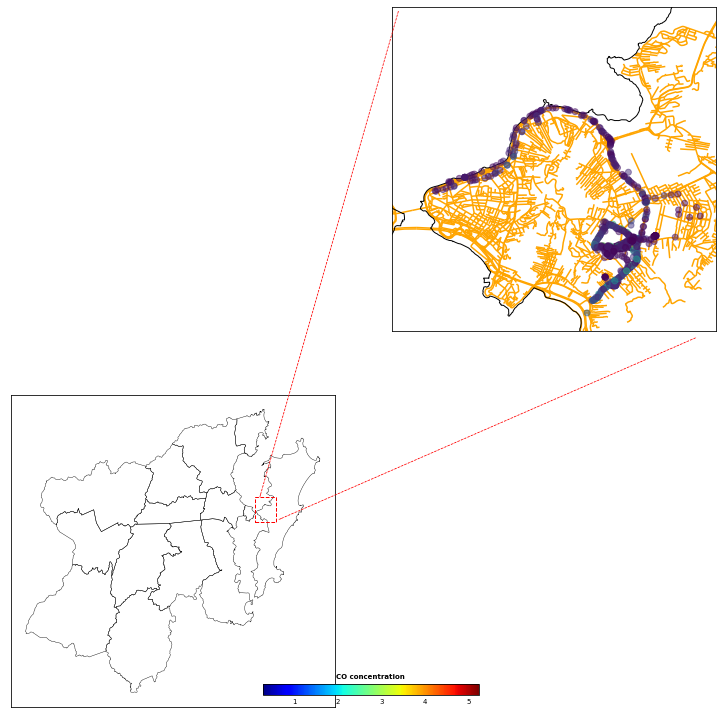

In [ ]:
fig = plt.figure(figsize=(10,10))

zoom_rectX = -48.57
zoom_rectY = -27.62
zoom_rectW = 0.07
zoom_Rect = plt.Rectangle((zoom_rectX, zoom_rectY), zoom_rectW, zoom_rectW, 
                          fill=None, edgecolor='red', zorder = 3, 
                          linestyle='dashed')

ax_width = 0.45; ax_spacing = 0.08
ax1_start = 0.01
ax = fig.add_axes([ax1_start, ax1_start, ax_width, ax_width])
sc_gpd.geometry.boundary.plot(ax=ax, color = 'k', linewidth = .4)
ax.set_xticks([]); ax.set_yticks([])
ax.add_patch(zoom_Rect)

ax2_start = ax1_start+ax_width+ax_spacing
ax2 = fig.add_axes([ax2_start, ax2_start, ax_width, ax_width])
sc_gpd.geometry.boundary.plot(ax=ax2, color = 'k', linewidth = 1.0)
ax2.set_xlim(zoom_rectX, zoom_rectX+zoom_rectW) 
ax2.set_ylim(zoom_rectY, zoom_rectY+zoom_rectW)
ax2.set_xticks([]); ax2.set_yticks([])

ax3_width = 2*ax_width+ax_spacing
ax3 = fig.add_axes([ax1_start, ax1_start, ax3_width, ax3_width], frameon=False)

x_line1_start = ((zoom_rectX - ax.get_xlim()[0])/
                (ax.get_xlim()[1] - ax.get_xlim()[0]))*(ax_width/ax3_width)
y_line1_start = (((zoom_rectY+zoom_rectW) - ax.get_ylim()[0])/
                (ax.get_ylim()[1] - ax.get_ylim()[0])*(ax_width/ax3_width))
x_line2_start = (((zoom_rectX+zoom_rectW) - ax.get_xlim()[0])/
                (ax.get_xlim()[1] - ax.get_xlim()[0]))*(ax_width/ax3_width)
y_line2_start = ((zoom_rectY - ax.get_ylim()[0])/
                (ax.get_ylim()[1] - ax.get_ylim()[0])*(ax_width/ax3_width))

cat1 = ax2_start-x_line1_start
cat2 = ax2_start+ax_width-y_line1_start
hyp = np.sqrt(np.square(cat1)+np.square(cat2))
angle_line1 = np.arccos(cat1/hyp)*180/np.pi
len_line1 = 20*np.int64(hyp*10)

cat1 = ax2_start+ax_width-x_line2_start
cat2 = ax2_start-y_line2_start
hyp = np.sqrt(np.square(cat1)+np.square(cat2))
angle_line2 = np.arccos(cat1/hyp)*180/np.pi
len_line2 = 21*np.int64(hyp*10)

ax3.annotate(len_line1*'-', xy=(x_line1_start, y_line1_start), 
             rotation = angle_line1, color = 'red')
ax3.annotate(len_line2*'-', xy=(x_line2_start, y_line2_start), 
             rotation = angle_line2, color = 'red')
ax3.set_xticks([]); ax3.set_yticks([])

im = plt.imread(shapefileFolder.joinpath(
    'north.png'))
newax = fig.add_axes([0.80, 0.25, 0.06, 0.06], anchor='NE', zorder = 1)
newax.imshow(im)
newax.axis('off')

net_gpd.plot(ax=ax2, color='orange', zorder=1)
dados_Sniffer_Geo.plot(ax=ax2, column = 'CO', alpha=0.5, zorder=2)

import matplotlib.pyplot as pl
img = pl.imshow([np.array(dados_Sniffer_Geo['CO'])], cmap='jet')
pl.gca().set_visible(False)
cax = pl.axes([0.36, 0.035, 0.3, 0.015])
cbar = pl.colorbar(orientation='horizontal', cax=cax, ticks=[1,2,3,4,5])
cbar.ax.set_title('CO concentration', fontsize=7, weight='bold')
cbar.ax.tick_params(labelsize=7, length=0)

#### Mapas filtrando por poligono de interesse

#### Polígono de interesse

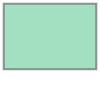

In [ ]:
coords = [(-48.566669136057264,-27.622683492893824),
          (-48.49079480744398,-27.622683492893824),
          (-48.49079480744398,-27.568980648735792),
          (-48.566669136057264,-27.568980648735792),
          (-48.566669136057264,-27.622683492893824)]

#coords = [(-48.53834500886,-27.568904563728847),
#          (-48.566154151926405,-27.590206304879818),
#          (-48.56306424714125,-27.600399245754083),
#          (-48.552421241770155,-27.615762932202422),
#          (-48.53199353791273,-27.619717591866394),
#          (-48.50778928376234,-27.601159874976968),
#          (-48.50435605622328,-27.585033405226984),
#          (-48.530448585520155,-27.568448052579466),
#          (-48.53834500886,-27.568904563728847)]

polyFLN = Polygon(coords)
polyFLN

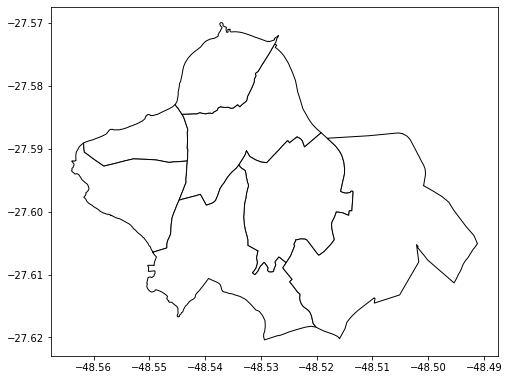

In [ ]:
sc_gpd['Valid'] = sc_gpd['geometry'].map(
    lambda p: True if p.within(polyFLN) else False)
sc_gpd[sc_gpd['Valid']].plot(color='white', edgecolor='black', 
                             figsize=(8,8))

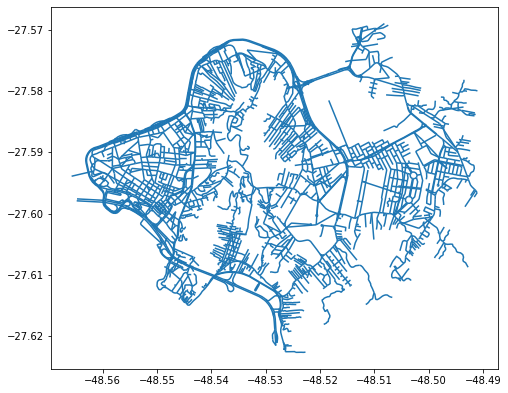

In [ ]:
net_gpd['Valid'] = net_gpd['geometry'].map(
    lambda p: True if p.within(polyFLN) else False)
net_gpd[net_gpd['Valid']].plot(figsize=(8,8))

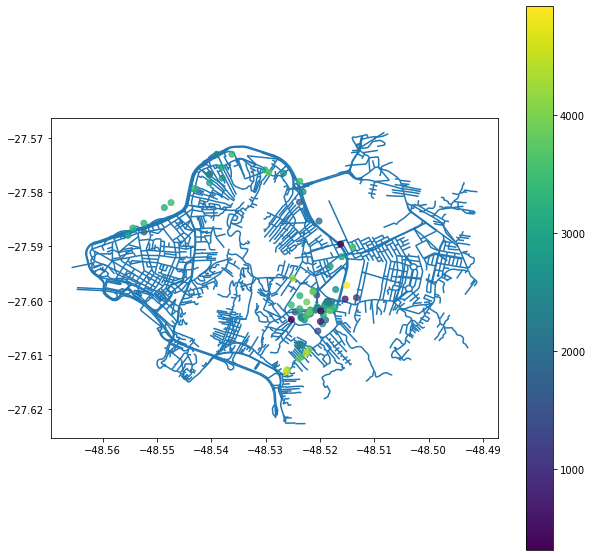

In [ ]:
dados_SPEC_validGeo['Valid'] = dados_SPEC_validGeo['geometry'].map(
    lambda p: True if p.within(polyFLN) else False)

base = net_gpd[net_gpd['Valid']].plot(figsize=(10,10), zorder=1)
dados_SPEC_validGeo[dados_SPEC_validGeo['Valid']].plot(figsize=(10,10),
    ax=base, column = 'Value', legend = True, alpha = 0.8, zorder=2)